### Further clean DELINQUENCY variables (round to 2 decimals / integerize / ...)

In [396]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel
from tqdm import tqdm

In [397]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [398]:
from utils.common import *
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, print_percentile,
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, describe_all, check_psi, plot_heatmap, check_summary
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, check_roc_auc,
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [399]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [400]:
gc.collect()

971100

In [401]:
START = time.time()

### Setup

In [406]:
%%time
train = read_file(f"../{RAW_TRAIN_PARQUET_PATH}/delinquency1.parquet")
test = read_file(f"../{RAW_TEST_PARQUET_PATH}/delinquency1.parquet")

Shape of data: (5531451, 54)
Shape of data: (11363762, 54)
CPU times: user 31.5 s, sys: 1min 2s, total: 1min 34s
Wall time: 54 s


In [407]:
%%time
labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 2.79 s, sys: 4.12 s, total: 6.91 s
Wall time: 10.6 s


In [408]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 7.92 s, sys: 4.37 s, total: 12.3 s
Wall time: 13.3 s


In [409]:
del test

In [410]:
train.shape, public_test.shape, private_test.shape

((5531451, 55), (5719469, 54), (5644293, 54))

In [411]:
df_list = [train, public_test, private_test]

In [412]:
print(sorted(get_cols(train, ["D_"])))

['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_66', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96']


In [413]:
train["target"].mean()

0.24909720794778803

In [414]:
for df in df_list:
    insert_row_number(df)

Done insertion
Done insertion
Done insertion


In [415]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [416]:
# train_corr = train.loc[:, train.columns[4:-1]].corr()
# train_corr.to_csv(f"../{RAW_DATA_PATH}/pre_clean_train_delinquency1_corr.csv", index=False)

In [417]:
# train_corr = read_file(f"../{RAW_DATA_PATH}/pre_clean_train_delinquency1_corr.csv")
# train_corr.index = train_corr.columns

### D_39 (KIV) Suspicious Spike

In [19]:
# plot_target_check(train, "D_39", q=50, use_raw_bin=True, nunique_thr=1000)

In [20]:
%%time
df_list = round_dfs(df_list, col="D_39", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0589
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0370
CPU times: user 6.09 s, sys: 7.97 s, total: 14.1 s
Wall time: 22 s


In [21]:
# plot_target_check(train, "D_39", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [22]:
%%time
for df in df_list:
    df["D_39_"] = ((df["D_39"] - 0.02) / 0.0291).apply(np.floor)
    # df["D_39"] = df["D_39"].parallel_apply(lambda x: manual_stack(x, start=92, stack_interval=10, denom=1))

CPU times: user 123 ms, sys: 54.7 ms, total: 178 ms
Wall time: 180 ms


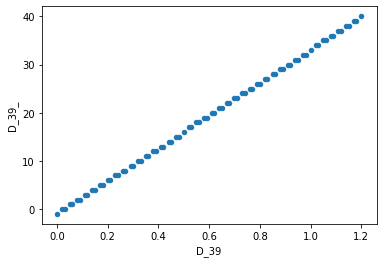

In [23]:
check_binning(train, "D_39", end=80)

In [24]:
%%time
for df in df_list:
    df["D_39"] = ((df["D_39"] - 0.02) / 0.0291).apply(np.floor).replace(-1, np.nan)

CPU times: user 1.06 s, sys: 710 ms, total: 1.77 s
Wall time: 1.77 s


In [25]:
for df in df_list:
    df = clip_col(df, "D_39", top_value=100, add_new_col=False)

3053463 null count, 0.552 null proportion
0.1787 of the targets have label = 1


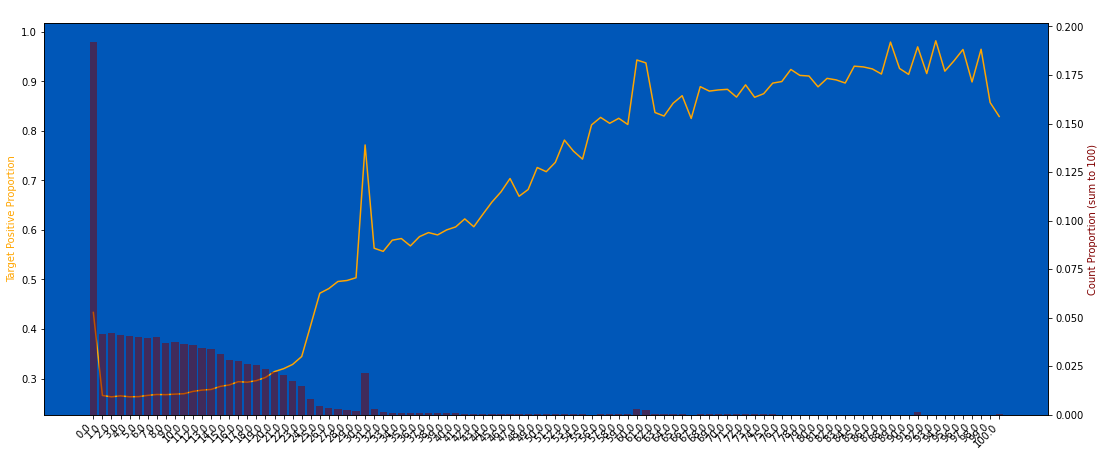

In [26]:
plot_target_check(train, "D_39", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [165]:
describe_all(df_list, "D_39").loc["null_proportion"]

train          0.5520
public test    0.5345
private test   0.5304
Name: null_proportion, dtype: float64

In [27]:
# plot_train_test_distribution(df_list, "D_39", nunique_thr=1000)

### D_41 (Done)

In [28]:
# plot_target_check(train, "D_41", q=50, use_raw_bin=True)

In [29]:
%%time
df_list = round_dfs(df_list, col="D_41", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0816
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0750
CPU times: user 4.94 s, sys: 4.36 s, total: 9.3 s
Wall time: 13.3 s


In [30]:
# %%time
# for df in df_list:
#     df["D_41_"] = df["D_41"].parallel_apply(lambda x: manual_stack(x, start=0.04, stack_interval=0.05, denom=100))

In [31]:
print_percentile(df_list, "D_41", 99.01)

99.01th percentile:
train : 1.0
public test : 1.0
private test : 1.0


In [32]:
for df in df_list:
    df = clip_col(df, "D_41", top_value=2, add_new_col=False)

In [33]:
for df in df_list:
    df["D_41"] = df["D_41"].replace(0, np.nan)

4813316 null count, 0.870 null proportion
0.2086 of the targets have label = 1


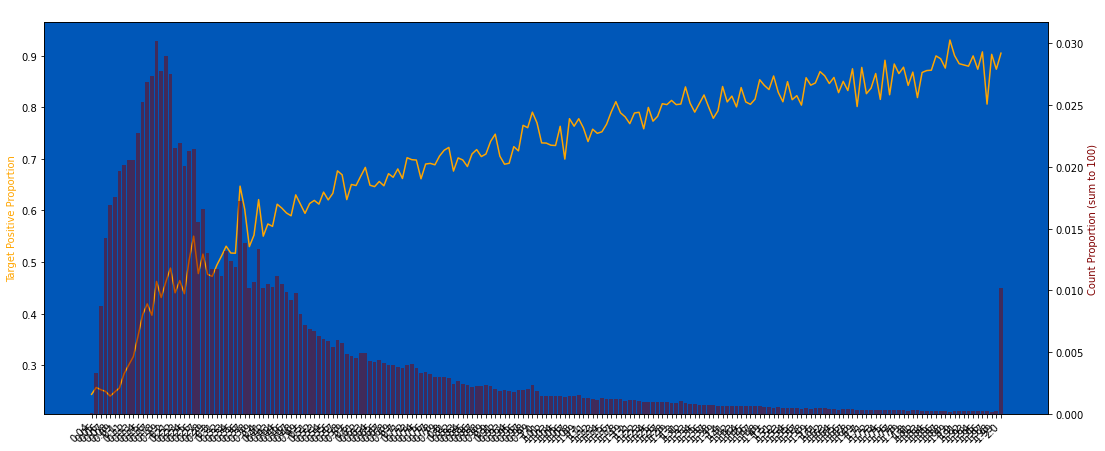

In [34]:
plot_target_check(train, "D_41", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [166]:
describe_all(df_list, "D_41").loc["null_proportion"]

train          0.8702
public test    0.8708
private test   0.8733
Name: null_proportion, dtype: float64

In [35]:
# plot_train_test_distribution(df_list, "D_41", nunique_thr=1000)

### D_42 (KIV) can try impute?

In [36]:
# plot_target_check(train, "D_42", q=50, use_raw_bin=True)

In [37]:
r = describe_all(df_list, "D_42")

In [38]:
%%time
df_list = round_dfs(df_list, col="D_42", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1110
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0645
CPU times: user 4.43 s, sys: 5.22 s, total: 9.66 s
Wall time: 14.9 s


In [39]:
for df in df_list:
    df = clip_col(df, "D_42", top_value=3, add_new_col=False)

4740137 null count, 0.857 null proportion
0.2075 of the targets have label = 1


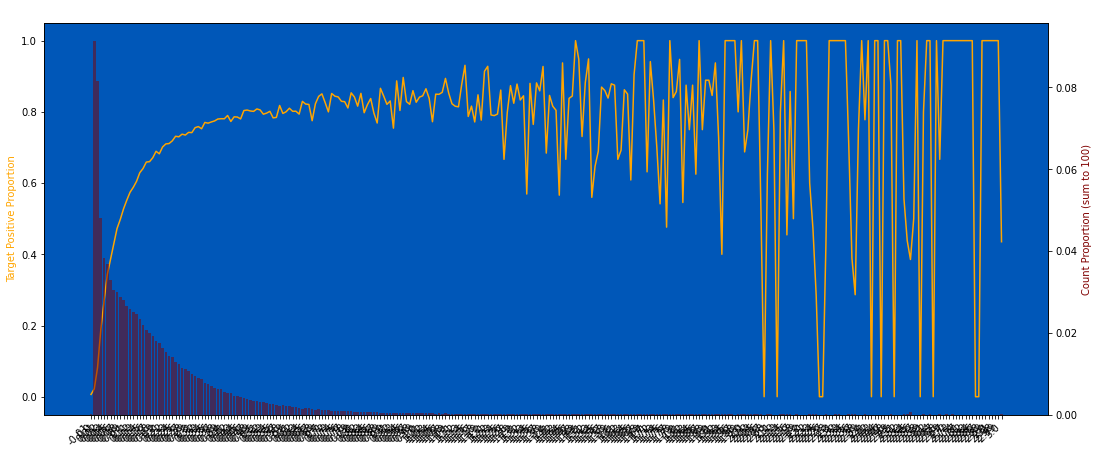

In [40]:
plot_target_check(train, "D_42", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0332, Train-Private PSI: 0.0439
Bottom 1% and Top 1% are dropped from this chart


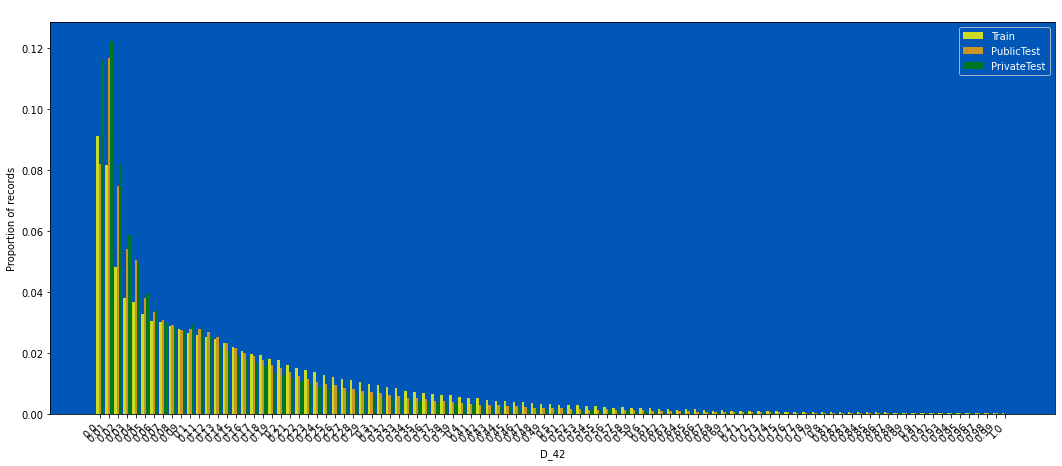

In [41]:
plot_train_test_distribution(df_list, "D_42", nunique_thr=1000)

In [167]:
describe_all(df_list, "D_42").loc["null_proportion"]

train          0.8569
public test    0.8749
private test   0.8862
Name: null_proportion, dtype: float64

### D_43 (Done)

In [42]:
# plot_target_check(train, "D_43", q=50, use_raw_bin=True)

In [43]:
%%time
df_list = round_dfs(df_list, col="D_43", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0965
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0962
CPU times: user 5.29 s, sys: 5.72 s, total: 11 s
Wall time: 16.5 s


In [44]:
for df in df_list:
    df = clip_col(df, "D_43", top_value=3, add_new_col=False)

In [45]:
print_percentile(df_list, "D_43", 99.99)

99.99th percentile:
train : 3.0
public test : 3.0
private test : 3.0


1658396 null count, 0.300 null proportion
0.1673 of the targets have label = 1


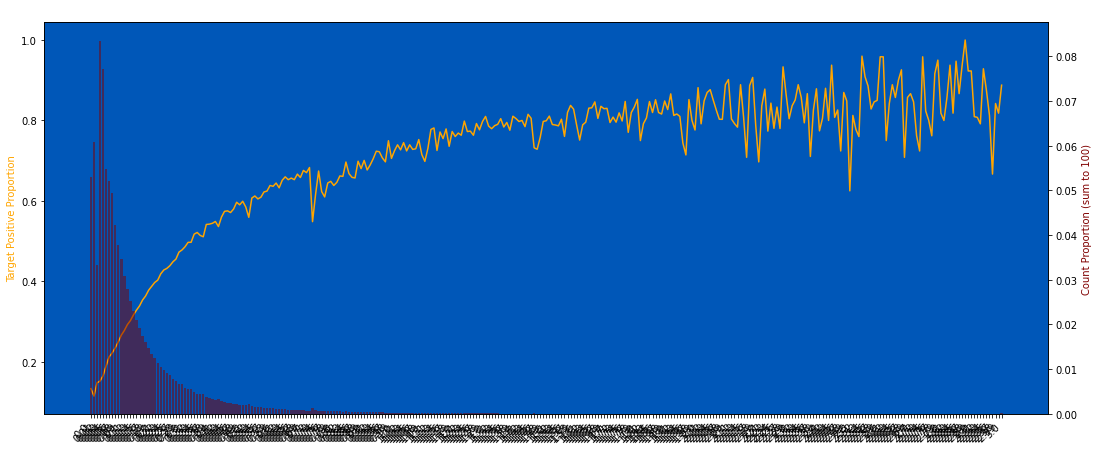

In [46]:
plot_target_check(train, "D_43", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0030, Train-Private PSI: 0.0033
Bottom 1% and Top 1% are dropped from this chart


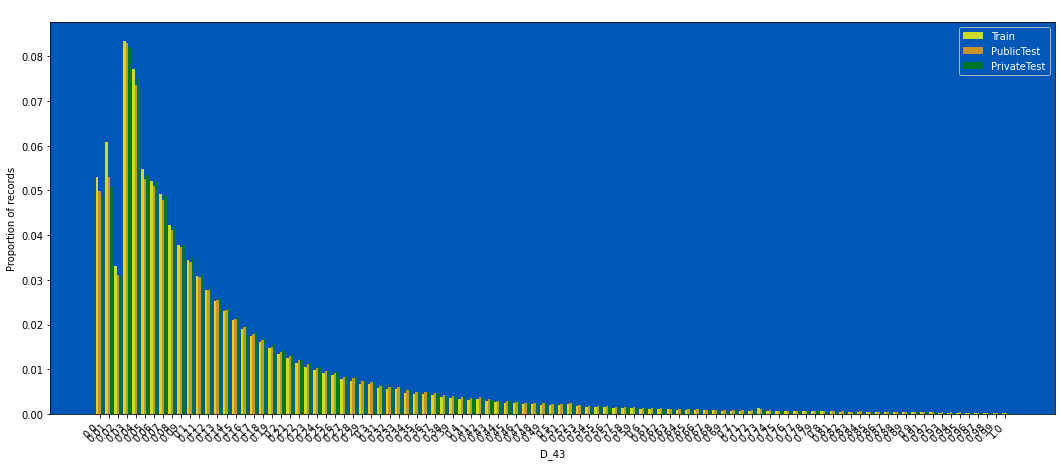

In [47]:
plot_train_test_distribution(df_list, "D_43", nunique_thr=1000)

In [168]:
describe_all(df_list, "D_43").loc["null_proportion"]

train          0.2998
public test    0.2997
private test   0.3009
Name: null_proportion, dtype: float64

### D_44 (Done)

In [48]:
# plot_target_check(train, "D_44", q=50, use_raw_bin=True, nunique_thr=1000)

In [49]:
%%time
df_list = round_dfs(df_list, col="D_44", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0117
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0079
CPU times: user 5.43 s, sys: 6.29 s, total: 11.7 s
Wall time: 18.2 s


In [50]:
print_percentile(df_list, "D_44", 99.99)

99.99th percentile:
train : 2.38
public test : 2.5
private test : 2.5


In [51]:
%%time
for df in df_list:
    df["D_44"] = (df["D_44"] * 8).round(0)

CPU times: user 108 ms, sys: 62.8 ms, total: 171 ms
Wall time: 168 ms


In [52]:
for df in df_list:
    df = clip_col(df, "D_44", top_value=20, add_new_col=False)

274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1


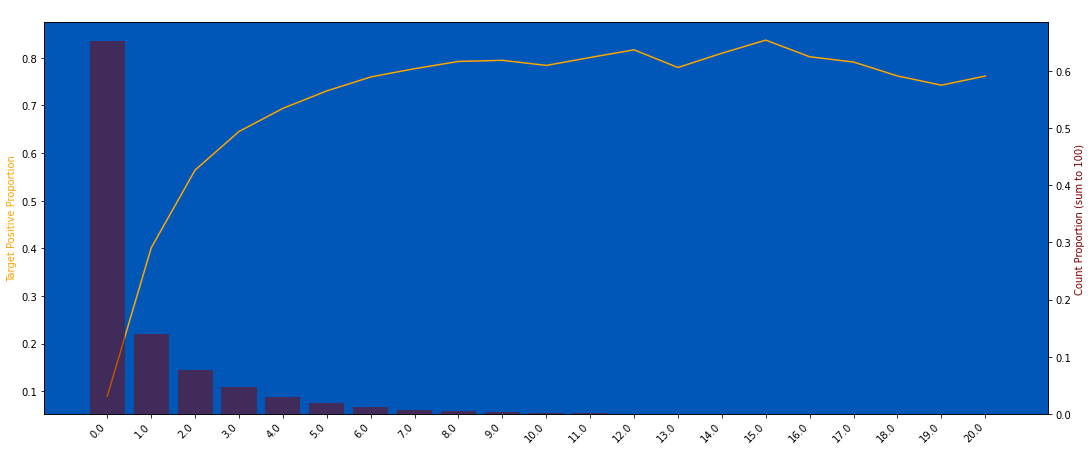

In [53]:
plot_target_check(train, "D_44", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0003, Train-Private PSI: 0.0011


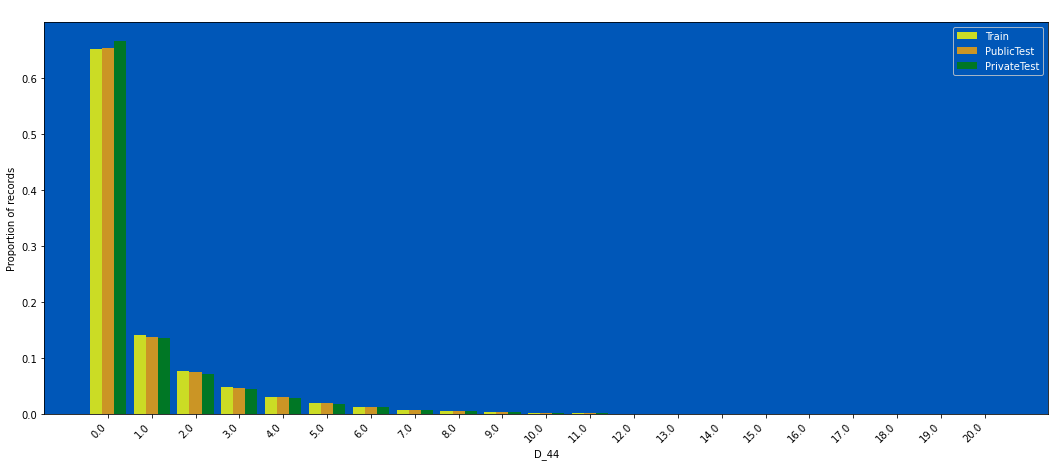

In [54]:
plot_train_test_distribution(df_list, "D_44", nunique_thr=1000, without_drop_tail=True)

In [169]:
describe_all(df_list, "D_44").loc["null_proportion"]

train          0.0496
public test    0.0473
private test   0.0475
Name: null_proportion, dtype: float64

### D_45 (KIV) Should we drop this?

In [55]:
# plot_target_check(train, "D_45", q=50, use_raw_bin=True)

In [56]:
%%time
df_list = round_dfs(df_list, col="D_45", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1170
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1131
CPU times: user 5.52 s, sys: 6.85 s, total: 12.4 s
Wall time: 19.2 s


In [57]:
print_percentile(df_list, "D_45", 99.99)

99.99th percentile:
train : 1.51
public test : 1.52
private test : 1.5


In [58]:
for df in df_list:
    df = clip_col(df, "D_45", top_value=1.5, add_new_col=False)

2017 null count, 0.000 null proportion
0.3560 of the targets have label = 1


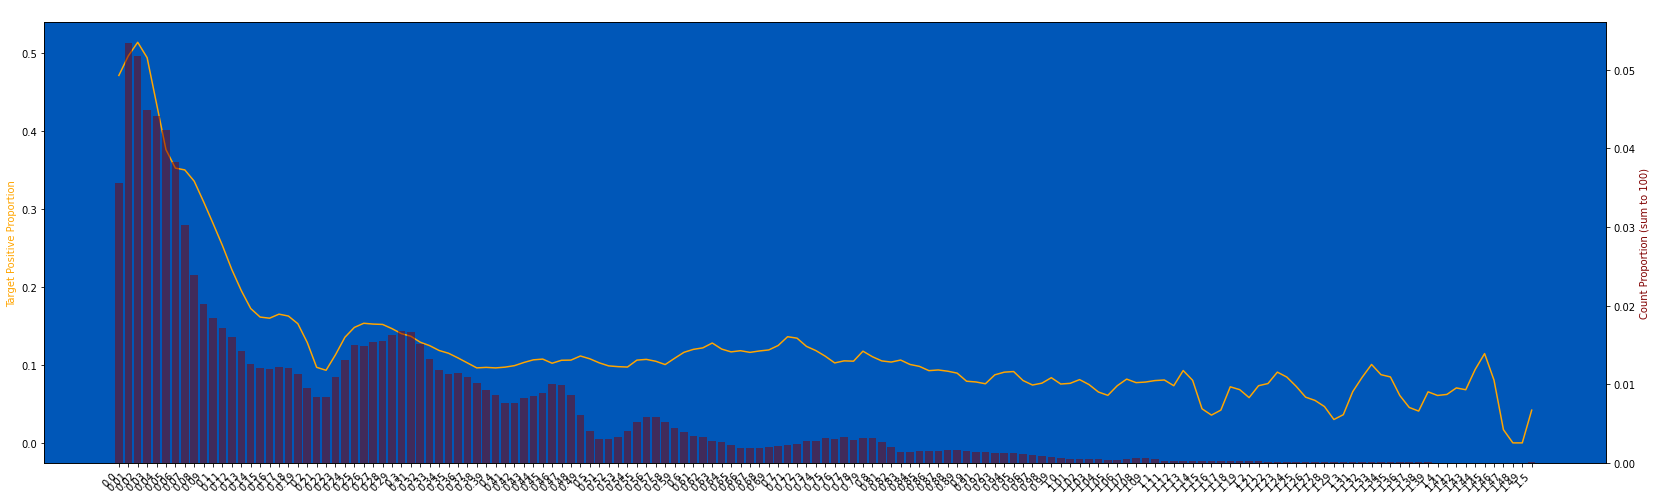

In [59]:
plot_target_check(train, "D_45", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True, figsize=(28, 9))

Train-Public PSI: 0.0748, Train-Private PSI: 0.1131


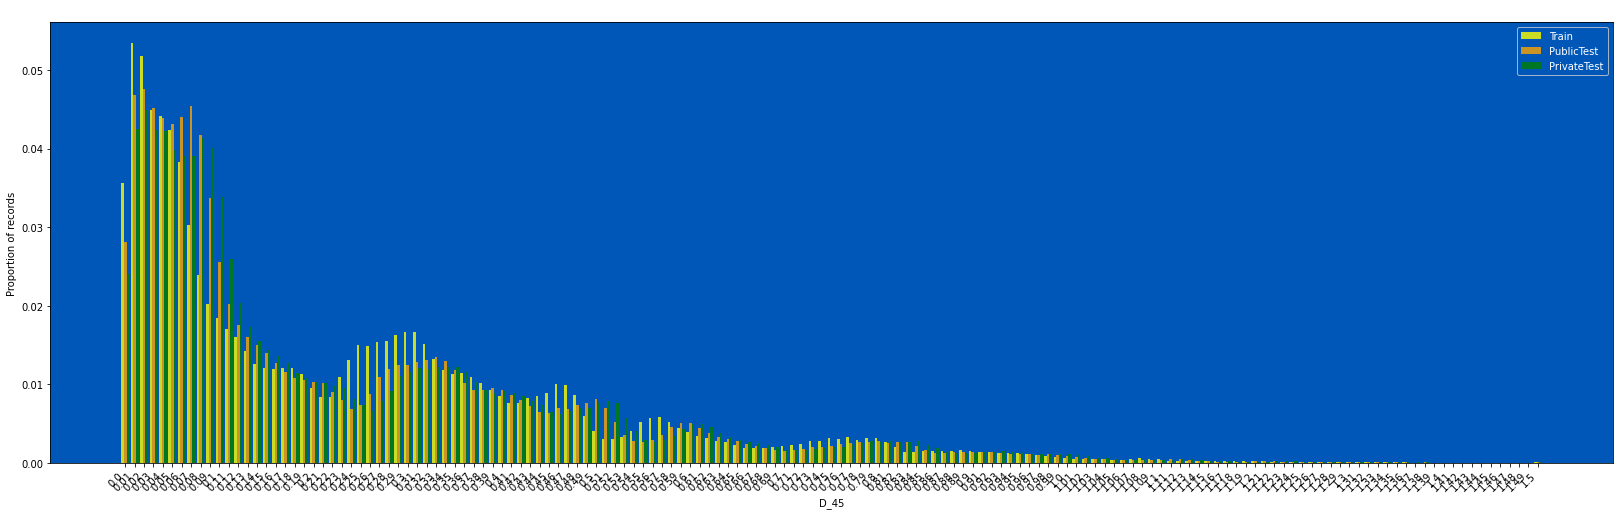

In [60]:
plot_train_test_distribution(df_list, "D_45", nunique_thr=8000, without_drop_tail=True, figsize=(28, 9))

In [170]:
describe_all(df_list, "D_45").loc["null_proportion"]

train          0.0004
public test    0.0003
private test   0.0002
Name: null_proportion, dtype: float64

### D_46 (KIV) Similar pattern with P_3, can try to feature cross them.

In [61]:
# plot_target_check(train, "D_46", q=50, use_raw_bin=True)

In [62]:
%%time
df_list = round_dfs(df_list, col="D_46", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0650
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0618
CPU times: user 5.13 s, sys: 4.6 s, total: 9.73 s
Wall time: 13.9 s


1211699 null count, 0.219 null proportion
0.1940 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


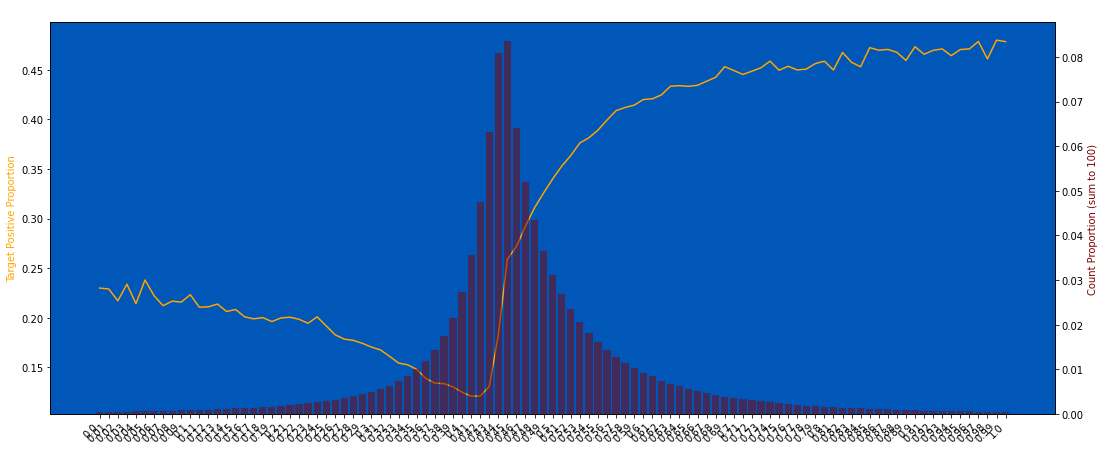

In [63]:
d46_summary = plot_target_check(train, "D_46", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, return_df=True)

Train-Public PSI: 0.0535, Train-Private PSI: 0.0618
Bottom 1% and Top 1% are dropped from this chart


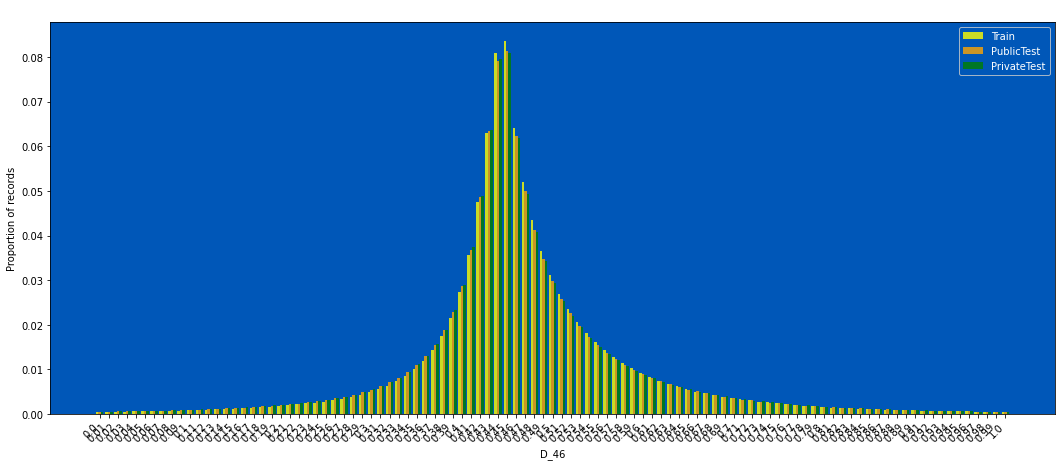

In [64]:
plot_train_test_distribution(df_list, "D_46", nunique_thr=8000)

In [171]:
describe_all(df_list, "D_46").loc["null_proportion"]

train          0.2191
public test    0.2032
private test   0.2011
Name: null_proportion, dtype: float64

### D_47 (Done)

In [65]:
# plot_target_check(train, "D_47", q=50, use_raw_bin=True)

In [66]:
%%time
df_list = round_dfs(df_list, col="D_47", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0537
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0276
CPU times: user 5.04 s, sys: 4.59 s, total: 9.63 s
Wall time: 13.5 s


In [67]:
describe_all(df_list, "D_47")

train    public test   private test
count           5,531,451.0000 5,719,469.0000 5,644,293.0000
mean                    0.4021         0.3912         0.3913
std                     0.2348         0.2328         0.2326
min                    -0.0300        -0.0300        -0.0300
25%                     0.2300         0.2200         0.2200
50%                     0.3800         0.3600         0.3600
75%                     0.5600         0.5400         0.5400
max                     1.6400         1.4800         1.5100
null_proportion         0.0000         0.0000         0.0000

In [68]:
print_percentile(df_list, "D_47", 99.975)

99.975th percentile:
train : 1.25
public test : 1.24
private test : 1.24


In [69]:
for df in df_list:
    df = clip_col(df, "D_47", top_value=1.24, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


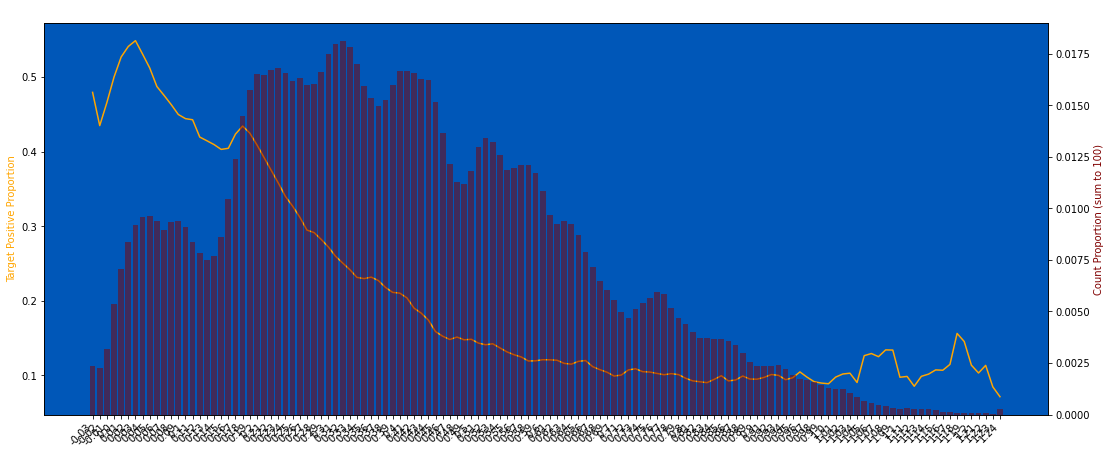

In [70]:
plot_target_check(train, "D_47", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0144, Train-Private PSI: 0.0232


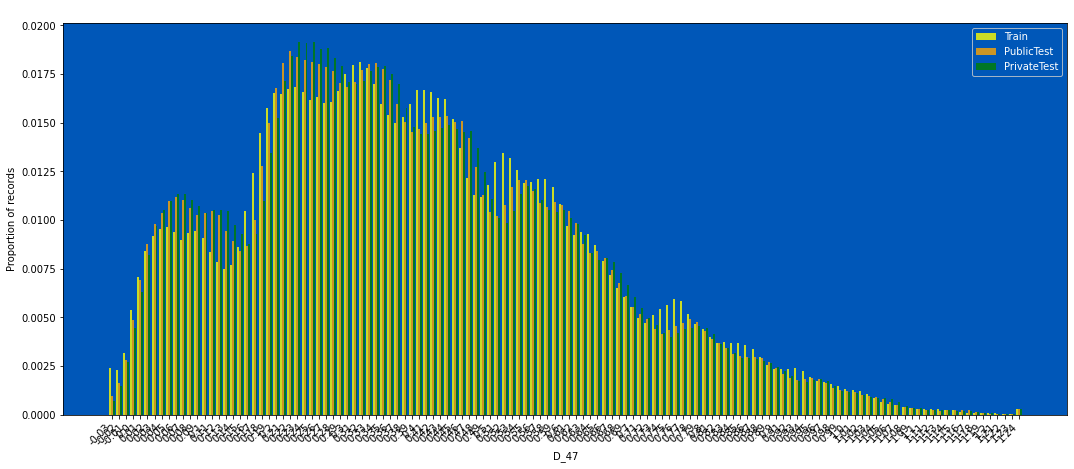

In [71]:
plot_train_test_distribution(df_list, "D_47", nunique_thr=8000, without_drop_tail=True)

In [172]:
describe_all(df_list, "D_47").loc["null_proportion"]

train          0.0000
public test    0.0000
private test   0.0000
Name: null_proportion, dtype: float64

### D_48 (Done)

In [72]:
# plot_target_check(train, "D_48", q=50, use_raw_bin=True)

In [73]:
%%time
df_list = round_dfs(df_list, col="D_48", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0693
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0656
CPU times: user 5.29 s, sys: 5.3 s, total: 10.6 s
Wall time: 16 s


In [74]:
describe_all(df_list, "D_48")

train    public test   private test
count           4,812,726.0000 4,997,589.0000 4,919,037.0000
mean                    0.3766         0.3762         0.3666
std                     0.3265         0.3285         0.3263
min                    -0.0100        -0.0100        -0.0100
25%                     0.0800         0.0800         0.0700
50%                     0.2800         0.2800         0.2600
75%                     0.6600         0.6700         0.6500
max                     8.9700         7.5400         6.7900
null_proportion         0.1299         0.1262         0.1285

In [75]:
print_percentile(df_list, "D_48", 99.95)

99.95th percentile:
train : 1.39
public test : 1.41
private test : 1.36


In [76]:
for df in df_list:
    df = clip_col(df, "D_48", top_value=1.4, add_new_col=False)

718725 null count, 0.130 null proportion
0.1221 of the targets have label = 1


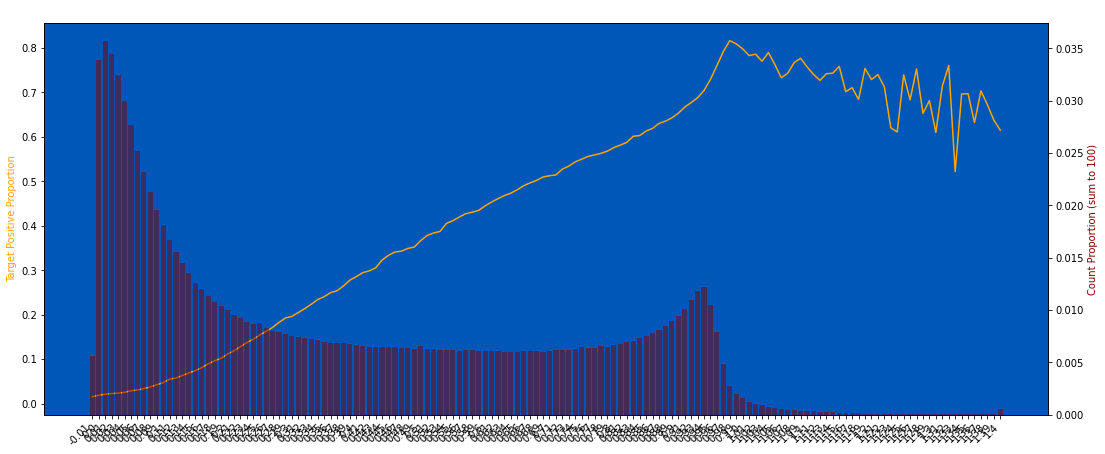

In [77]:
plot_target_check(train, "D_48", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0006, Train-Private PSI: 0.0020


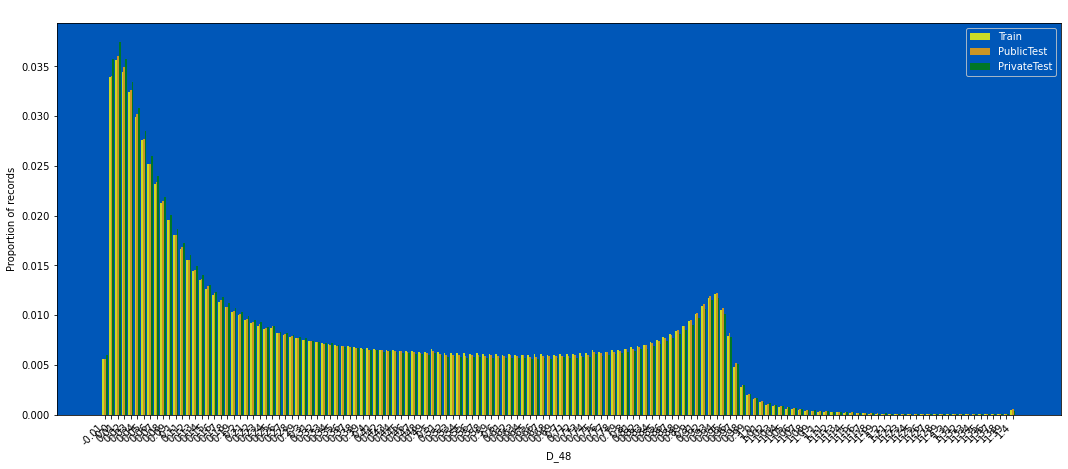

In [90]:
plot_train_test_distribution(df_list, "D_48", nunique_thr=8000, without_drop_tail=True)

In [173]:
describe_all(df_list, "D_48").loc["null_proportion"]

train          0.1299
public test    0.1262
private test   0.1285
Name: null_proportion, dtype: float64

### D_49 (Done)

In [79]:
# plot_target_check(train, "D_49", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [80]:
%%time
df_list = round_dfs(df_list, col="D_49", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0423
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0430
CPU times: user 4.07 s, sys: 4.35 s, total: 8.42 s
Wall time: 13.1 s


In [81]:
print_percentile(df_list, "D_49", 99.5)

99.5th percentile:
train : 1.24
public test : 1.28
private test : 1.27


In [82]:
for df in df_list:
    df = clip_col(df, "D_49", top_value=1.5, add_new_col=False)

In [83]:
for df in tqdm(df_list): 
    df["D_49"] = df["D_49"].parallel_apply(lambda x: manual_stack(x, start=0, stack_interval=0.03, denom=100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s]


4985917 null count, 0.901 null proportion
0.2162 of the targets have label = 1


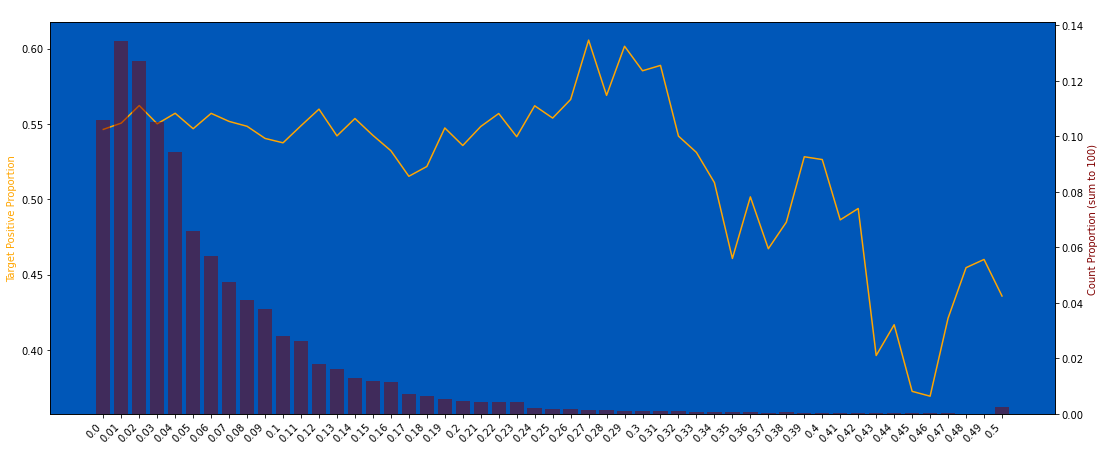

In [84]:
plot_target_check(train, "D_49", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0038, Train-Private PSI: 0.0056
Bottom 1% and Top 1% are dropped from this chart


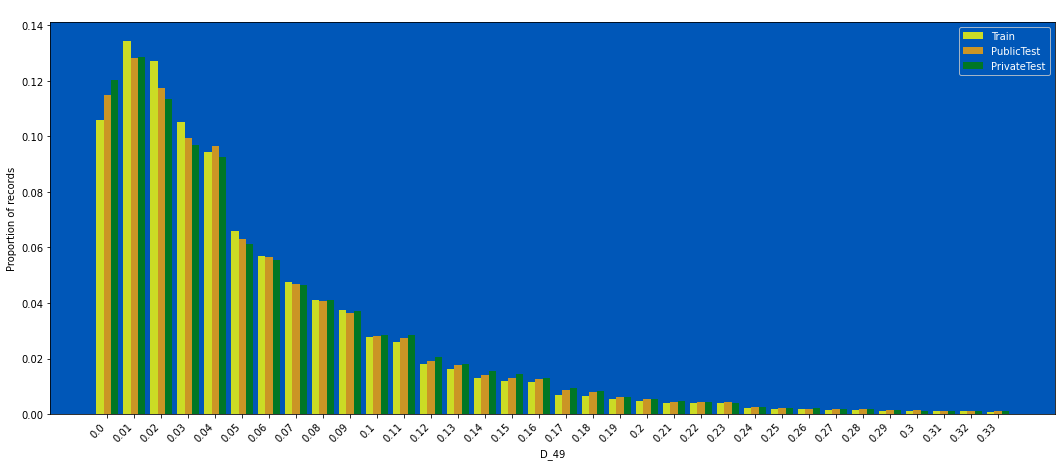

In [85]:
plot_train_test_distribution(df_list, "D_49", nunique_thr=1000)

In [174]:
describe_all(df_list, "D_49").loc["null_proportion"]

train          0.9014
public test    0.8824
private test   0.8787
Name: null_proportion, dtype: float64

### D_50 (Done)

In [86]:
# plot_target_check(train, "D_50", q=50, use_raw_bin=True)

In [87]:
%%time
df_list = round_dfs(df_list, col="D_50", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0466
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0460
CPU times: user 4.53 s, sys: 4.88 s, total: 9.42 s
Wall time: 14.4 s


In [92]:
describe_all(df_list, "D_50")

train    public test   private test
count           2,389,049.0000 2,448,088.0000 2,432,928.0000
mean                    0.1694         0.1784         0.1833
std                     0.6338         0.7785         0.7363
min                  -306.4900      -207.4500       -18.4800
25%                     0.0600         0.0600         0.0600
50%                     0.1000         0.1100         0.1100
75%                     0.1800         0.1900         0.1900
max                   244.0400       354.5300       265.2700
null_proportion         0.5681         0.5720         0.5690

In [109]:
print_percentile(df_list, "D_50", 99.9)

99.9th percentile:
train : 5.02
public test : 5.979130000001751
private test : 6.03


In [110]:
for df in df_list:
    df = clip_col(df, "D_50", btm_value=-0.5, add_new_col=False)
    df = clip_col(df, "D_50", top_value=5, add_new_col=False)

3142402 null count, 0.568 null proportion
0.3005 of the targets have label = 1


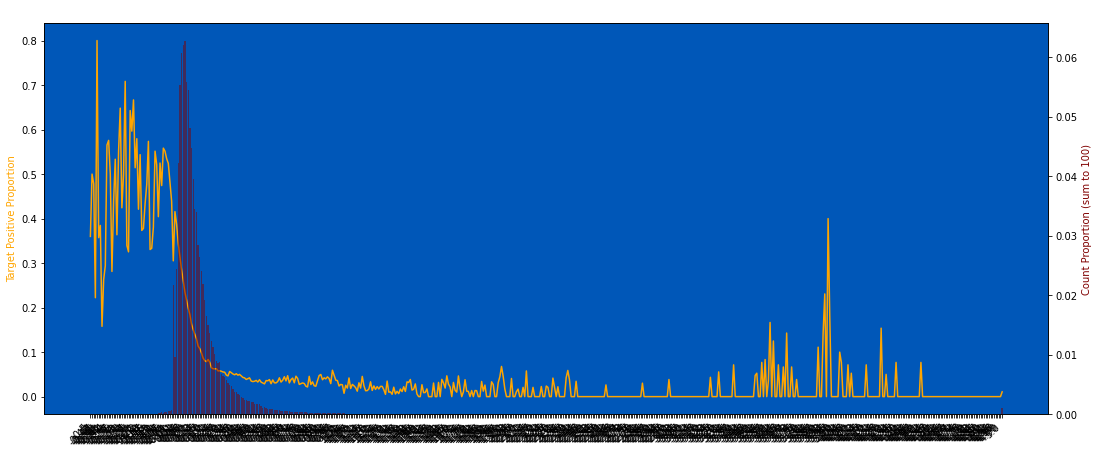

In [111]:
plot_target_check(train, "D_50", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0015, Train-Private PSI: 0.0030


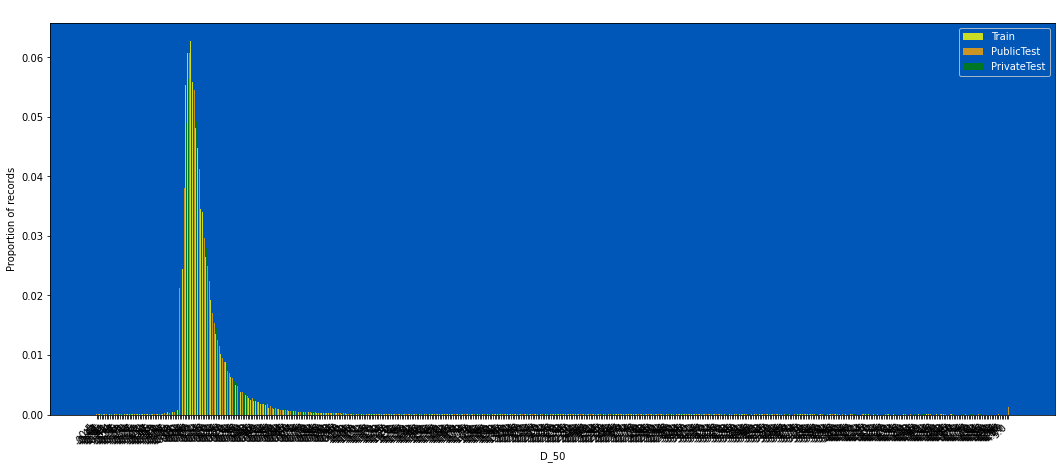

In [126]:
plot_train_test_distribution(df_list, "D_50", nunique_thr=10000, without_drop_tail=True)

In [175]:
describe_all(df_list, "D_50").loc["null_proportion"]

train          0.5681
public test    0.5720
private test   0.5690
Name: null_proportion, dtype: float64

### D_51 (Done)

In [113]:
# plot_target_check(train, "D_51", q=50, use_raw_bin=True, nunique_thr=10000)

In [114]:
%%time
df_list = round_dfs(df_list, col="D_51", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0078
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0068
CPU times: user 5.11 s, sys: 6.21 s, total: 11.3 s
Wall time: 17.9 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


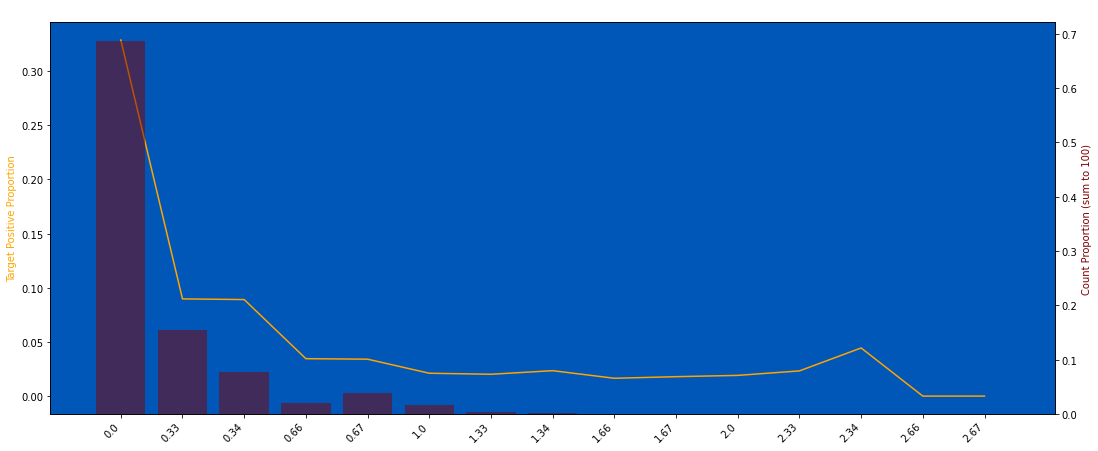

In [115]:
plot_target_check(train, "D_51", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [118]:
for df in df_list:
    df["D_51"] = (df["D_51"] * 3).round(0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


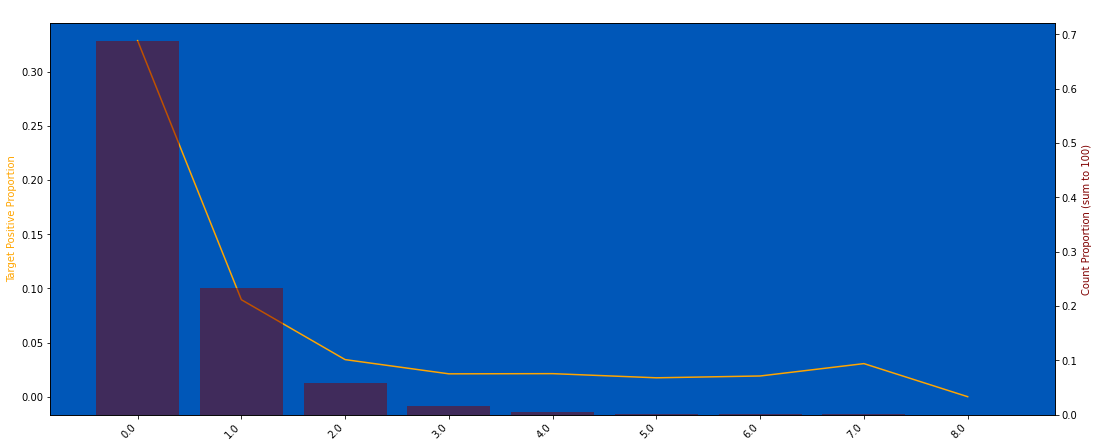

In [119]:
plot_target_check(train, "D_51", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0019, Train-Private PSI: 0.0068


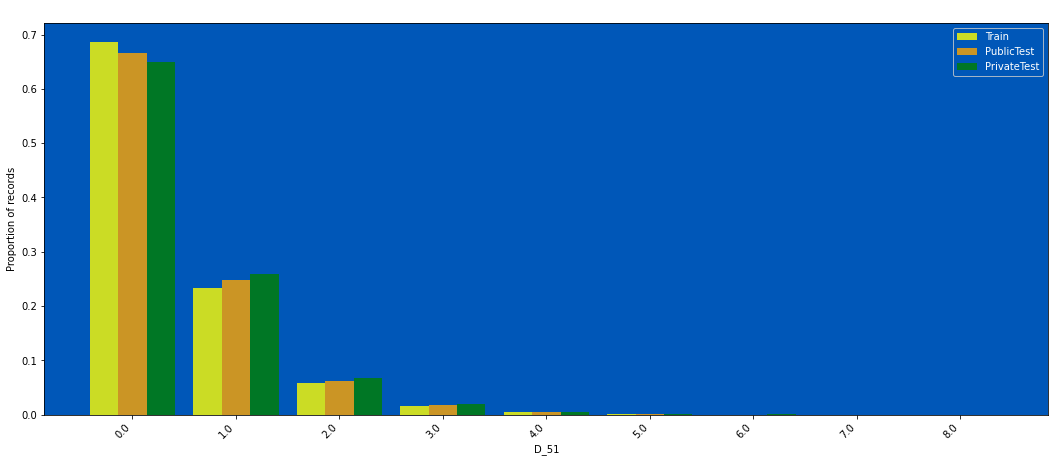

In [120]:
plot_train_test_distribution(df_list, "D_51", nunique_thr=1000, without_drop_tail=True)

In [176]:
describe_all(df_list, "D_51").loc["null_proportion"]

train          0.0000
public test    0.0000
private test   0.0000
Name: null_proportion, dtype: float64

### D_52 (KIV) Train Test Null Proportion differ

In [121]:
# plot_target_check(train, "D_52", q=50, use_raw_bin=True)

In [122]:
%%time
df_list = round_dfs(df_list, col="D_52", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0087
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0063
CPU times: user 5.08 s, sys: 5.8 s, total: 10.9 s
Wall time: 16.7 s


29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


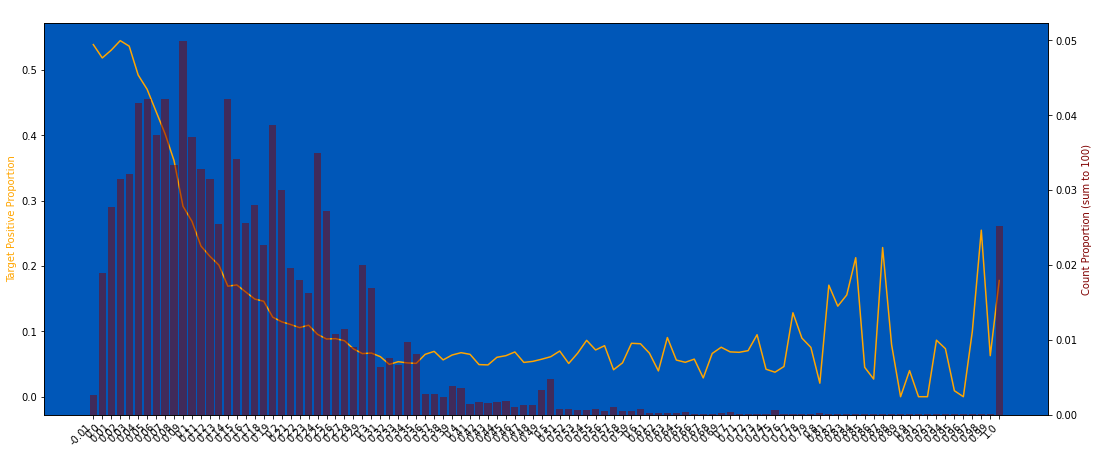

In [123]:
plot_target_check(train, "D_52", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0018, Train-Private PSI: 0.0063


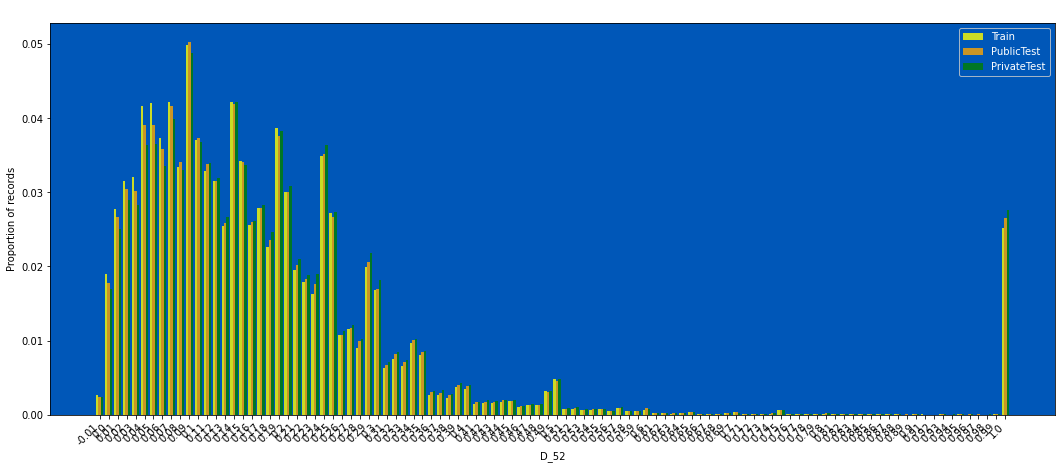

In [124]:
plot_train_test_distribution(df_list, "D_52", nunique_thr=1000, without_drop_tail=True)

In [177]:
describe_all(df_list, "D_52").loc["null_proportion"]

train          0.0053
public test    0.0029
private test   0.0025
Name: null_proportion, dtype: float64

- Null proportion is higher in training data, are some of the test data get imputed?

### D_53

In [127]:
# plot_target_check(train, "D_53", q=50, use_raw_bin=True)

In [128]:
%%time
df_list = round_dfs(df_list, col="D_53", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0794
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0624
CPU times: user 4.12 s, sys: 5.04 s, total: 9.15 s
Wall time: 14.6 s


4084585 null count, 0.738 null proportion
0.1836 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


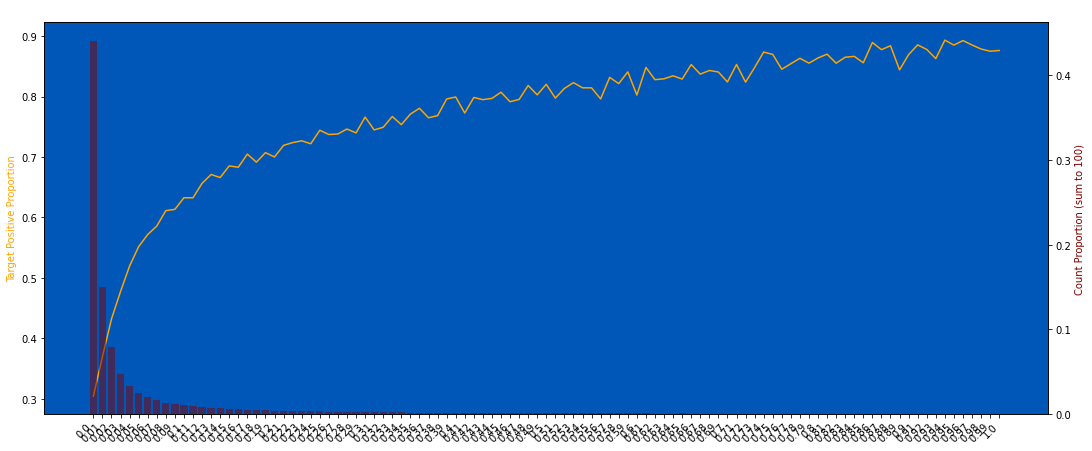

In [129]:
plot_target_check(train, "D_53", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Train-Public PSI: 0.0664, Train-Private PSI: 0.0624
Bottom 1% and Top 1% are dropped from this chart


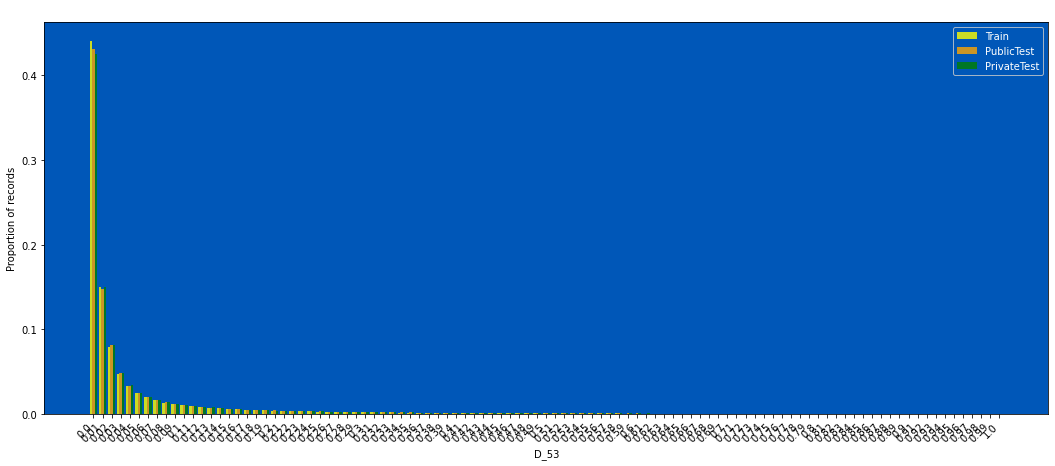

In [130]:
plot_train_test_distribution(df_list, "D_53", nunique_thr=1000)

In [189]:
describe_all(df_list, "D_53").loc["null_proportion"]

train          0.7384
public test    0.7365
private test   0.7382
Name: null_proportion, dtype: float64

### D_54

In [131]:
# plot_target_check(train, "D_54", q=100, use_raw_bin=True)

In [132]:
for df in df_list:
    df["D_54"] = df["D_54"].round(0)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


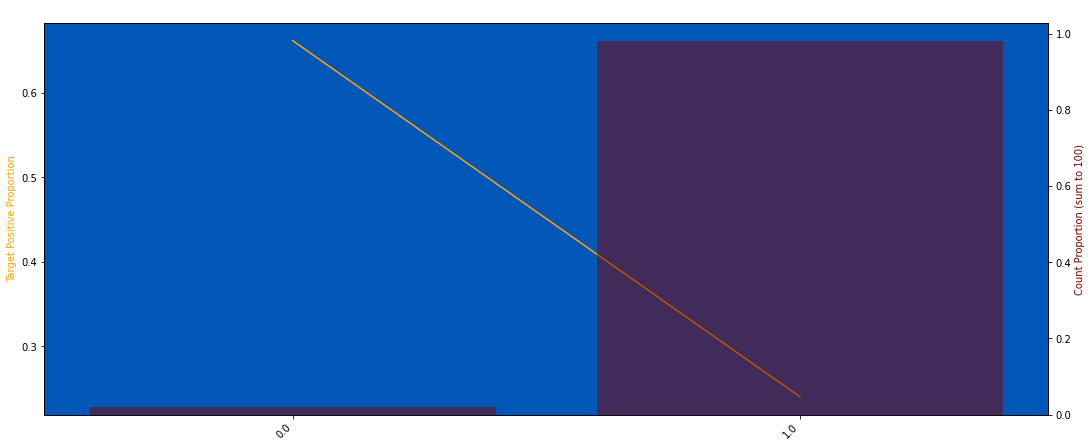

In [133]:
plot_target_check(train, "D_54", q=100, use_raw_bin=True, nunique_thr=4000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0001, Train-Private PSI: 0.0000


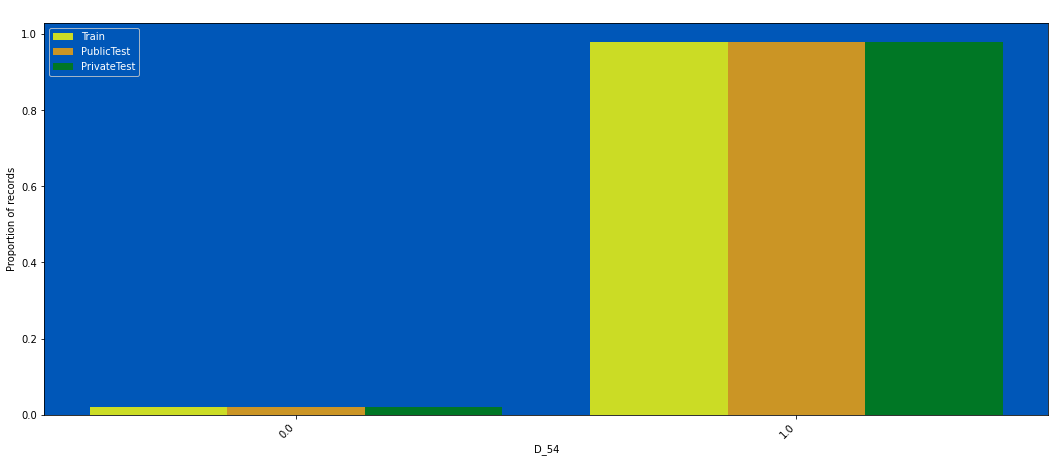

In [134]:
plot_train_test_distribution(df_list, "D_54", without_drop_tail=True)

In [190]:
describe_all(df_list, "D_54").loc["null_proportion"]

train          0.0004
public test    0.0003
private test   0.0002
Name: null_proportion, dtype: float64

### D_55

In [136]:
# plot_target_check(train, "D_55", q=50, use_raw_bin=True)

In [137]:
%%time
df_list = round_dfs(df_list, col="D_55", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1073
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0553
CPU times: user 5.17 s, sys: 5.22 s, total: 10.4 s
Wall time: 16.5 s


184803 null count, 0.033 null proportion
0.1759 of the targets have label = 1


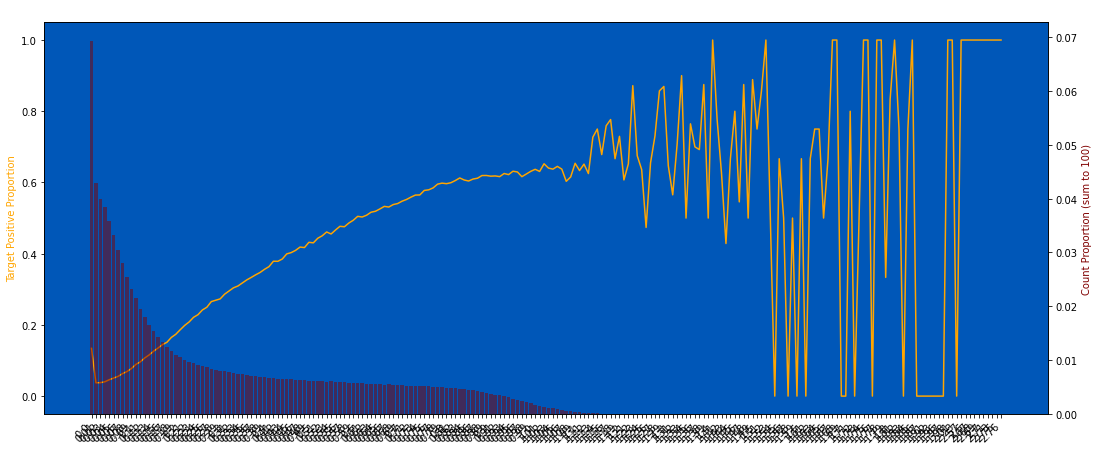

In [140]:
plot_target_check(train, "D_55", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [191]:
print_percentile(df_list, "D_55", 99.9)

99.9th percentile:
train : 1.11
public test : 1.11
private test : 1.11


In [147]:
for df in df_list:
    df = clip_col(df, "D_55", top_value=1.15, add_new_col=False)

In [158]:
describe_all(df_list, "D_55")["null_proportion"]

train    public test   private test
count           5,346,648.0000 5,347,464.0000 5,273,325.0000
mean                    0.2931         0.3113         0.3072
std                     0.2886         0.2925         0.2927
min                     0.0000         0.0000         0.0000
25%                     0.0500         0.0600         0.0600
50%                     0.1800         0.2000         0.1900
75%                     0.5000         0.5300         0.5200
max                     1.1500         1.1500         1.1500
null_proportion         0.0334         0.0650         0.0657

- Null proportion is less in training data, suspect is kena fillna by 0

In [161]:
c = check_summary(train, "D_55")
cids = c.loc[c["max"] == 0].customer_ID.tolist()

In [162]:
for df in tqdm(df_list):
    df.loc[(df["customer_ID"].isin(cids)) & (df["D_55"] == 0), "D_55"] = np.nan

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.99it/s]


Train-Public PSI: 0.0022, Train-Private PSI: 0.0019
Bottom 1% and Top 1% are dropped from this chart


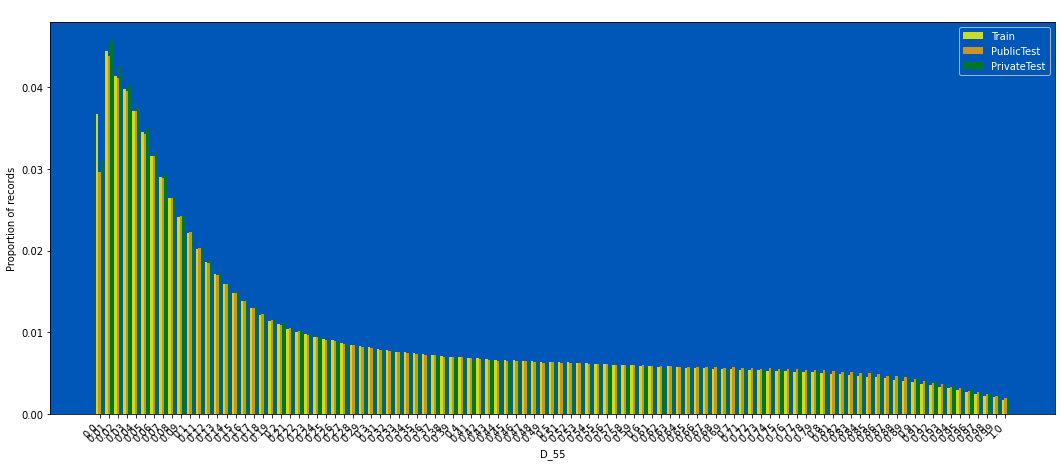

In [163]:
plot_train_test_distribution(df_list, "D_55", nunique_thr=1000)

In [164]:
describe_all(df_list, "D_55").loc["null_proportion"]

train          0.0662
public test    0.0650
private test   0.0657
Name: null_proportion, dtype: float64

- Now looks better

### D_56 (KIV) Null Proportion Differ in Train Test

In [192]:
# plot_target_check(train, "D_56", q=50, use_raw_bin=True)

In [193]:
%%time
df_list = round_dfs(df_list, col="D_56", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1125
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1115
CPU times: user 4.66 s, sys: 6.56 s, total: 11.2 s
Wall time: 18.1 s


2990943 null count, 0.541 null proportion
0.3282 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


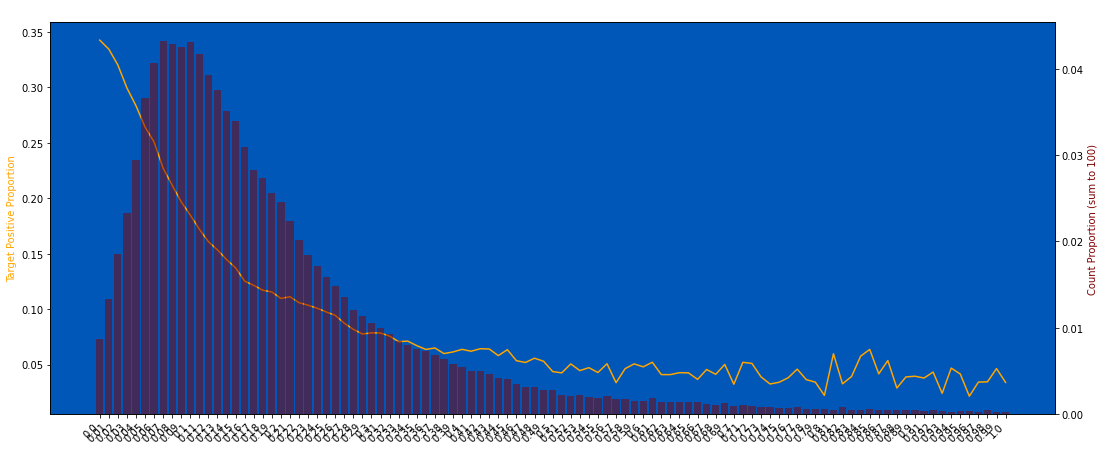

In [194]:
plot_target_check(train, "D_56", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Train-Public PSI: 0.0925, Train-Private PSI: 0.1115
Bottom 1% and Top 1% are dropped from this chart


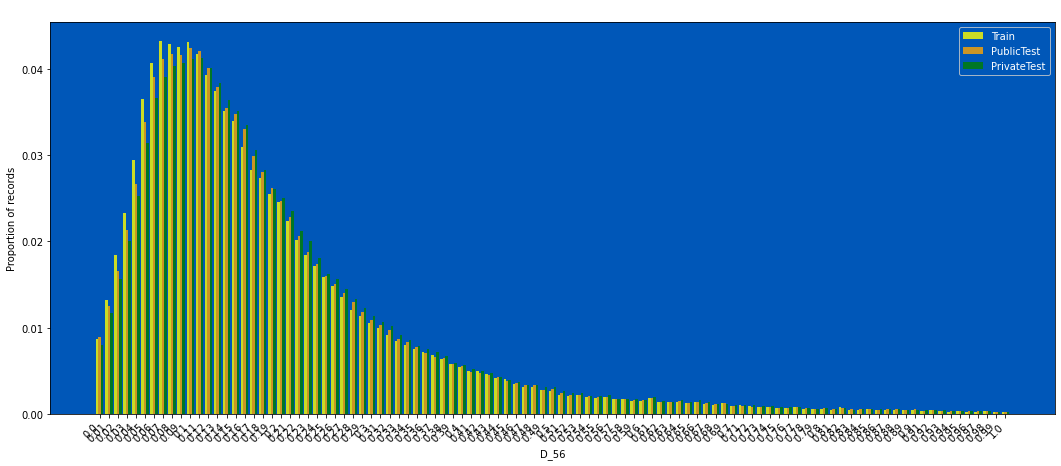

In [195]:
plot_train_test_distribution(df_list, "D_56", nunique_thr=1000)

In [198]:
describe_all(df_list, "D_56")

train    public test   private test
count           2,540,508.0000 2,814,903.0000 2,836,151.0000
mean                    0.1987         0.2030         0.2081
std                     0.2122         0.2130         0.2166
min                    -0.0200        -0.0200        -0.0200
25%                     0.0800         0.0900         0.0900
50%                     0.1400         0.1500         0.1500
75%                     0.2400         0.2500         0.2600
max                    10.9500        10.4700        10.6000
null_proportion         0.5407         0.5078         0.4975

**Train Test Drift**
- Heavy

### D_58

0 null count, 0.000 null proportion
nan of the targets have label = 1


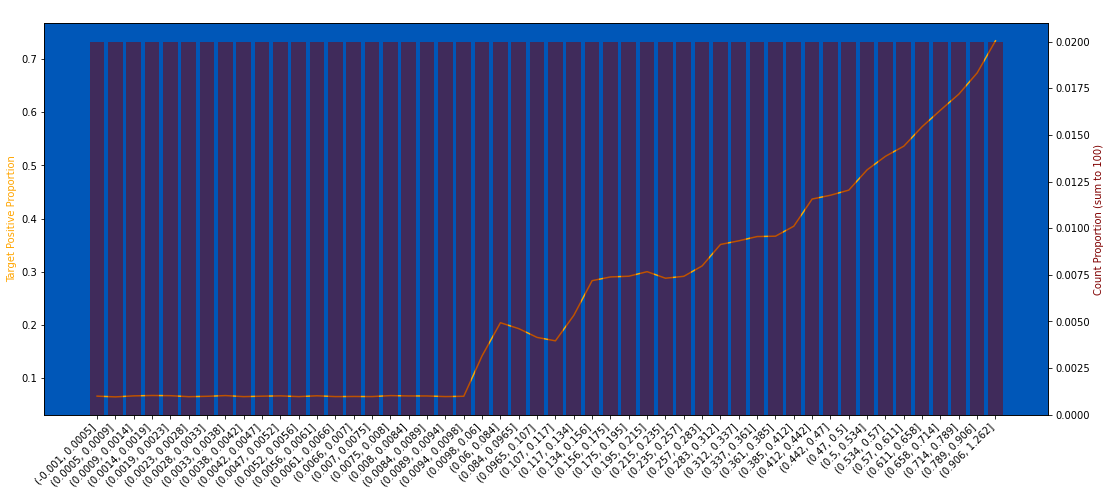

In [199]:
plot_target_check(train, "D_58", q=50, use_raw_bin=True)

In [200]:
%%time
df_list = round_dfs(df_list, col="D_58", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0013
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0010
CPU times: user 5.09 s, sys: 5.66 s, total: 10.7 s
Wall time: 17.3 s


In [208]:
for df in df_list:
    df["D_58"] = df["D_58"].replace(0, np.nan)

In [209]:
describe_all(df_list, "D_58")

train    public test   private test
count           3,168,715.0000 3,274,072.0000 3,167,136.0000
mean                    0.3675         0.3706         0.3679
std                     0.2464         0.2472         0.2460
min                     0.0100         0.0100         0.0100
25%                     0.1600         0.1600         0.1600
50%                     0.3200         0.3300         0.3300
75%                     0.5200         0.5300         0.5200
max                     1.2600         1.2600         1.2600
null_proportion         0.4271         0.4276         0.4389

2362736 null count, 0.427 null proportion
0.0654 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


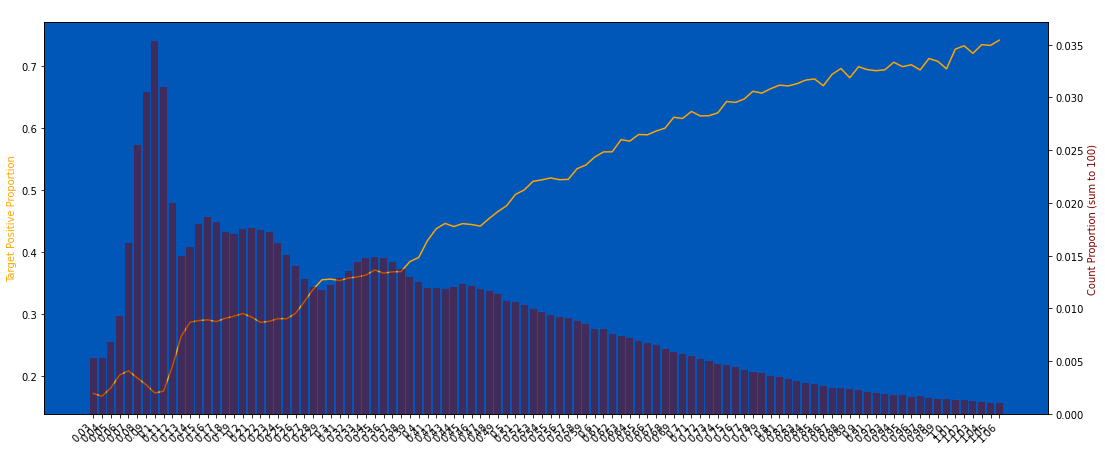

In [210]:
plot_target_check(train, "D_58", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Train-Public PSI: 0.0004, Train-Private PSI: 0.0006
Bottom 1% and Top 1% are dropped from this chart


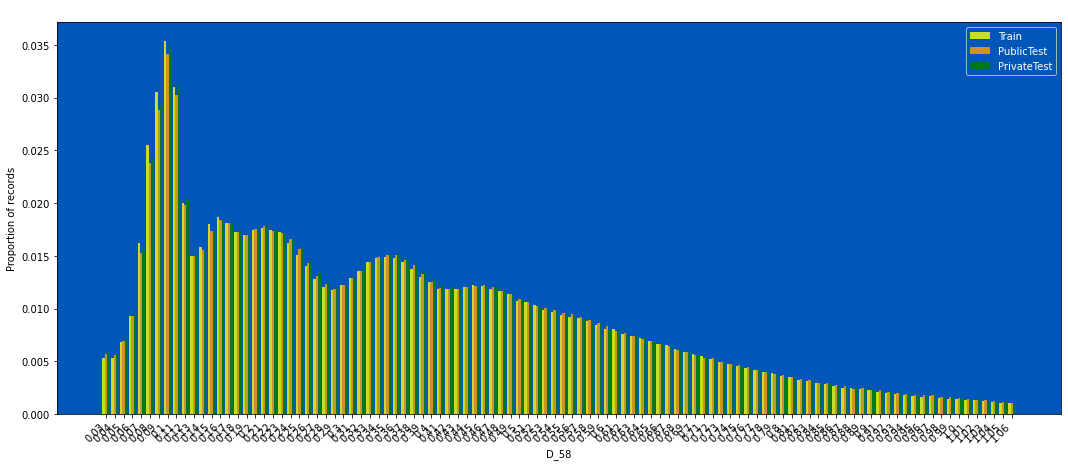

In [211]:
plot_train_test_distribution(df_list, "D_58", nunique_thr=1000)

### D_59

In [212]:
# plot_target_check(train, "D_59", q=50, use_raw_bin=True, nunique_thr=1000)

In [204]:
%%time
df_list = round_dfs(df_list, col="D_59", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 1.7349
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 1.7208
CPU times: user 4.79 s, sys: 4.22 s, total: 9.01 s
Wall time: 13.4 s


106725 null count, 0.019 null proportion
0.4218 of the targets have label = 1


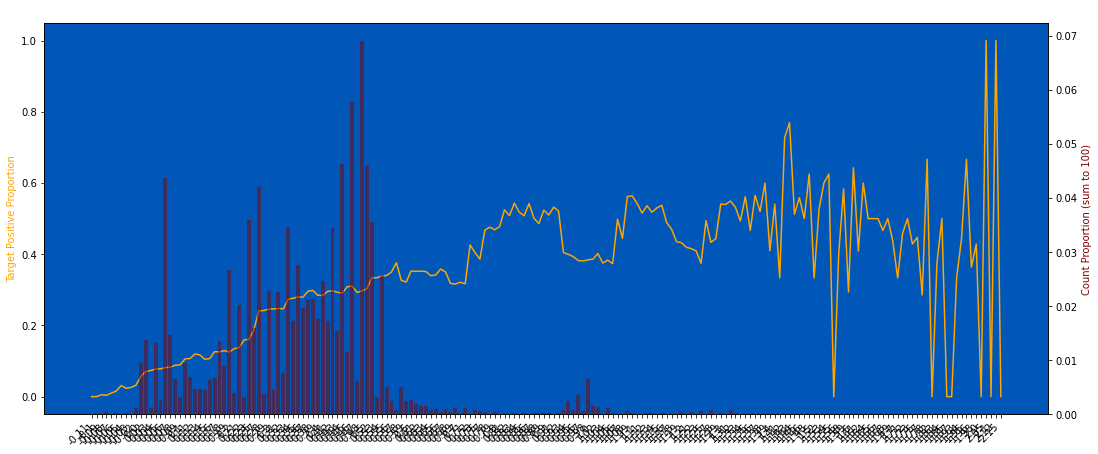

In [205]:
plot_target_check(train, "D_59", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 1.4976, Train-Private PSI: 1.7208


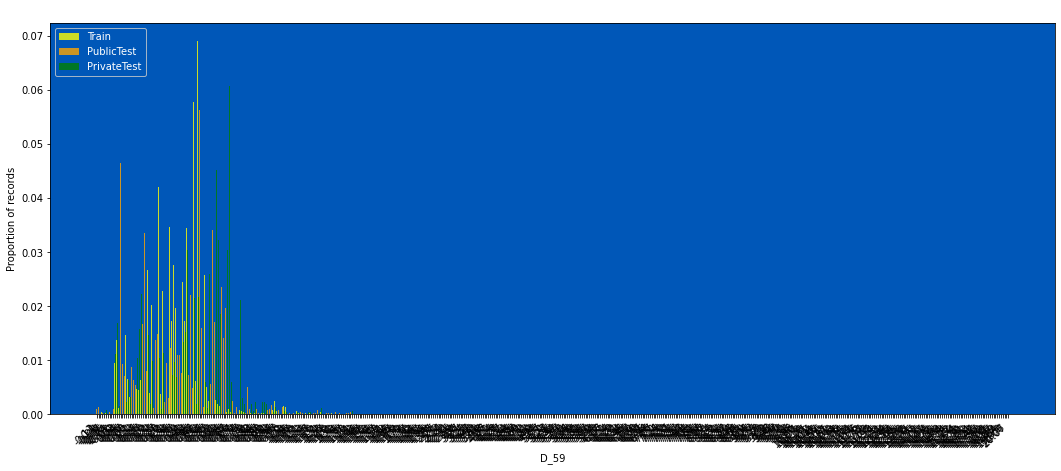

In [206]:
plot_train_test_distribution(df_list, "D_59", nunique_thr=1000, without_drop_tail=True)

**Train Test Drift: Extremely Heavy**

In [213]:
%%time
for df in df_list:
    df = df.drop(columns="D_59", errors="ignore")

CPU times: user 9.75 s, sys: 18 s, total: 27.8 s
Wall time: 38.2 s


### D_60

In [226]:
# plot_target_check(train, "D_60", q=50, use_raw_bin=True)

In [215]:
%%time
df_list = round_dfs(df_list, col="D_60", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0052
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0049
CPU times: user 5.46 s, sys: 5.89 s, total: 11.4 s
Wall time: 14.9 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


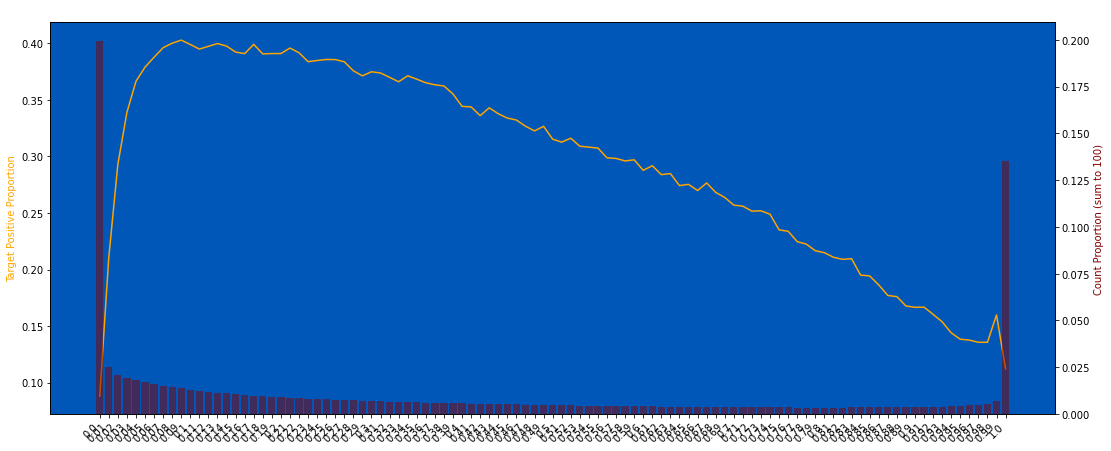

In [216]:
plot_target_check(train, "D_60", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

### D_60a (Created) for monotone

In [252]:
for df in df_list:
    df["D_60a"] = df["D_60"].replace((0, 0.01, 0.02, 0.03, 0.04, 0.05), (1.0, 0.83, 0.67, 0.5, 0.33, 0.17))

0 null count, 0.000 null proportion
nan of the targets have label = 1


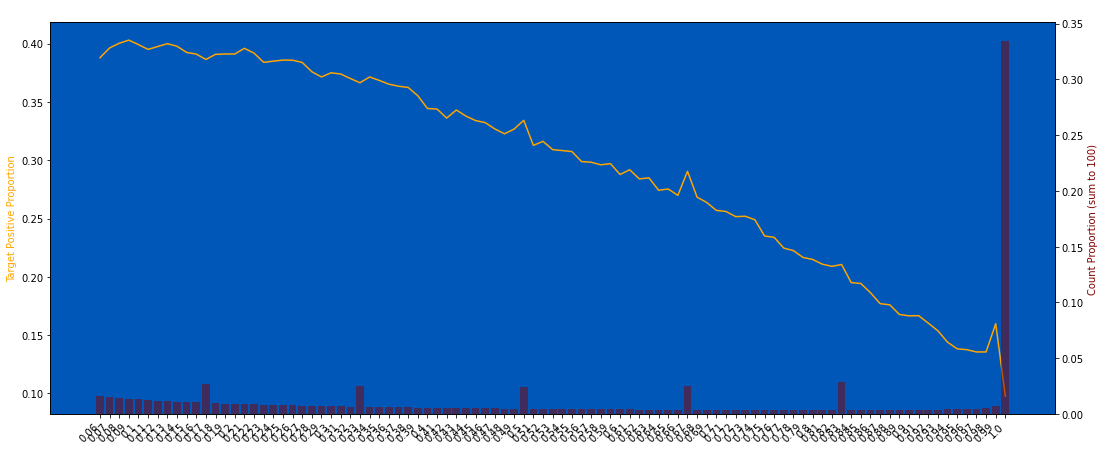

In [253]:
plot_target_check(train, "D_60a", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0017, Train-Private PSI: 0.0033
Bottom 1% and Top 1% are dropped from this chart


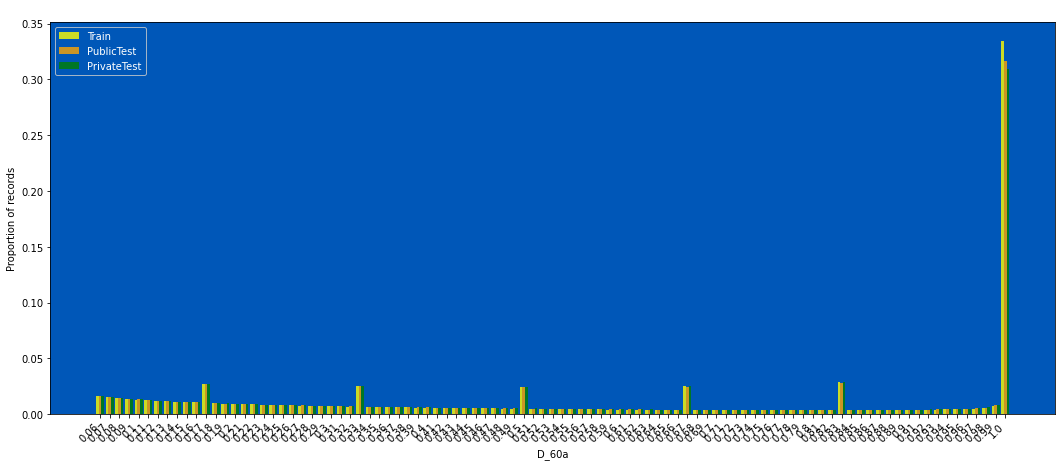

In [254]:
plot_train_test_distribution(df_list, "D_60a", nunique_thr=1000)

### D_61 (KIV) little spike

In [255]:
# plot_target_check(train, "D_61", q=50, use_raw_bin=True)

In [256]:
%%time
df_list = round_dfs(df_list, col="D_61", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0477
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0477
CPU times: user 3.4 s, sys: 1.73 s, total: 5.14 s
Wall time: 7.26 s


598052 null count, 0.108 null proportion
0.0849 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


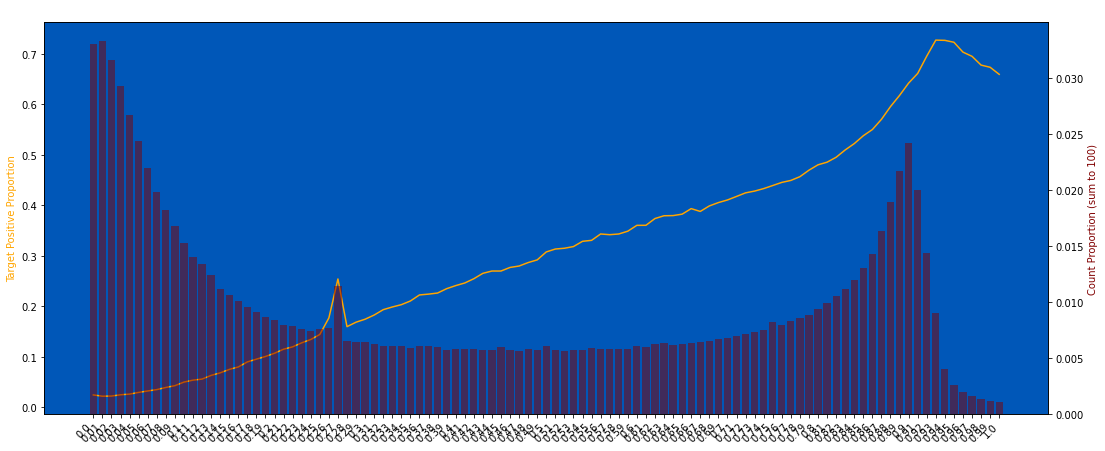

In [220]:
plot_target_check(train, "D_61", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [275]:
print_percentile(df_list, "D_61", 97.7)

97.7th percentile:
train : 0.94
public test : 1.02
private test : 1.04


In [276]:
for df in df_list:
    df = clip_col(df, "D_61", top_value=0.94, add_new_col=False)

In [277]:
describe_all(df_list, "D_61")

train    public test   private test
count           4,933,399.0000 5,105,123.0000 5,018,478.0000
mean                    0.4216         0.4237         0.4143
std                     0.3342         0.3390         0.3387
min                    -0.0100        -0.0100        -0.0100
25%                     0.0900         0.0900         0.0800
50%                     0.3700         0.3600         0.3400
75%                     0.7700         0.7800         0.7700
max                     0.9400         0.9400         0.9400
null_proportion         0.1081         0.1074         0.1109

Train-Public PSI: 0.0098, Train-Private PSI: 0.0141
Bottom 1% and Top 1% are dropped from this chart


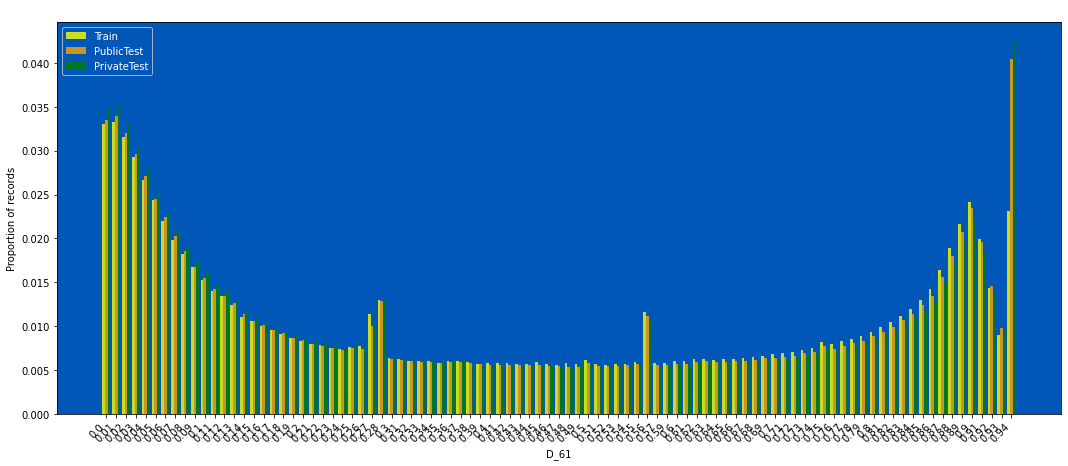

In [278]:
plot_train_test_distribution(df_list, "D_61", nunique_thr=1000)

**Train Test Drift: Moderate**

### D_62 (Done)

In [290]:
# plot_target_check(train, "D_62", q=50, use_raw_bin=True)

In [223]:
%%time
df_list = round_dfs(df_list, col="D_62", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0404
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0387
CPU times: user 5.16 s, sys: 5.11 s, total: 10.3 s
Wall time: 14.2 s


758161 null count, 0.137 null proportion
0.1127 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


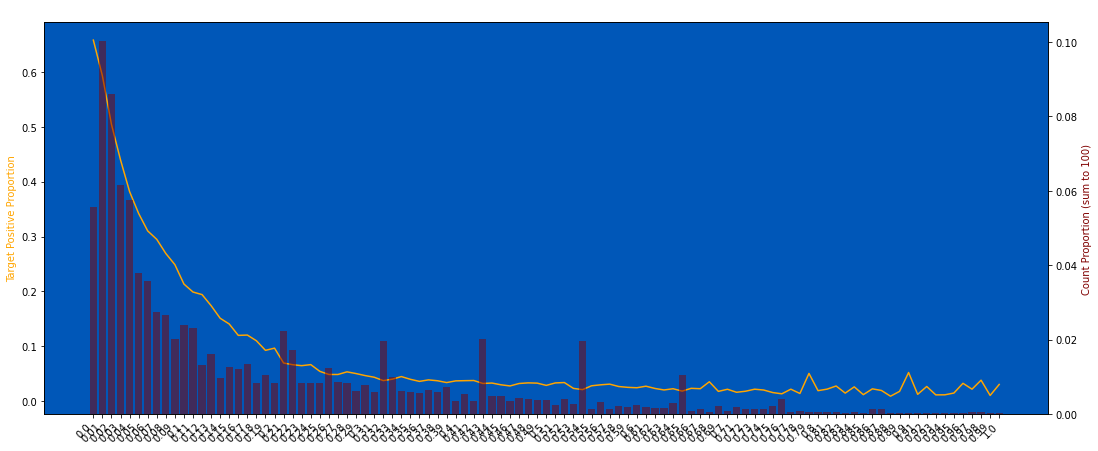

In [224]:
plot_target_check(train, "D_62", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [291]:
describe_all(df_list, "D_62")

train    public test   private test
count           4,773,290.0000 4,796,203.0000 4,676,045.0000
mean                    0.1857         0.1794         0.1847
std                     0.2303         0.2263         0.2297
min                    -0.0100        -0.0100        -0.0100
25%                     0.0300         0.0200         0.0300
50%                     0.0900         0.0800         0.0900
75%                     0.2800         0.2700         0.2800
max                    11.1000        10.8500         9.9900
null_proportion         0.1371         0.1614         0.1715

Train-Public PSI: 0.0380, Train-Private PSI: 0.0387
Bottom 1% and Top 1% are dropped from this chart


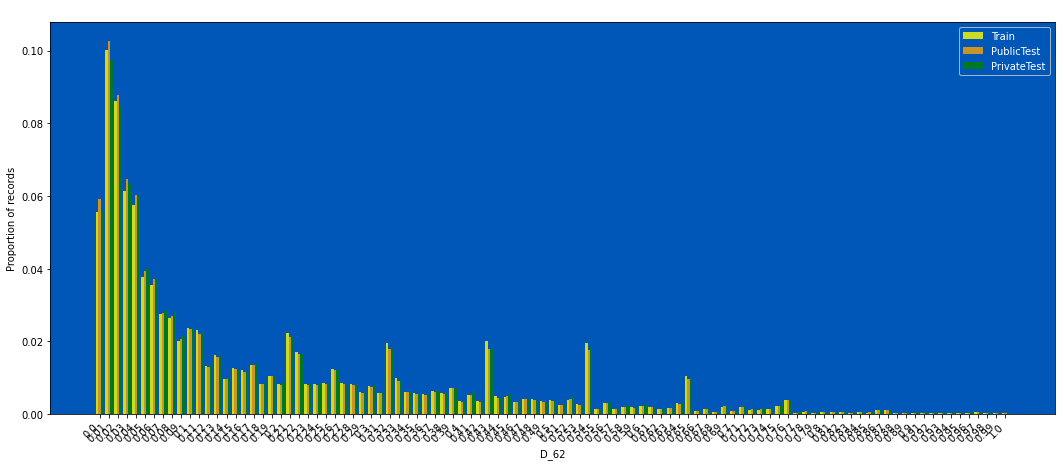

In [292]:
plot_train_test_distribution(df_list, "D_62", nunique_thr=1000)

### D_63 (Done Category)

In [293]:
mapping = dict(train.groupby(["D_63"])["target"].mean())
mapping

{'CL': 0.2908939528730126,
 'CO': 0.2628171377901025,
 'CR': 0.16986495479678712,
 'XL': 0.3174443646805456,
 'XM': 0.23740053050397877,
 'XZ': 0.19091755216008688}

In [294]:
for df in df_list:
    df["D_63"] = df["D_63"].map(mapping)

0 null count, 0.000 null proportion
nan of the targets have label = 1


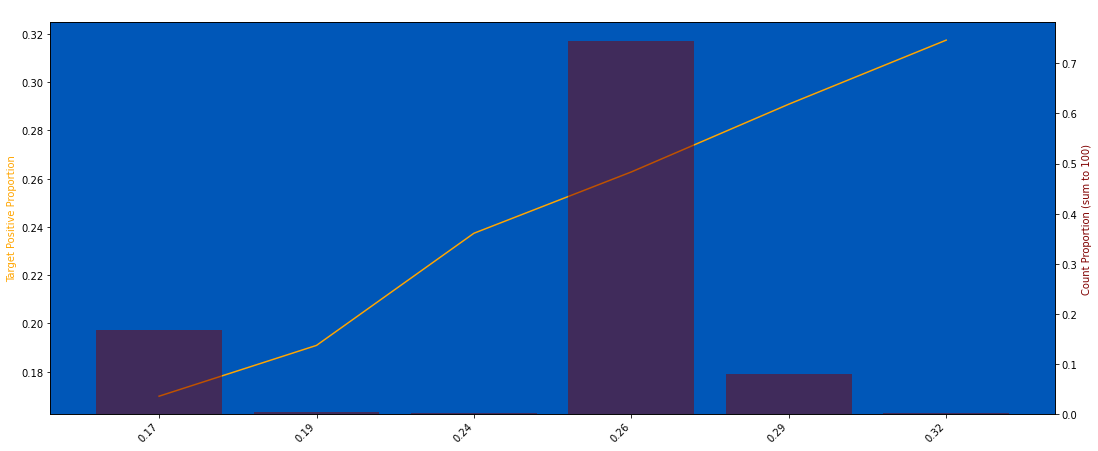

In [295]:
plot_target_check(train, "D_63", q=50, use_raw_bin=True, strfy_x=True, without_drop_tail=True)

In [296]:
for df in df_list:
    df["D_63"] = df["D_63"].astype("category").cat.codes

0 null count, 0.000 null proportion
nan of the targets have label = 1


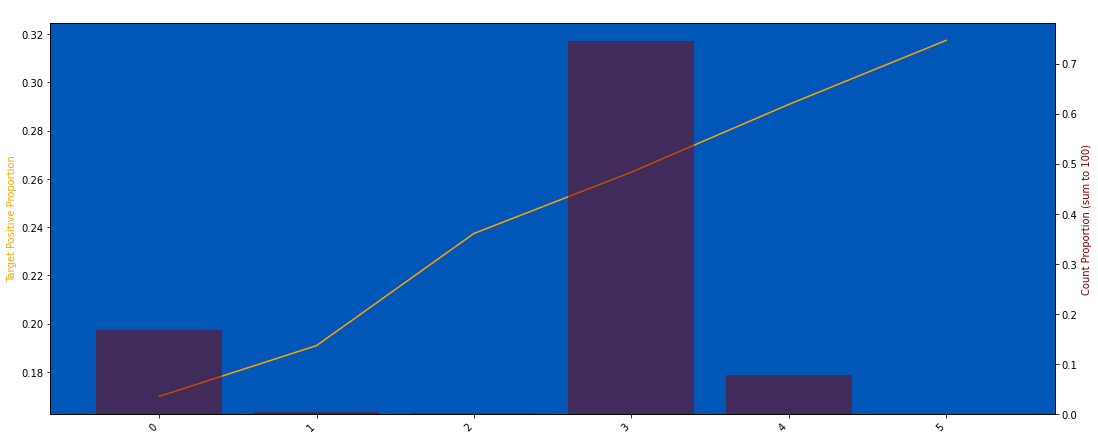

In [297]:
plot_target_check(train, "D_63", q=50, use_raw_bin=True, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0047, Train-Private PSI: 0.0094


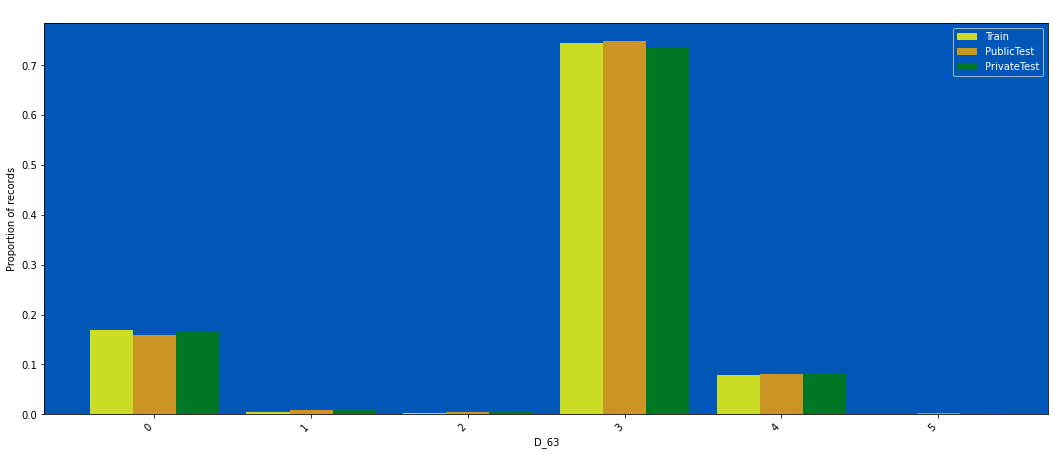

In [298]:
plot_train_test_distribution(df_list, "D_63", nunique_thr=1000, without_drop_tail=True)

### D_64 (Done Category)

In [330]:
train["D_64"] = train["D_64"].replace("-1", np.nan)

In [334]:
mapping = dict(train.groupby(["D_64"])["target"].mean())
mapping

{'O': 0.16925461787615456, 'R': 0.31524249147732686, 'U': 0.3432227420955622}

In [335]:
for df in df_list:
    df["D_64"] = df["D_64"].map(mapping)

254647 null count, 0.046 null proportion
0.3812 of the targets have label = 1


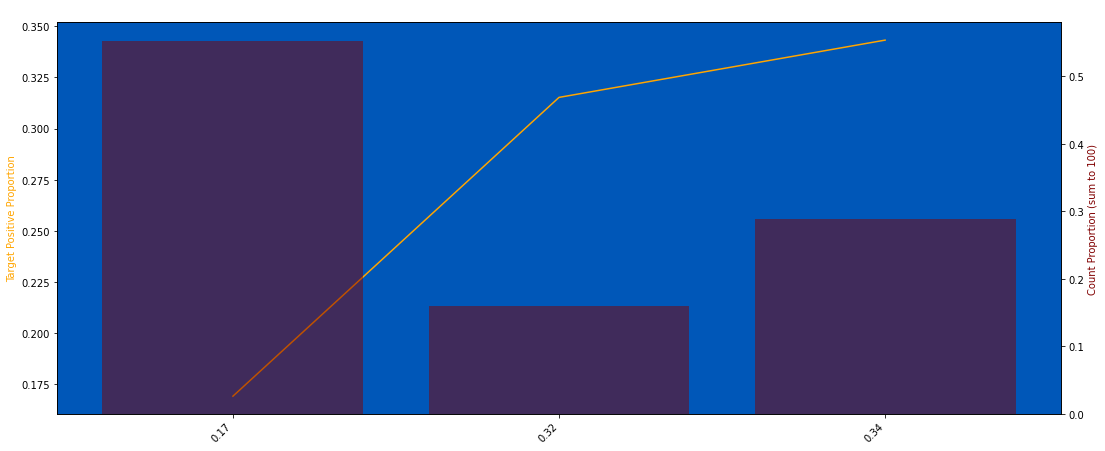

In [336]:
plot_target_check(train, "D_64", q=50, use_raw_bin=True, nunique_thr=50, strfy_x=True, without_drop_tail=True)

In [337]:
for df in df_list:
    df["D_64"] = df["D_64"].astype("category").cat.codes

Train-Public PSI: 0.0055, Train-Private PSI: 0.0151


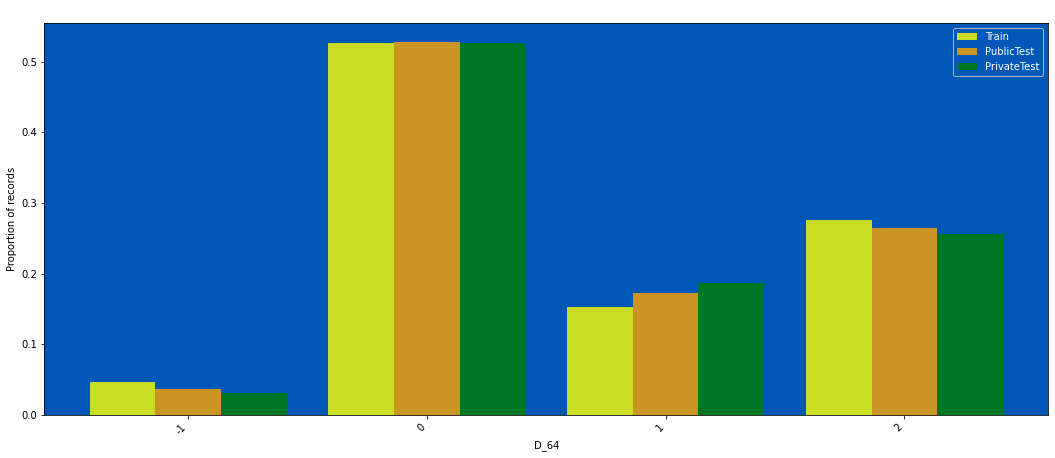

In [338]:
plot_train_test_distribution(df_list, "D_64", nunique_thr=1000, without_drop_tail=True)

### D_65 (Done)

In [340]:
# plot_target_check(train, "D_65", q=200, use_raw_bin=True, nunique_thr=1000)

In [341]:
%%time
df_list = round_dfs(df_list, col="D_65", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0525
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0519
CPU times: user 5.63 s, sys: 7.78 s, total: 13.4 s
Wall time: 21.2 s


In [344]:
for df in df_list:
    df["D_65"] = df["D_65"].replace(0, np.nan)

5293716 null count, 0.957 null proportion
0.2315 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


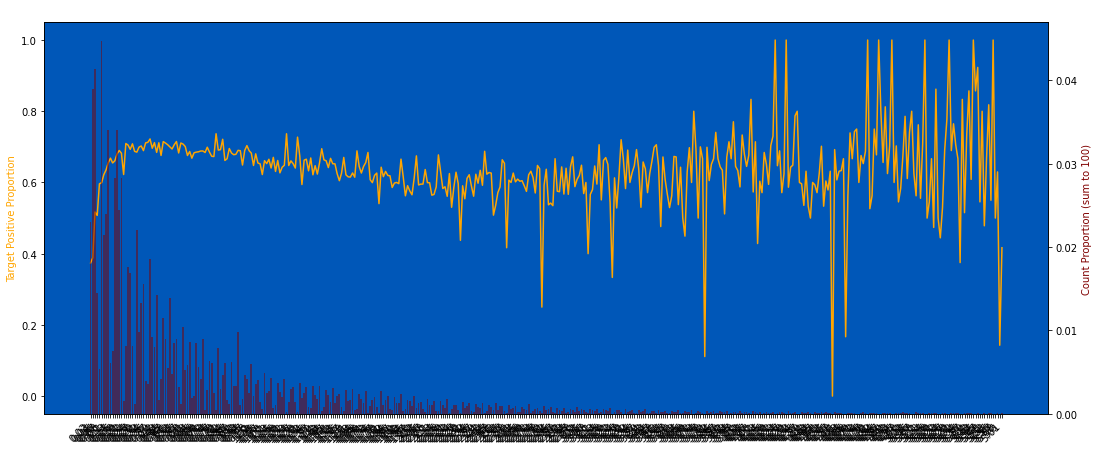

In [345]:
plot_target_check(train, "D_65", q=200, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [360]:
for df in df_list:
    df["D_65"] = df["D_65"].parallel_apply(lambda x: manual_stack(x, start=0.01, stack_interval=0.03, denom=100))

5293716 null count, 0.957 null proportion
0.2315 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


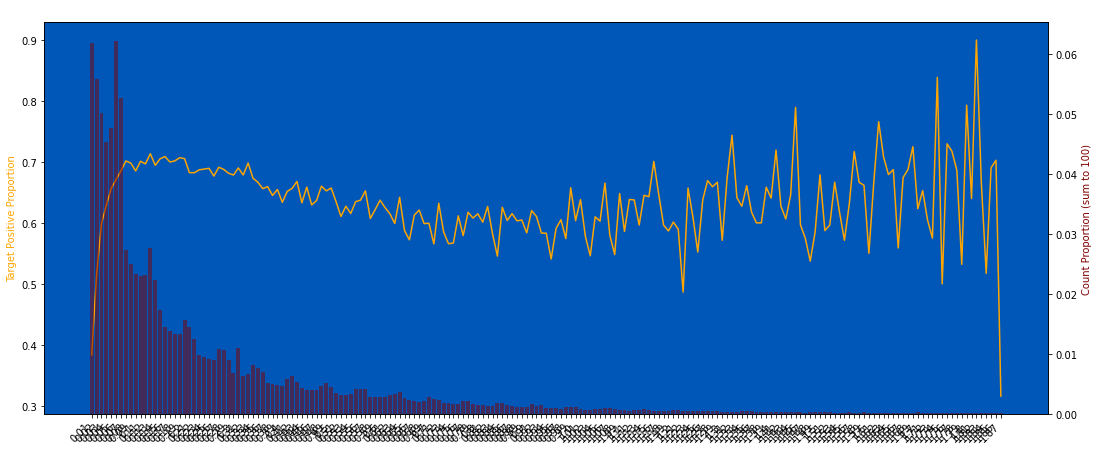

In [361]:
plot_target_check(train, "D_65", q=200, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

Train-Public PSI: 0.0546, Train-Private PSI: 0.0508
Bottom 1% and Top 1% are dropped from this chart


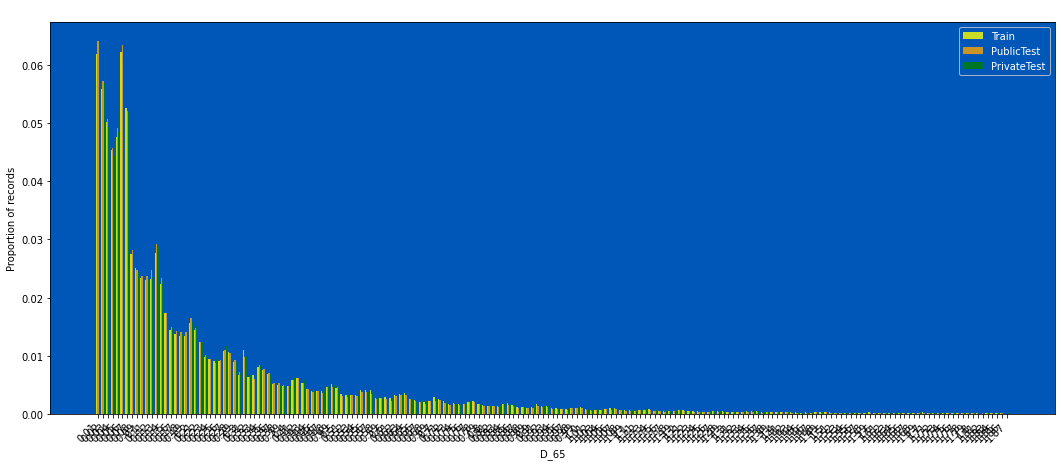

In [362]:
plot_train_test_distribution(df_list, "D_65", nunique_thr=10000)

In [454]:
# print_percentile(df_list, "D_65", 99.96)

In [363]:
describe_all(df_list, "D_65")

train  public test  private test
count           237,735.0000 236,625.0000  231,466.0000
mean                  0.2729       0.2568        0.2655
std                   0.7135       0.9213        0.7675
min                   0.0100       0.0100        0.0100
25%                   0.0500       0.0500        0.0500
50%                   0.1300       0.1200        0.1300
75%                   0.3200       0.3000        0.3100
max                 128.6400     279.2200      176.6700
null_proportion       0.9570       0.9586        0.9590

### D_66 (Drop)

In [455]:
# plot_target_check(train, "D_66", q=50, use_raw_bin=True, nunique_thr=50, without_drop_tail=True)

Train-Public PSI: 0.0028, Train-Private PSI: 0.0032
Bottom 1% and Top 1% are dropped from this chart


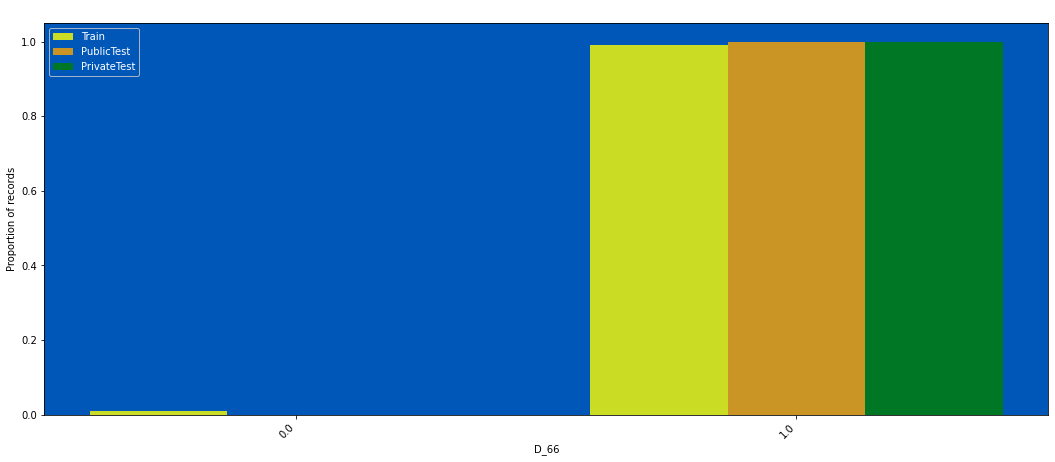

In [365]:
plot_train_test_distribution(df_list, "D_66", nunique_thr=1000)

In [366]:
private_test["D_66"].value_counts()

1.0000    681084
Name: D_66, dtype: int64

In [367]:
%%time
for df in tqdm(df_list):
    df = df.drop(columns="D_66", errors="ignore")

CPU times: user 9.28 s, sys: 16.8 s, total: 26.1 s
Wall time: 35.9 s


### D_68 (Done Category)

In [428]:
train["D_68"] = train["D_68"].replace(0, 6)

In [429]:
mapping = dict(train.groupby(["D_68"])["target"].mean())
mapping

{1.0: 0.4039903246645934,
 2.0: 0.3929017632012939,
 3.0: 0.3697800768719475,
 4.0: 0.3436032414965202,
 5.0: 0.26221887882726724,
 6.0: 0.17497909504784911}

In [430]:
for df in df_list:
    df["D_68"] = df["D_68"].map(mapping)

216503 null count, 0.039 null proportion
0.4145 of the targets have label = 1


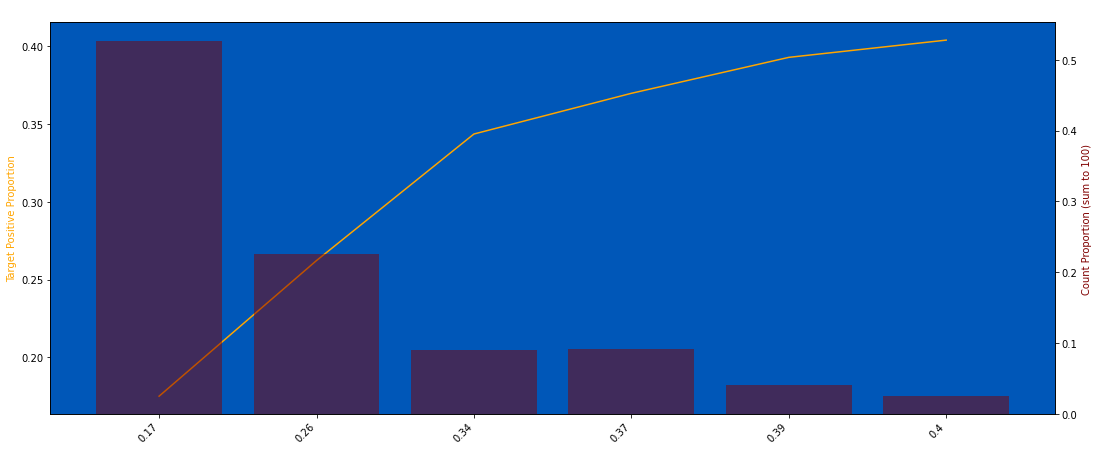

In [431]:
plot_target_check(train, "D_68", q=50, use_raw_bin=True, nunique_thr=50, strfy_x=True, without_drop_tail=True)

In [432]:
for df in df_list:
    df["D_68"] = df["D_68"].astype("category").cat.codes

Train-Public PSI: 0.0021, Train-Private PSI: 0.0054


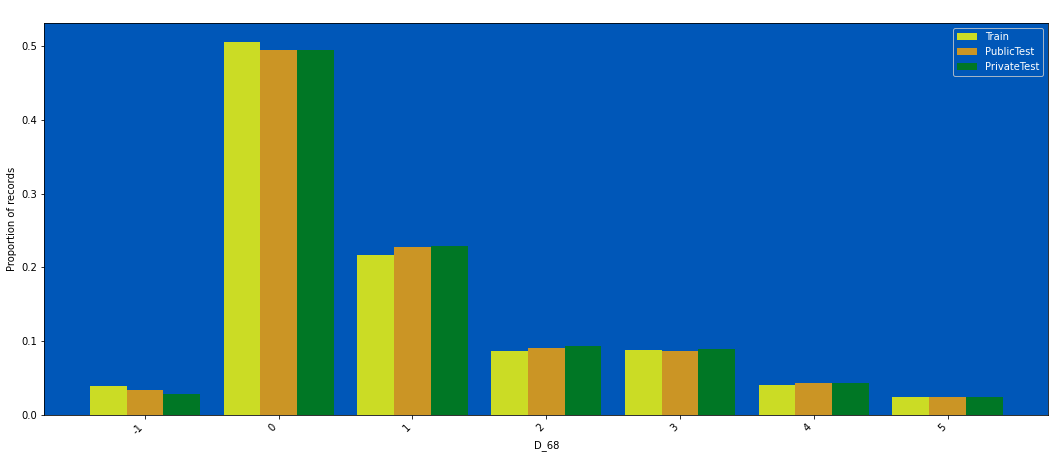

In [433]:
plot_train_test_distribution(df_list, "D_68", nunique_thr=1000, without_drop_tail=True)

### D_69 (Done Binary)

In [441]:
# plot_target_check(train, "D_69", q=50, use_raw_bin=True)

In [442]:
%%time
df_list = round_dfs(df_list, col="D_69", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0191
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0191
CPU times: user 5.48 s, sys: 7.97 s, total: 13.4 s
Wall time: 22.1 s


In [457]:
for df in df_list:
    df["D_69"] = df["D_69"].fillna(1)
    df["D_69"] = np.where(df["D_69"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


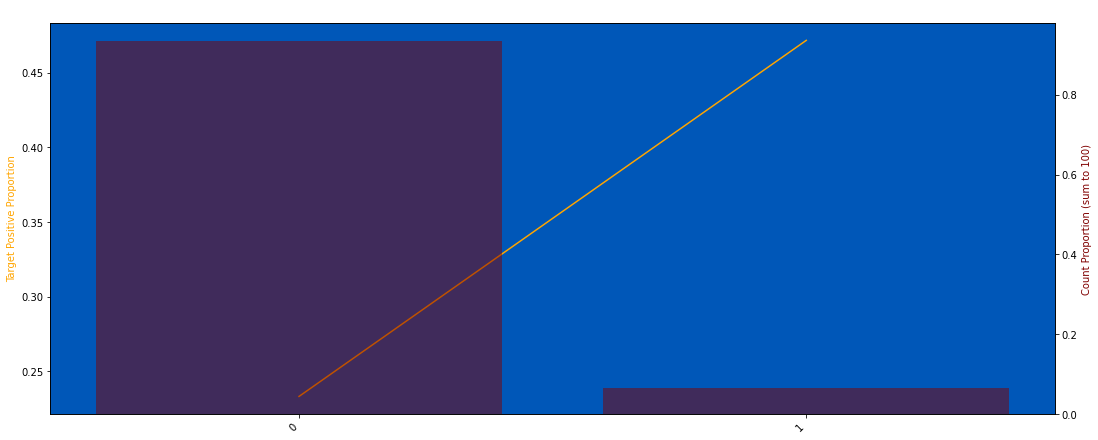

In [458]:
plot_target_check(train, "D_69", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0040, Train-Private PSI: 0.0114
Bottom 1% and Top 1% are dropped from this chart


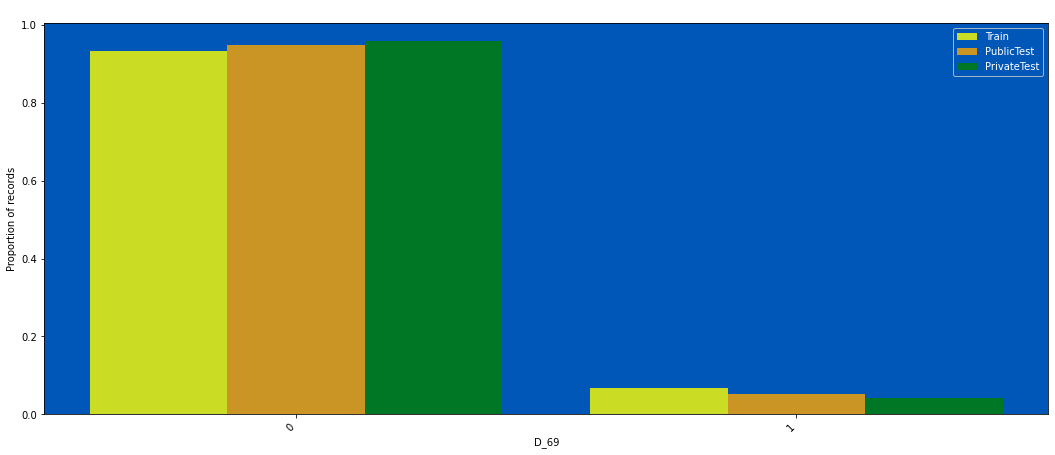

In [459]:
plot_train_test_distribution(df_list, "D_69", nunique_thr=5000)

### D_70 (Done Integer)

In [434]:
# plot_target_check(train, "D_70", q=50, use_raw_bin=True)

In [435]:
%%time
df_list = round_dfs(df_list, col="D_70", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0045
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0019
CPU times: user 5.65 s, sys: 7.71 s, total: 13.4 s
Wall time: 21.3 s


In [436]:
for df in df_list:
    df["D_70_"] = (df["D_70"] * 4).round(0)

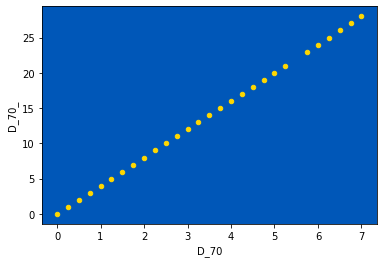

In [437]:
check_binning(train, "D_70", end=3000)

In [438]:
for df in df_list:
    df["D_70"] = (df["D_70"] * 4).round(0)

In [464]:
print_percentile(df_list, "D_70", 99.99)

99.99th percentile:
train : 12.0
public test : 12.0
private test : 12.0


In [460]:
describe_all(df_list, "D_70")

train    public test   private test
count           5,436,534.0000 5,647,750.0000 5,577,832.0000
mean                    0.4223         0.4431         0.4289
std                     0.9109         0.9382         0.9207
min                     0.0000         0.0000         0.0000
25%                     0.0000         0.0000         0.0000
50%                     0.0000         0.0000         0.0000
75%                     1.0000         1.0000         1.0000
max                    28.0000        26.0000        33.0000
null_proportion         0.0172         0.0125         0.0118

In [465]:
for df in df_list:
    df = clip_col(df, "D_70", top_value=12, add_new_col=False)

94917 null count, 0.017 null proportion
0.4203 of the targets have label = 1


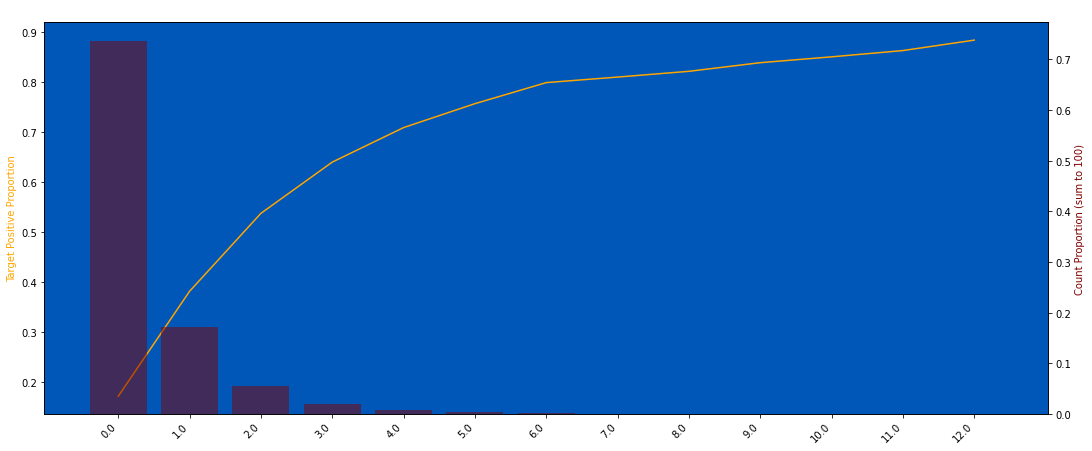

In [466]:
plot_target_check(train, "D_70", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0006, Train-Private PSI: 0.0001


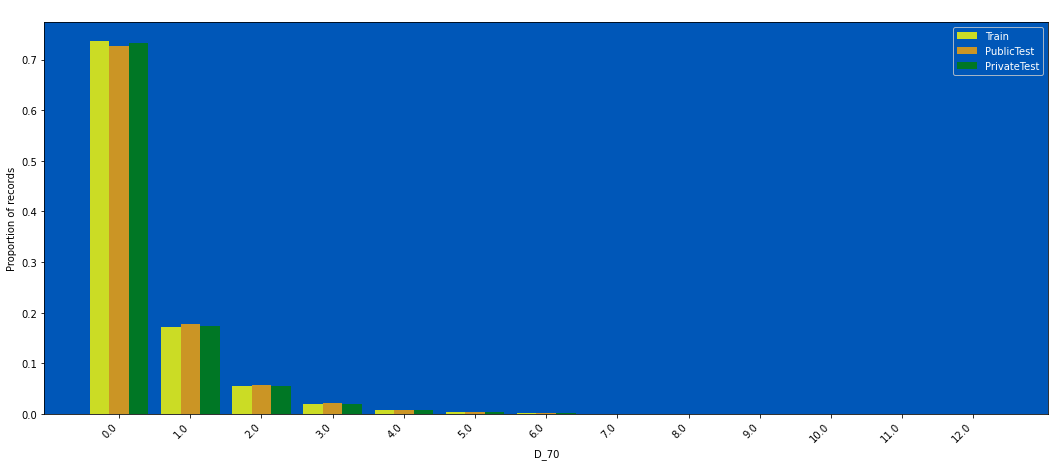

In [467]:
plot_train_test_distribution(df_list, "D_70", nunique_thr=5000, without_drop_tail=True)

### D_71 (KIV) Slight Drift

In [472]:
# plot_target_check(train, "D_71", q=50, use_raw_bin=True)

In [469]:
%%time
df_list = round_dfs(df_list, col="D_71", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0995
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1008
CPU times: user 5.54 s, sys: 7.2 s, total: 12.7 s
Wall time: 20.1 s


In [479]:
describe_all(df_list, "D_71")

train    public test   private test
count           5,531,451.0000 5,719,469.0000 5,644,293.0000
mean                    0.0658         0.0669         0.0701
std                     0.3260         0.3309         0.3335
min                     0.0000         0.0000         0.0000
25%                     0.0000         0.0000         0.0000
50%                     0.0100         0.0100         0.0100
75%                     0.0300         0.0200         0.0300
max                    67.0300        67.0200        59.3500
null_proportion         0.0000         0.0000         0.0000

In [480]:
for df in df_list:
    df["D_71"] = df["D_71"].replace(0.01, np.nan)
    df["D_71"] = df["D_71"].replace(0, 0.01)

1989047 null count, 0.360 null proportion
0.2427 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


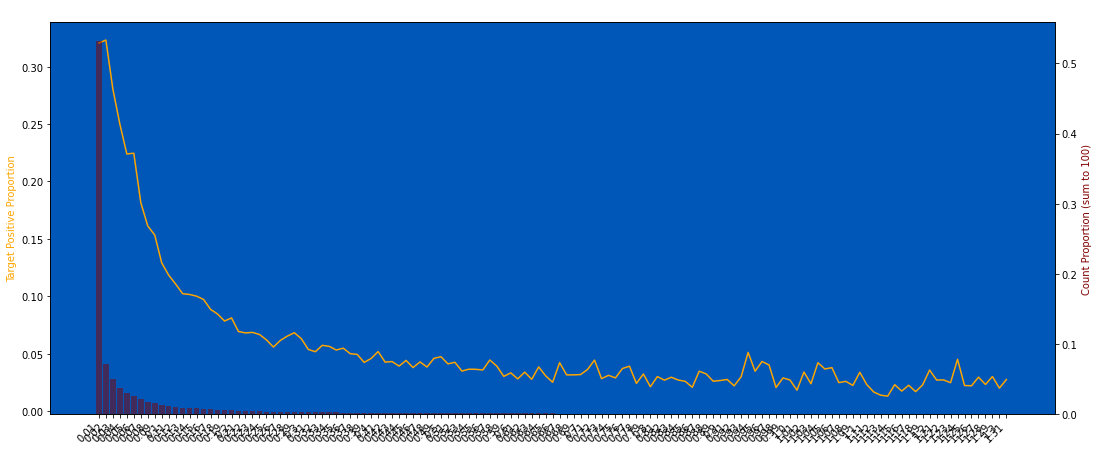

In [481]:
plot_target_check(train, "D_71", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0920, Train-Private PSI: 0.1018
Bottom 1% and Top 1% are dropped from this chart


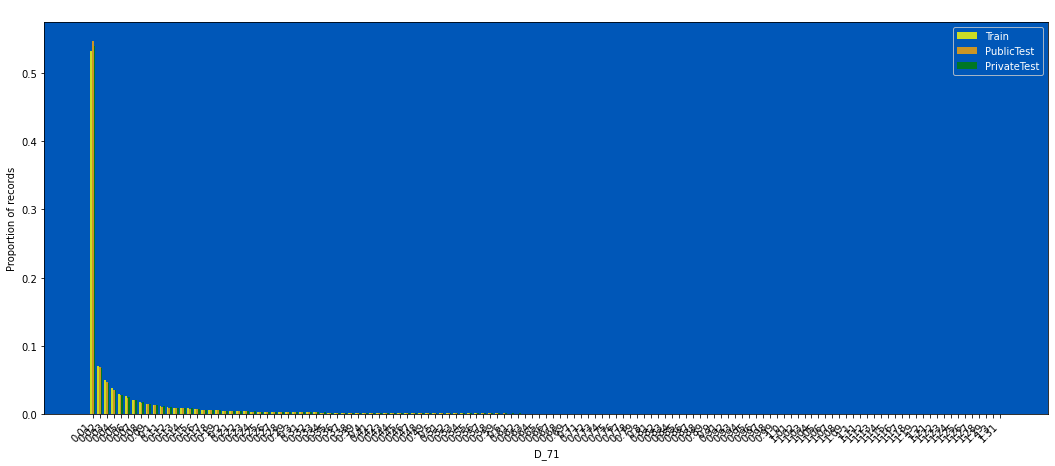

In [482]:
plot_train_test_distribution(df_list, "D_71", nunique_thr=5000)

### D_72 (Done Integer)

In [484]:
# plot_target_check(train, "D_72", q=50, use_raw_bin=True)

In [485]:
%%time
df_list = round_dfs(df_list, col="D_72", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0006
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0006
CPU times: user 5.36 s, sys: 7.37 s, total: 12.7 s
Wall time: 20.5 s


In [488]:
for df in df_list:
    df["D_72"] = (df["D_72"] * 3).round(0)

23708 null count, 0.004 null proportion
0.3495 of the targets have label = 1


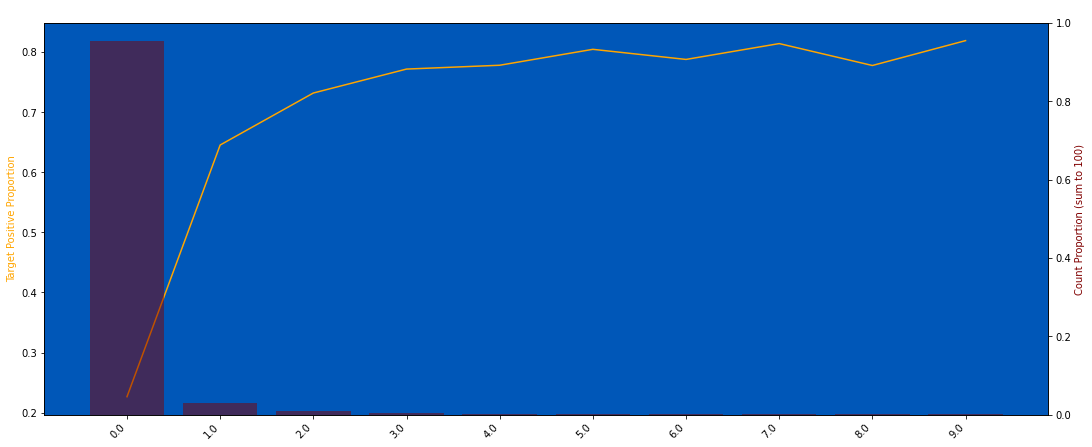

In [489]:
plot_target_check(train, "D_72", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0005, Train-Private PSI: 0.0006


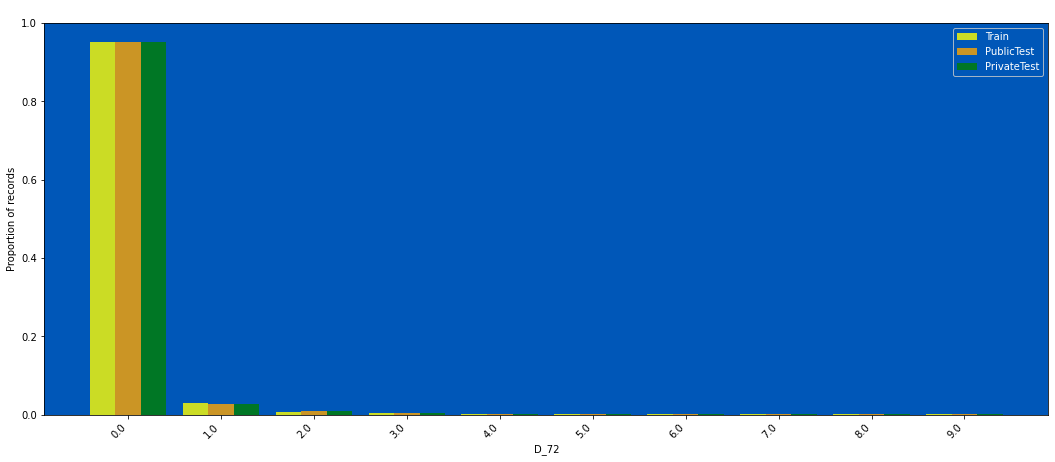

In [490]:
plot_train_test_distribution(df_list, "D_72", nunique_thr=5000, without_drop_tail=True)

### D_73 (Drop)

In [495]:
# plot_target_check(train, "D_73", q=50, use_raw_bin=True)

In [494]:
%%time
df_list = round_dfs(df_list, col="D_73", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1174
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0537
CPU times: user 4.19 s, sys: 7.11 s, total: 11.3 s
Wall time: 19.8 s


5475595 null count, 0.990 null proportion
0.2478 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


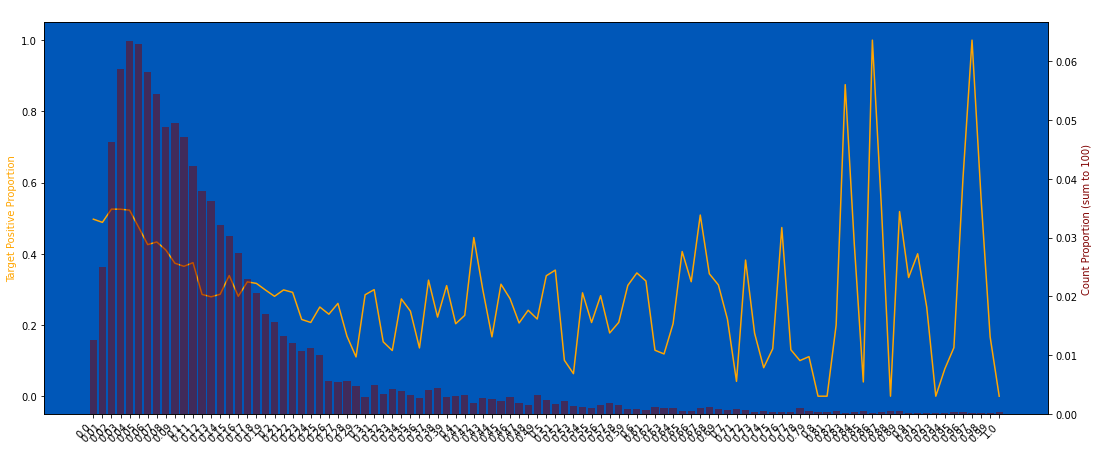

In [496]:
plot_target_check(train, "D_73", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0450, Train-Private PSI: 0.0537
Bottom 1% and Top 1% are dropped from this chart


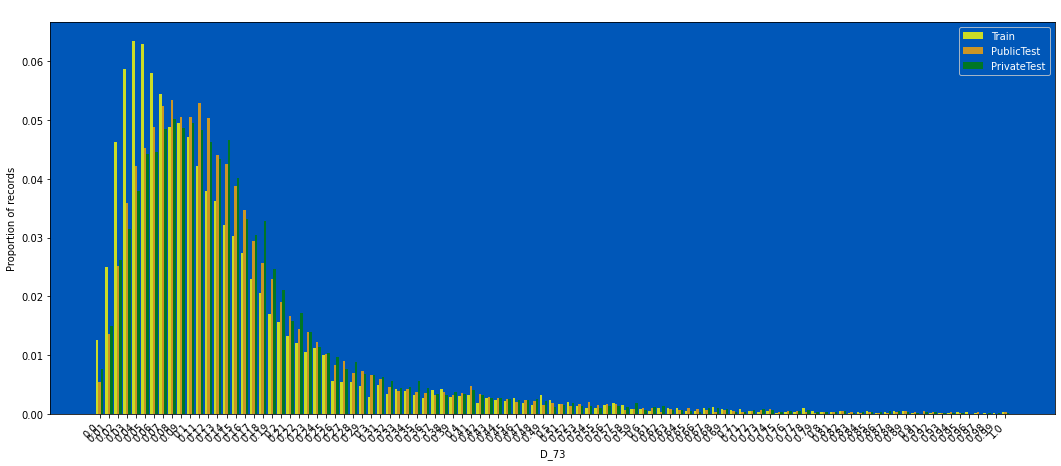

In [497]:
plot_train_test_distribution(df_list, "D_73", nunique_thr=5000)

In [498]:
%%time
for df in df_list:
    df = df.drop(columns="D_73", errors="ignore")

CPU times: user 7.2 s, sys: 13.1 s, total: 20.3 s
Wall time: 29.9 s


### D_74 (Done Integer)

In [506]:
# plot_target_check(train, "D_74", q=50, use_raw_bin=True)

In [500]:
%%time
df_list = round_dfs(df_list, col="D_74", decimals=3, add_new_col=False)

Before round, Train-Private PSI = 0.0145
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0145
CPU times: user 6.04 s, sys: 6.98 s, total: 13 s
Wall time: 17.9 s


In [501]:
%%time
for df in df_list:
    df["D_74_"] = (df["D_74"] / 0.071)
df_list = round_dfs(df_list, col="D_74_", decimals=0, add_new_col=False)

Before round, Train-Private PSI = 0.0145
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0044
CPU times: user 2.43 s, sys: 1.11 s, total: 3.54 s
Wall time: 4.84 s


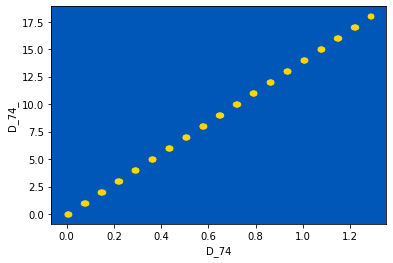

In [502]:
check_binning(train, "D_74", start=0, end=200)

In [503]:
%%time
for df in df_list:
    df["D_74"] = (df["D_74"] / 0.071)
df_list = round_dfs(df_list, col="D_74", decimals=0, add_new_col=False)

Before round, Train-Private PSI = 0.0145
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0044
CPU times: user 2.92 s, sys: 1.54 s, total: 4.46 s
Wall time: 5.87 s


In [507]:
describe_all(df_list, "D_74")

train    public test   private test
count           5,509,678.0000 5,700,232.0000 5,622,857.0000
mean                    2.0789         2.1058         2.0430
std                     3.0684         3.1364         3.1042
min                     0.0000         0.0000         0.0000
25%                     0.0000         0.0000         0.0000
50%                     1.0000         1.0000         1.0000
75%                     3.0000         3.0000         3.0000
max                    63.0000        56.0000        93.0000
null_proportion         0.0039         0.0034         0.0038

In [518]:
print_percentile(df_list, "D_74", 99.98)

99.98th percentile:
train : 29.0
public test : 30.0
private test : 30.0


In [522]:
for df in df_list:
    df = clip_col(df, "D_74", top_value=25, add_new_col=False)

21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1


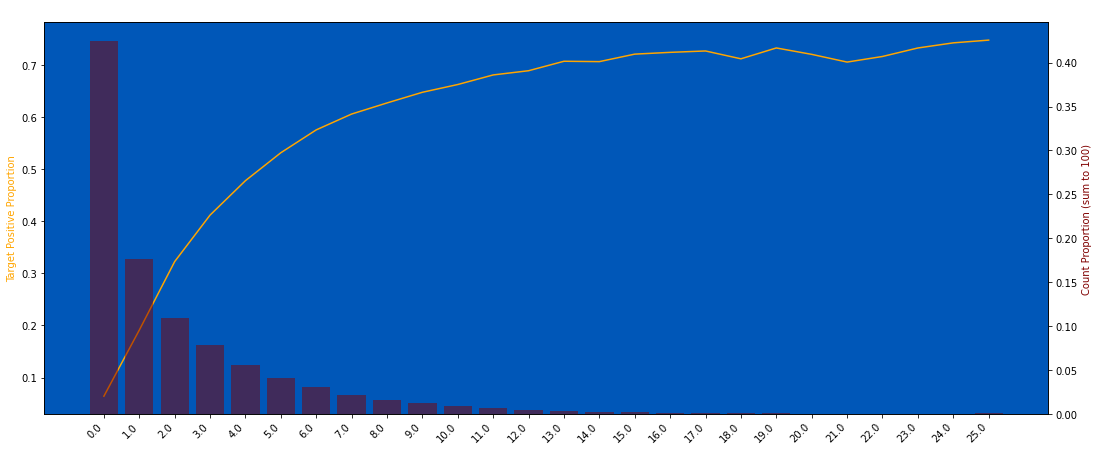

In [523]:
plot_target_check(train, "D_74", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0002, Train-Private PSI: 0.0008


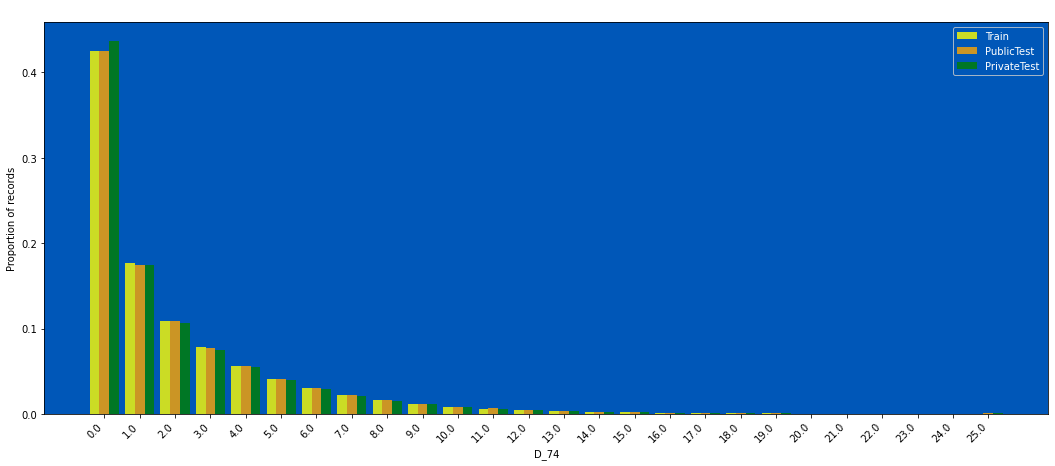

In [524]:
plot_train_test_distribution(df_list, "D_74", nunique_thr=5000, without_drop_tail=True)

### D_75 (Done Integer)

In [525]:
# plot_target_check(train, "D_75", q=50, use_raw_bin=True)

In [526]:
%%time
df_list = round_dfs(df_list, col="D_75", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0157
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0060
CPU times: user 5.72 s, sys: 6.51 s, total: 12.2 s
Wall time: 17.8 s


In [527]:
for df in df_list:
    df["D_75_"] = (df["D_75"] * (100 / 6.66)).round(0)

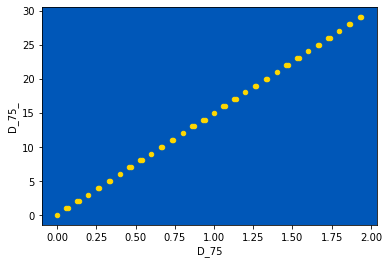

In [528]:
check_binning(train, "D_75", start=0, end=50)

In [529]:
for df in df_list:
    df["D_75"] = (df["D_75"] * (100 / 6.66)).round(0)

In [534]:
print_percentile(df_list, "D_75", 99.9)

99.9th percentile:
train : 24.0
public test : 24.0
private test : 25.0


In [532]:
describe_all(df_list, "D_75")

train    public test   private test
count           5,531,451.0000 5,719,469.0000 5,644,293.0000
mean                    2.4930         2.5475         2.4801
std                     3.3629         3.4507         3.4188
min                     0.0000         0.0000         0.0000
25%                     0.0000         0.0000         0.0000
50%                     1.0000         1.0000         1.0000
75%                     4.0000         4.0000         4.0000
max                    64.0000        57.0000        96.0000
null_proportion         0.0000         0.0000         0.0000

In [535]:
for df in df_list:
    df = clip_col(df, "D_75", top_value=25, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


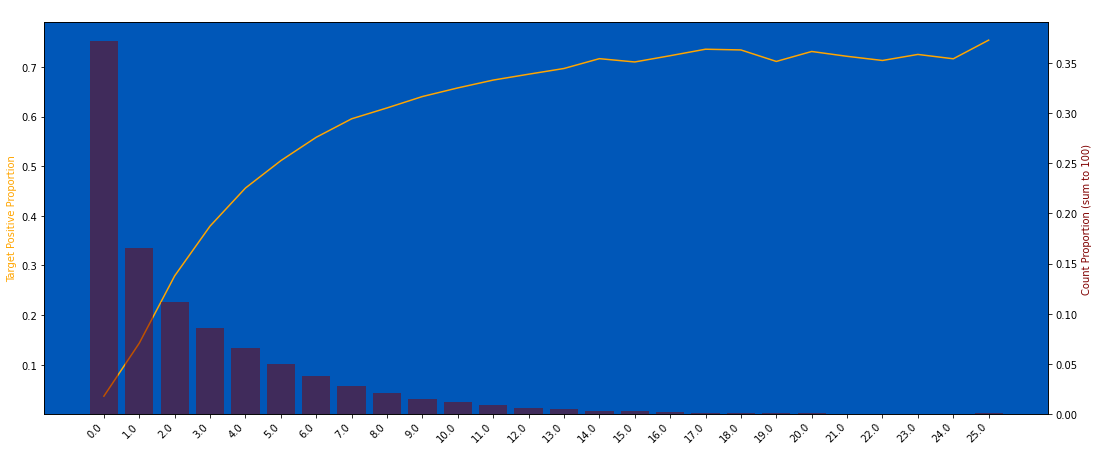

In [536]:
plot_target_check(train, "D_75", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0004, Train-Private PSI: 0.0005


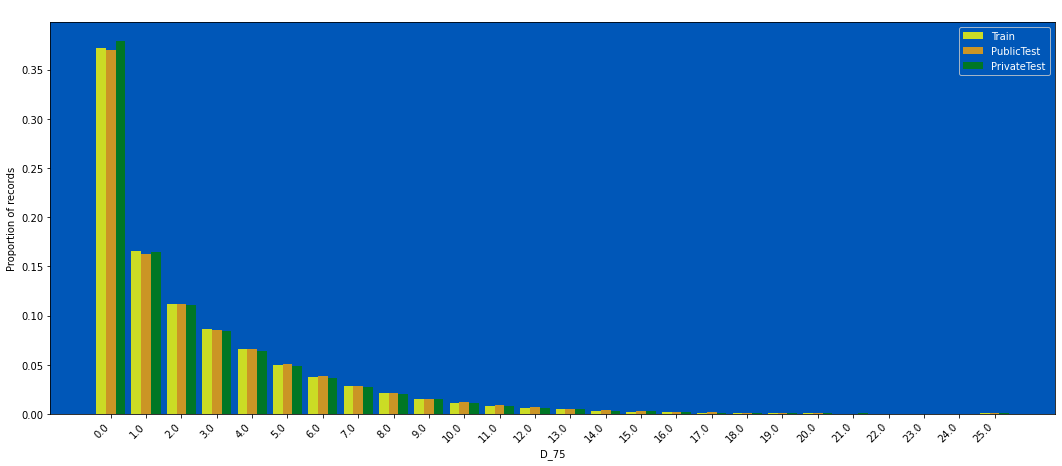

In [537]:
plot_train_test_distribution(df_list, "D_75", nunique_thr=5000, without_drop_tail=True)

### D_76 (Done)

In [539]:
# plot_target_check(train, "D_76", q=50, use_raw_bin=True)

In [540]:
%%time
df_list = round_dfs(df_list, col="D_76", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0986
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0999
CPU times: user 4.74 s, sys: 7.75 s, total: 12.5 s
Wall time: 21.2 s


4908954 null count, 0.887 null proportion
0.2677 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


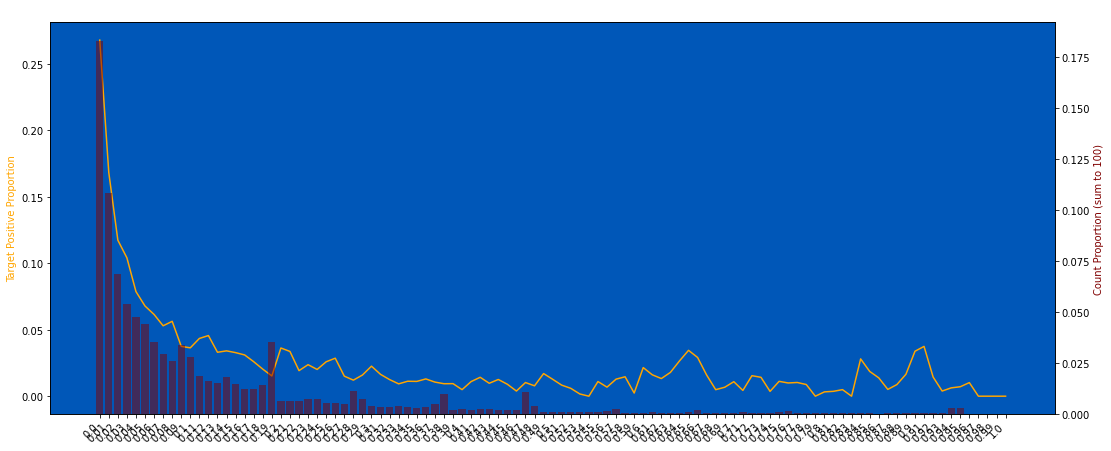

In [541]:
plot_target_check(train, "D_76", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

Train-Public PSI: 0.0951, Train-Private PSI: 0.0999
Bottom 1% and Top 1% are dropped from this chart


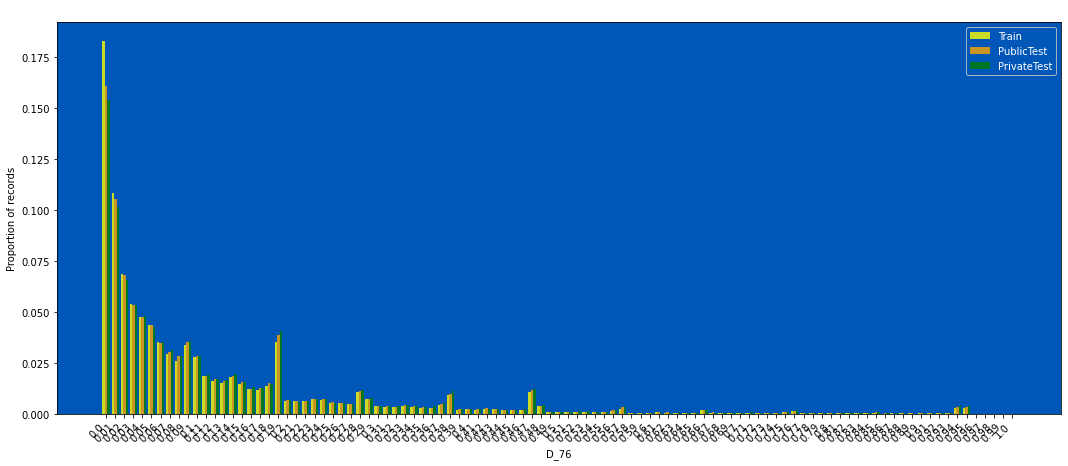

In [542]:
plot_train_test_distribution(df_list, "D_76", nunique_thr=5000)

### D_77 (Done)

In [547]:
# plot_target_check(train, "D_77", q=50, use_raw_bin=True)

In [544]:
%%time
df_list = round_dfs(df_list, col="D_77", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0385
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0321
CPU times: user 5.01 s, sys: 7.01 s, total: 12 s
Wall time: 19.2 s


In [ ]:
describe_all(df_list, "D_77")

train    public test   private test
count           3,017,539.0000 2,926,675.0000 2,864,262.0000
mean                    0.2516         0.2499         0.2564
std                     0.2326         0.2308         0.2332
min                     0.0000         0.0000         0.0000
25%                     0.0700         0.0700         0.0800
50%                     0.2000         0.2000         0.2000
75%                     0.3700         0.3600         0.3800
max                    10.2200        10.0000         9.2000
null_proportion         0.4545         0.4883         0.4925

In [ ]:
print_percentile(df_list, "D_77", 99.3)

99.3th percentile:
train : 1.05
public test : 1.05
private test : 1.06


In [ ]:
for df in df_list:
    df = clip_col(df, "D_77", top_value=1.01, add_new_col=False)

2513912 null count, 0.454 null proportion
0.3395 of the targets have label = 1


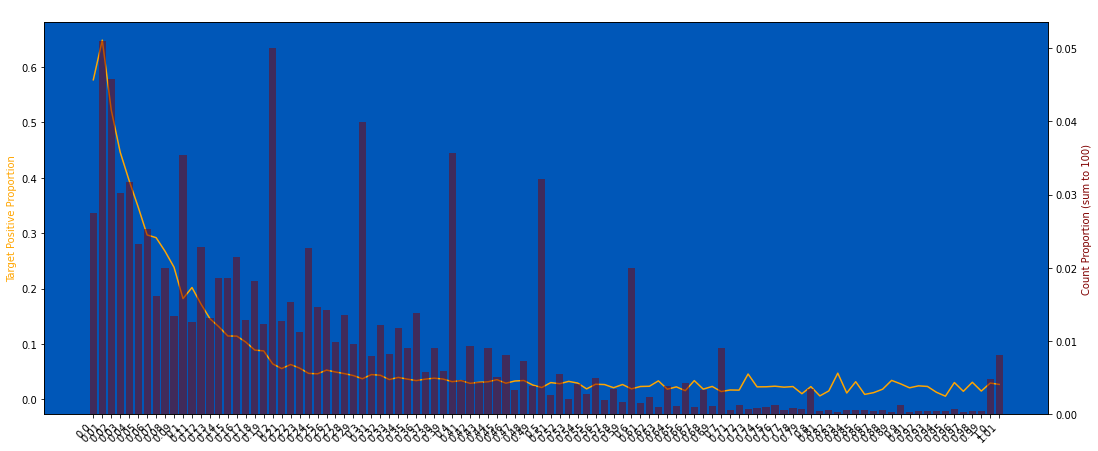

In [556]:
plot_target_check(train, "D_77", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0035, Train-Private PSI: 0.0051
Bottom 1% and Top 1% are dropped from this chart


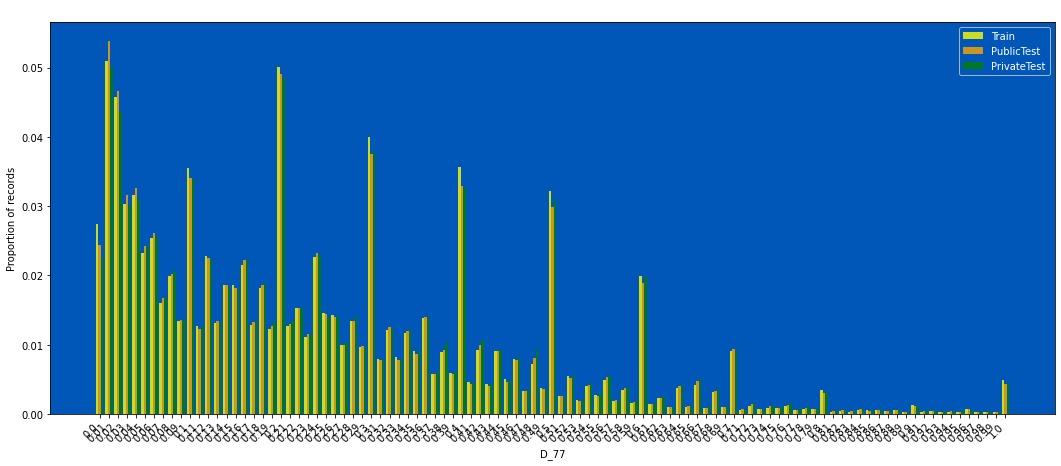

In [557]:
plot_train_test_distribution(df_list, "D_77", nunique_thr=5000)

### D_78 (Done Integer)

In [566]:
# plot_target_check(train, "D_78", q=50, use_raw_bin=True)

In [559]:
%%time
df_list = round_dfs(df_list, col="D_78", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0040
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0020
CPU times: user 5.43 s, sys: 7.1 s, total: 12.5 s
Wall time: 20.5 s


In [563]:
for df in df_list:
    df["D_78"] = (df["D_78"] * 2).round(0)

In [567]:
describe_all(df_list, "D_78")

train    public test   private test
count           5,257,132.0000 5,449,182.0000 5,376,415.0000
mean                    0.1152         0.1227         0.1210
std                     0.5186         0.5430         0.5479
min                     0.0000         0.0000         0.0000
25%                     0.0000         0.0000         0.0000
50%                     0.0000         0.0000         0.0000
75%                     0.0000         0.0000         0.0000
max                    32.0000        26.0000        25.0000
null_proportion         0.0496         0.0473         0.0475

In [572]:
print_percentile(df_list, "D_78", 99.99)

99.99th percentile:
train : 10.0
public test : 10.0
private test : 10.0


In [573]:
for df in df_list:
    df = clip_col(df, "D_78", top_value=10, add_new_col=False)

274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1


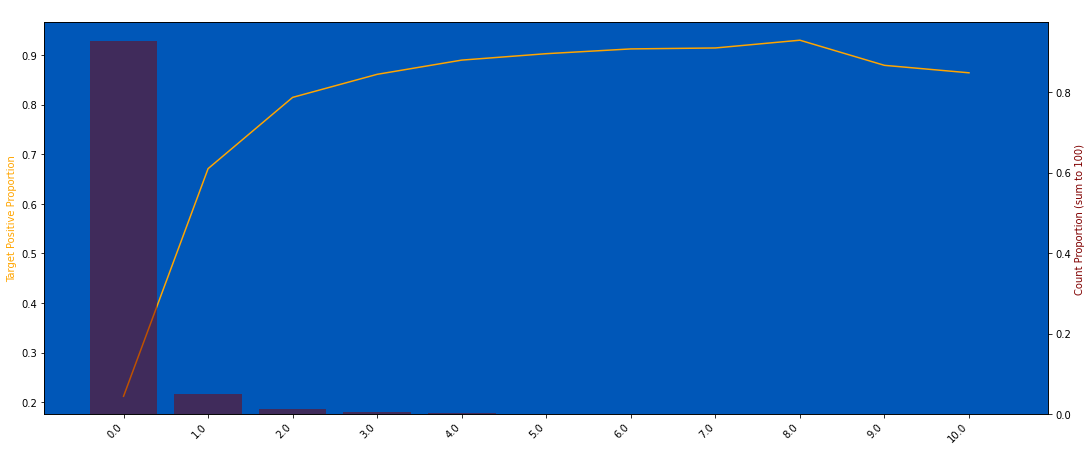

In [574]:
plot_target_check(train, "D_78", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0002, Train-Private PSI: 0.0002


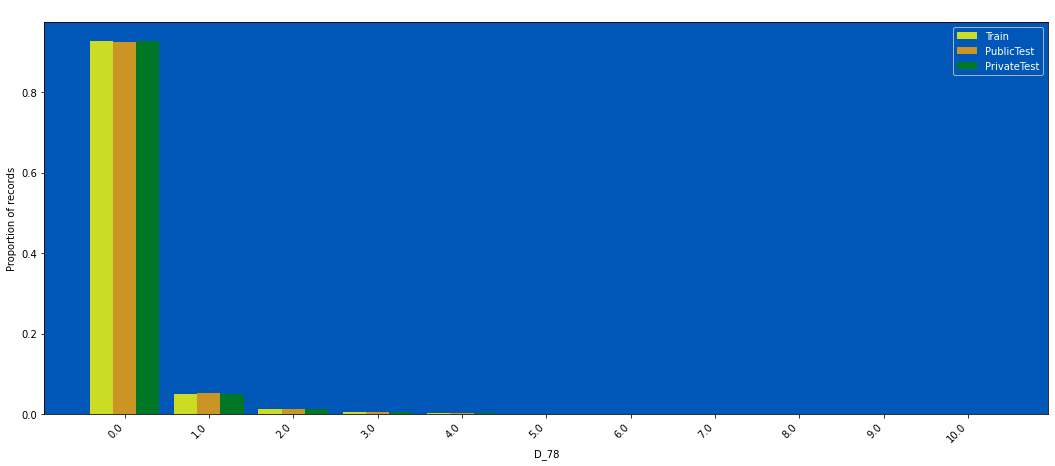

In [575]:
plot_train_test_distribution(df_list, "D_78", nunique_thr=500, without_drop_tail=True)

### D_79 (Done Integer)

In [584]:
# plot_target_check(train, "D_79", q=50, use_raw_bin=True)

In [577]:
%%time
df_list = round_dfs(df_list, col="D_79", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0121
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0115
CPU times: user 5.31 s, sys: 6.66 s, total: 12 s
Wall time: 18.8 s


In [581]:
for df in df_list:
    df["D_79"] = (df["D_79"] * 2).round(0)

In [585]:
describe_all(df_list, "D_79")

train    public test   private test
count           5,455,512.0000 5,666,723.0000 5,606,092.0000
mean                    0.1283         0.1579         0.1642
std                     0.4402         0.5062         0.5292
min                     0.0000         0.0000         0.0000
25%                     0.0000         0.0000         0.0000
50%                     0.0000         0.0000         0.0000
75%                     0.0000         0.0000         0.0000
max                    36.0000        26.0000        67.0000
null_proportion         0.0137         0.0092         0.0068

In [587]:
print_percentile(df_list, "D_79", 99.9)

99.9th percentile:
train : 4.0
public test : 4.0
private test : 5.0


In [588]:
for df in df_list:
    df = clip_col(df, "D_79", top_value=5, add_new_col=False)

75939 null count, 0.014 null proportion
0.3761 of the targets have label = 1


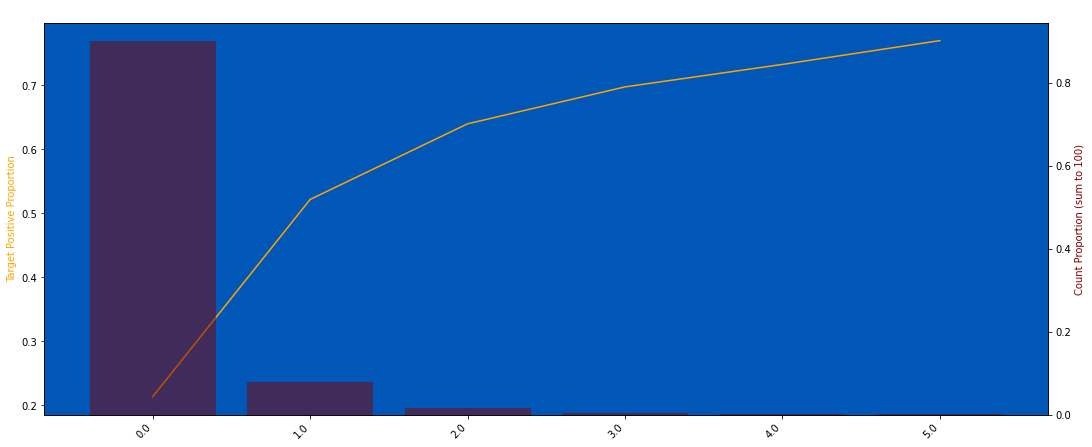

In [589]:
plot_target_check(train, "D_79", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0041, Train-Private PSI: 0.0058


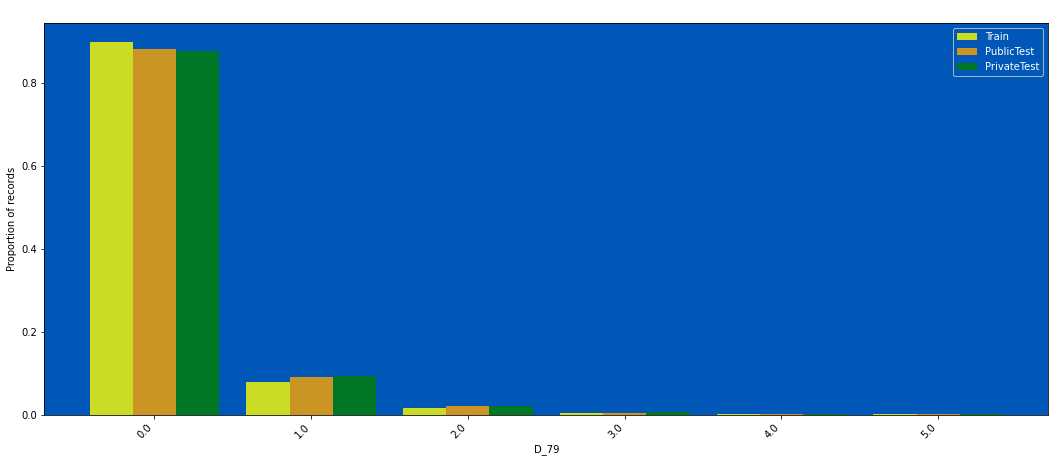

In [590]:
plot_train_test_distribution(df_list, "D_79", nunique_thr=500, without_drop_tail=True)

### D_80 (Done Integer)

In [599]:
# plot_target_check(train, "D_80", q=50, use_raw_bin=True)

In [592]:
%%time
df_list = round_dfs(df_list, col="D_80", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0063
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0027
CPU times: user 5.64 s, sys: 6.8 s, total: 12.4 s
Wall time: 19.9 s


In [596]:
for df in df_list:
    df["D_80"] = (df["D_80"] * 5).round(0)

In [665]:
describe_all(df_list, "D_80")

train    public test   private test
count           5,509,678.0000 5,700,232.0000 5,622,857.0000
mean                    0.5350         0.5203         0.5172
std                     1.0736         1.0751         1.0732
min                     0.0000         0.0000         0.0000
25%                     0.0000         0.0000         0.0000
50%                     0.0000         0.0000         0.0000
75%                     1.0000         1.0000         1.0000
max                    40.0000        34.0000        38.0000
null_proportion         0.0039         0.0034         0.0038

In [668]:
print_percentile(df_list, "D_80", 99.98)

99.98th percentile:
train : 13.0
public test : 13.0
private test : 13.0


In [669]:
for df in df_list:
    df = clip_col(df, "D_80", top_value=13, add_new_col=False)

21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1


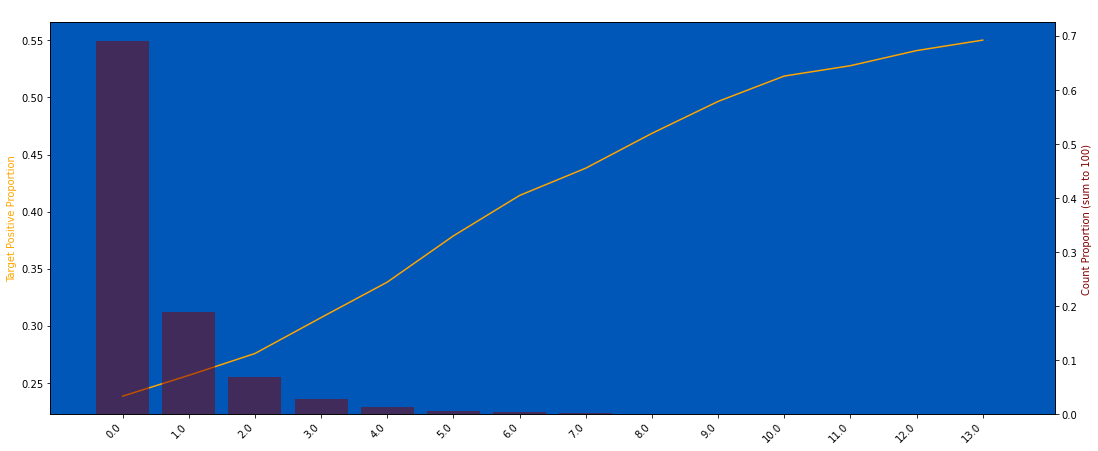

In [670]:
plot_target_check(train, "D_80", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0008, Train-Private PSI: 0.0009


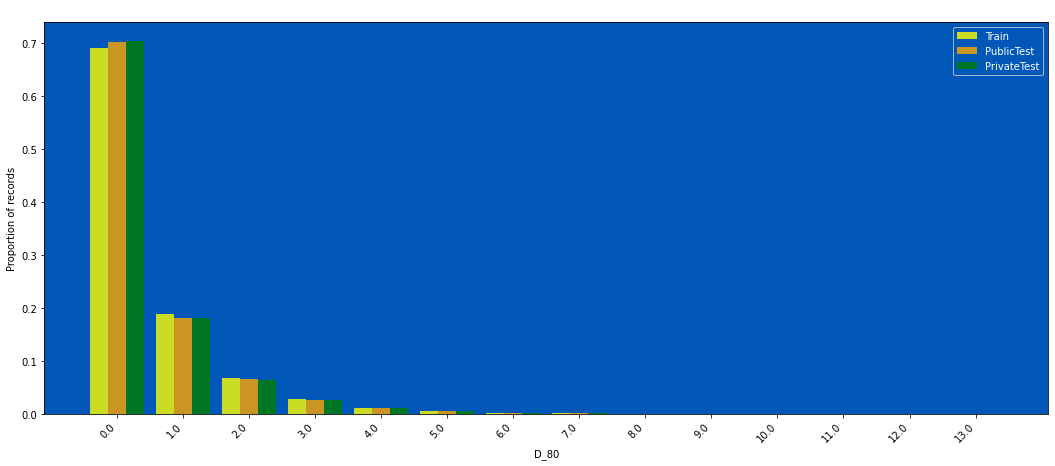

In [671]:
plot_train_test_distribution(df_list, "D_80", nunique_thr=500, without_drop_tail=True)

### D_81 (Done Integer)

In [672]:
# plot_target_check(train, "D_81", q=50, use_raw_bin=True)

In [601]:
%%time
df_list = round_dfs(df_list, col="D_81", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0003
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0003
CPU times: user 5.67 s, sys: 6.79 s, total: 12.5 s
Wall time: 20 s


25687 null count, 0.005 null proportion
0.3798 of the targets have label = 1


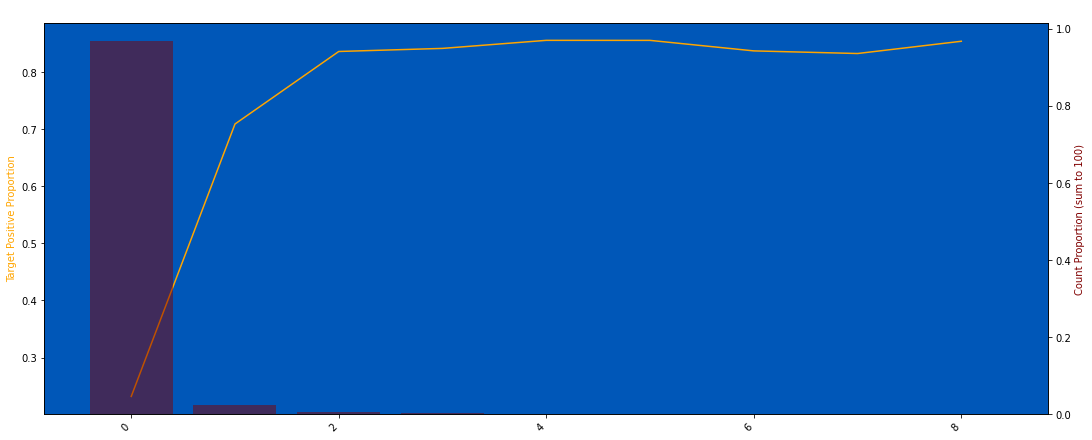

In [602]:
plot_target_check(train, "D_81", q=50, use_raw_bin=True, without_drop_tail=True)

Train-Public PSI: 0.0002, Train-Private PSI: 0.0003


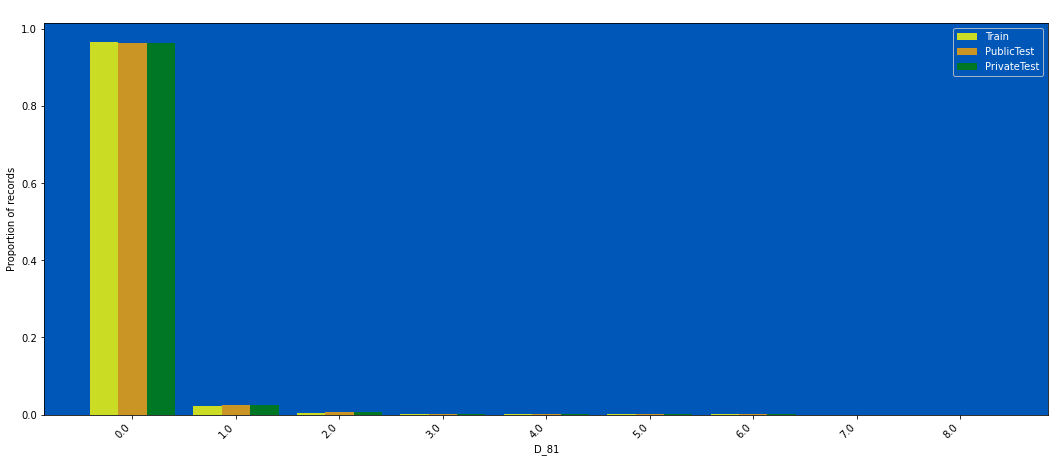

In [603]:
plot_train_test_distribution(df_list, "D_81", nunique_thr=500, without_drop_tail=True)

### D_82 (Done Integer)

In [678]:
# plot_target_check(train, "D_82", q=50, use_raw_bin=True)

In [605]:
%%time
df_list = round_dfs(df_list, col="D_82", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0027
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0021
CPU times: user 4.3 s, sys: 6.35 s, total: 10.6 s
Wall time: 17.4 s


In [609]:
for df in df_list:
    df["D_82"] = (df["D_82"] * 2).round(0)

In [680]:
describe_all(df_list, "D_82")

train    public test   private test
count           1,472,837.0000 1,438,247.0000 1,472,894.0000
mean                    0.9054         0.9374         0.9341
std                     0.3800         0.3475         0.3534
min                     0.0000         0.0000         0.0000
25%                     1.0000         1.0000         1.0000
50%                     1.0000         1.0000         1.0000
75%                     1.0000         1.0000         1.0000
max                     6.0000         8.0000        10.0000
null_proportion         0.7337         0.7485         0.7390

In [682]:
print_percentile(df_list, "D_82", 99.99)

99.99th percentile:
train : 4.0
public test : 4.0
private test : 4.0


In [688]:
for df in df_list:
    df = clip_col(df, "D_82", top_value=3, add_new_col=False)

4058614 null count, 0.734 null proportion
0.2648 of the targets have label = 1


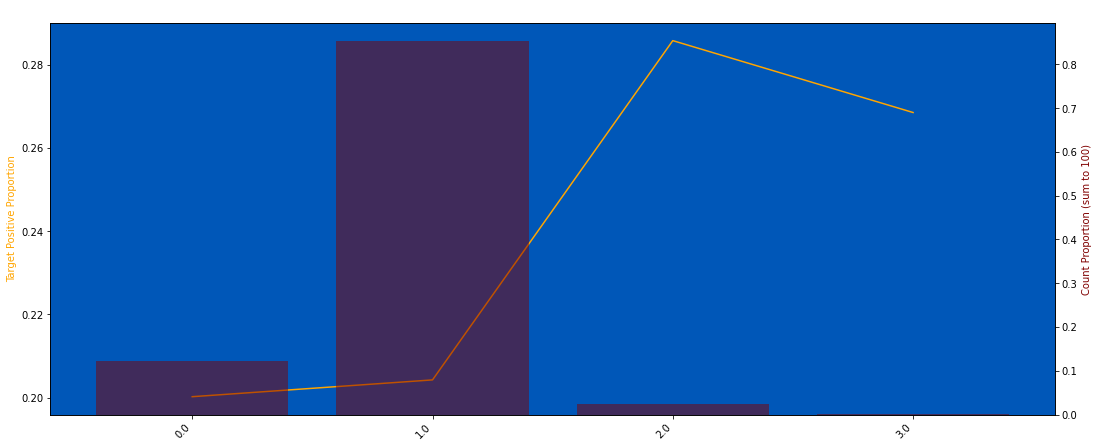

In [689]:
plot_target_check(train, "D_82", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0034, Train-Private PSI: 0.0021


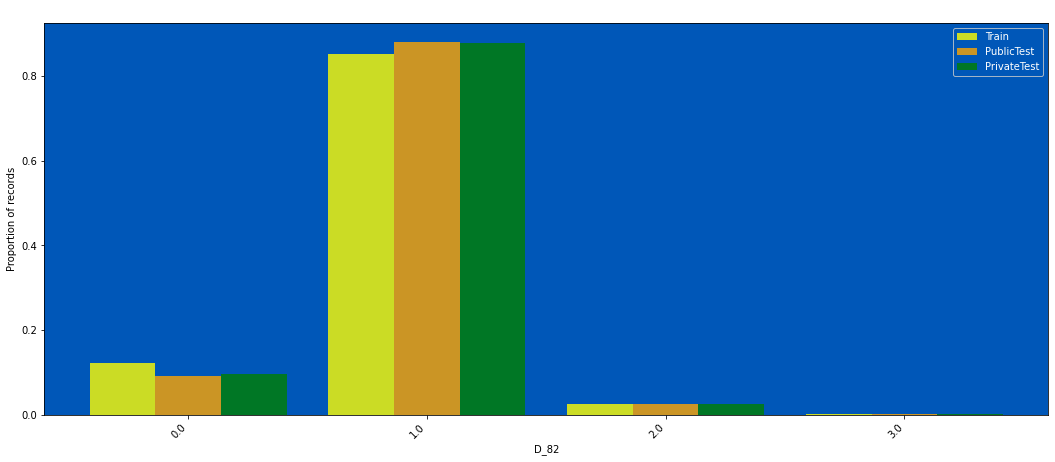

In [690]:
plot_train_test_distribution(df_list, "D_82", nunique_thr=500, without_drop_tail=True)

### D_83 (Done Integer)

In [687]:
# plot_target_check(train, "D_83", q=50, use_raw_bin=True)

In [613]:
%%time
df_list = round_dfs(df_list, col="D_83", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0082
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0082
CPU times: user 5.18 s, sys: 6.09 s, total: 11.3 s
Wall time: 18 s


In [698]:
describe_all(df_list, "D_83")

train    public test   private test
count           5,531,451.0000 5,719,469.0000 5,644,293.0000
mean                    0.0698         0.0552         0.0470
std                     0.3491         0.3064         0.2828
min                     0.0000         0.0000         0.0000
25%                     0.0000         0.0000         0.0000
50%                     0.0000         0.0000         0.0000
75%                     0.0000         0.0000         0.0000
max                    38.0000        48.0000        46.0000
null_proportion         0.0000         0.0000         0.0000

In [713]:
print_percentile(df_list, "D_83", 99.9)

99.9th percentile:
train : 4.0
public test : 3.0
private test : 3.0


In [712]:
for df in df_list:
    df = clip_col(df, "D_83", top_value=4, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


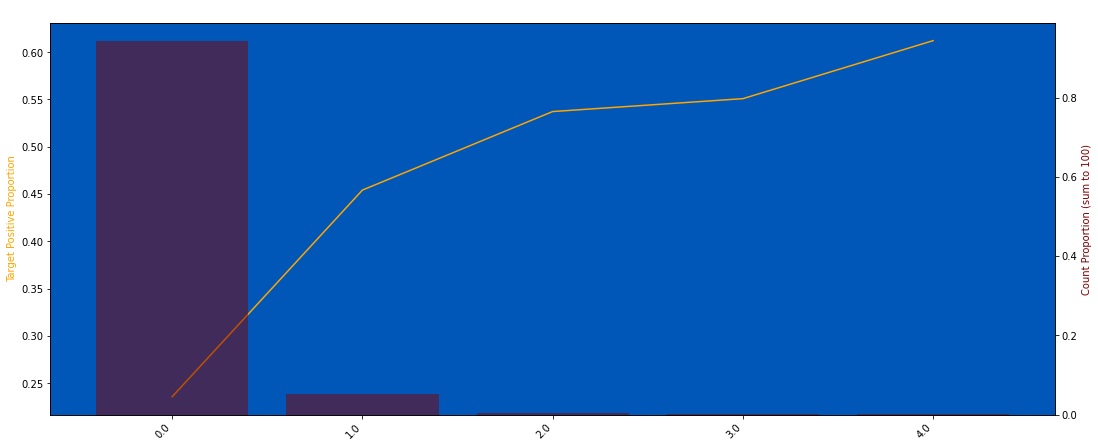

In [714]:
plot_target_check(train, "D_83", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0026, Train-Private PSI: 0.0072


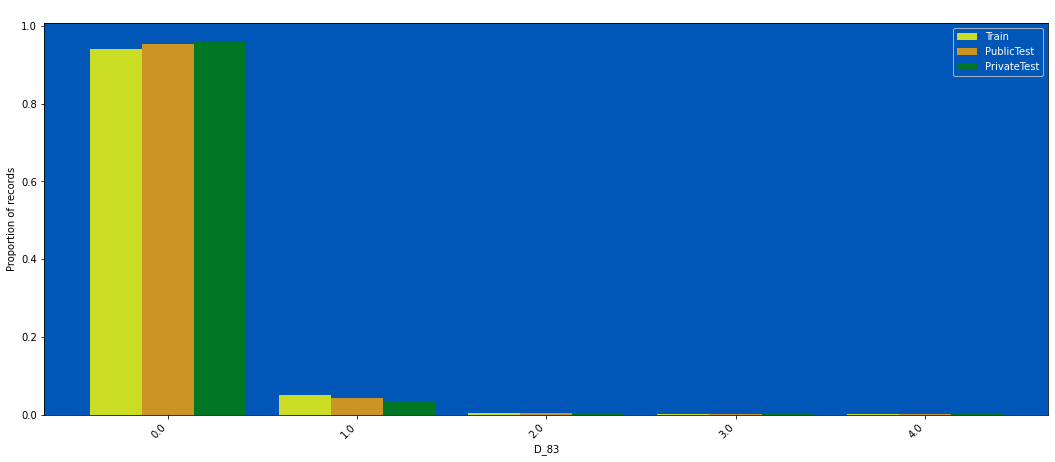

In [715]:
plot_train_test_distribution(df_list, "D_83", nunique_thr=500, without_drop_tail=True)

### D_84 (Done Integer)

In [716]:
# plot_target_check(train, "D_84", q=50, use_raw_bin=True)

In [617]:
%%time
df_list = round_dfs(df_list, col="D_84", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0044
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0032
CPU times: user 4.9 s, sys: 5.42 s, total: 10.3 s
Wall time: 15.2 s


In [619]:
for df in df_list:
    df["D_84"] = (df["D_84"] * 2).round(0)

In [719]:
for df in df_list:
    df["D_84"] = df["D_84"].fillna(1)

In [720]:
describe_all(df_list, "D_84")

train    public test   private test
count           5,531,451.0000 5,719,469.0000 5,644,293.0000
mean                    0.0844         0.0887         0.0871
std                     0.5725         0.6064         0.6043
min                     0.0000         0.0000         0.0000
25%                     0.0000         0.0000         0.0000
50%                     0.0000         0.0000         0.0000
75%                     0.0000         0.0000         0.0000
max                    58.0000        43.0000        39.0000
null_proportion         0.0000         0.0000         0.0000

In [722]:
print_percentile(df_list, "D_84", 99.99)

99.99th percentile:
train : 16.0
public test : 16.0
private test : 16.0


In [723]:
for df in df_list:
    df = clip_col(df, "D_84", top_value=15, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


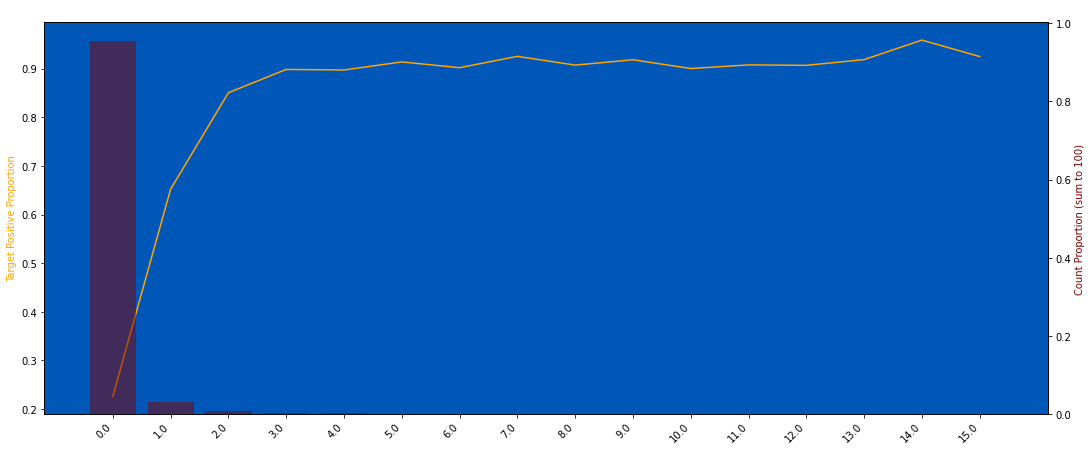

In [724]:
plot_target_check(train, "D_84", q=50, use_raw_bin=True, without_drop_tail=True, strfy_x=True)

Train-Public PSI: 0.0003, Train-Private PSI: 0.0005


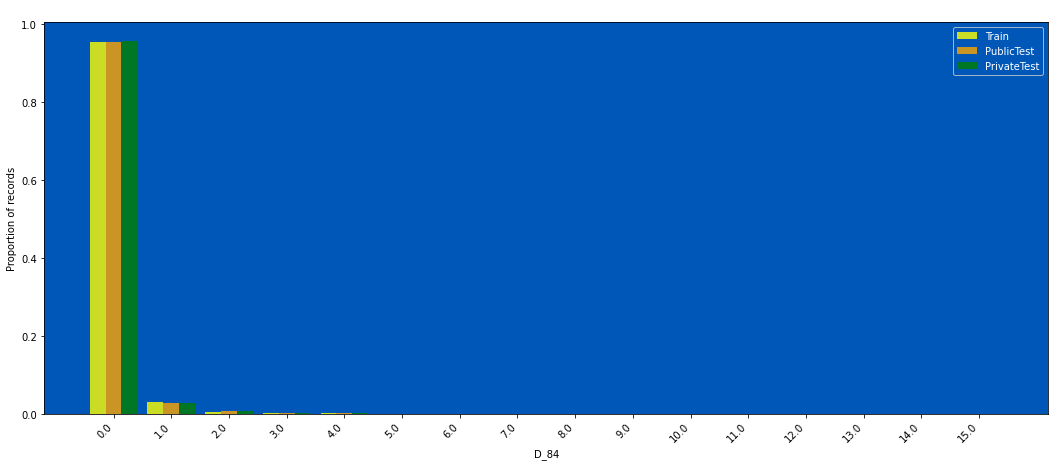

In [725]:
plot_train_test_distribution(df_list, "D_84", nunique_thr=500, without_drop_tail=True)

### D_86 (Done Binary)

In [726]:
# plot_target_check(train, "D_86", q=50, use_raw_bin=True)

In [623]:
%%time
df_list = round_dfs(df_list, col="D_86", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0000
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0000
CPU times: user 5.15 s, sys: 5.92 s, total: 11.1 s
Wall time: 16.4 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


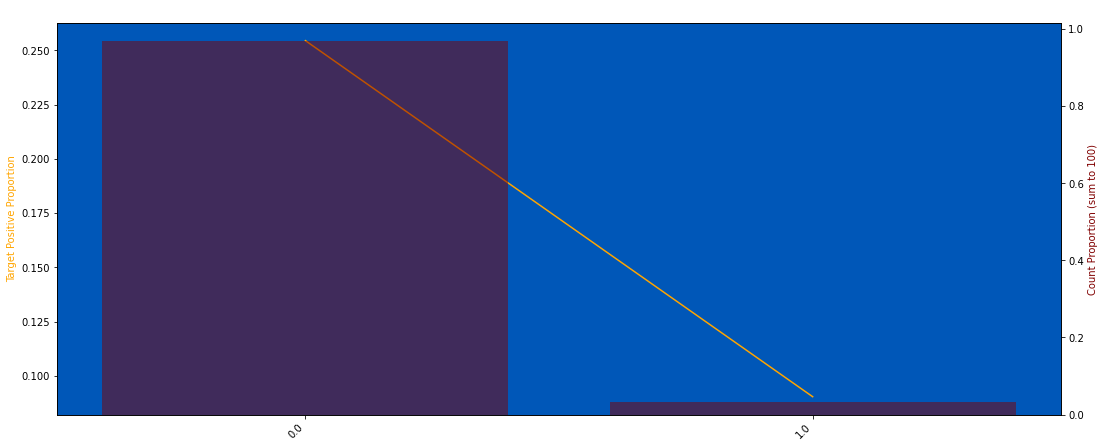

In [624]:
plot_target_check(train, "D_86", q=50, use_raw_bin=True, without_drop_tail=True, nunique_thr=500, strfy_x=True)

Train-Public PSI: 0.0008, Train-Private PSI: 0.0000
Bottom 1% and Top 1% are dropped from this chart


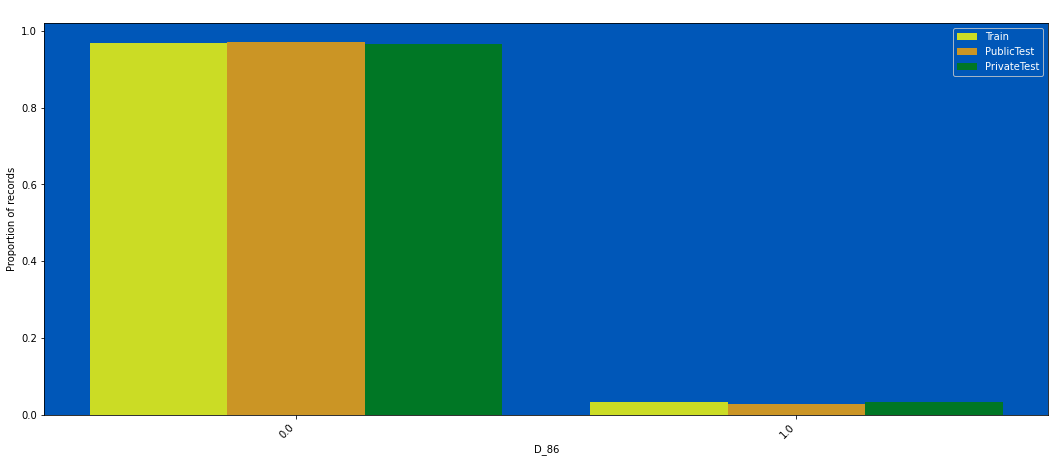

In [625]:
plot_train_test_distribution(df_list, "D_86", nunique_thr=500)

### D_87 (Drop)

In [727]:
# plot_target_check(train, "D_87", q=100, use_raw_bin=True, strfy_x=True, without_drop_tail=True)

In [728]:
# train["D_87"].value_counts(), public_test["D_87"].value_counts(), private_test["D_87"].value_counts()

In [729]:
train.groupby("D_87")["target"].mean()

D_87
0.0000   0.2487
1.0000   0.8670
Name: target, dtype: float64

In [731]:
%time
for df in df_list:
    df.drop(columns="D_87", errors="ignore", inplace=True)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 9.78 µs


### D_88 (KIV) Drift in Train Test

In [732]:
# plot_target_check(train, "D_88", q=50, use_raw_bin=True)

In [631]:
%%time
df_list = round_dfs(df_list, col="D_88", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0801
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0210
CPU times: user 3.92 s, sys: 5.73 s, total: 9.64 s
Wall time: 15.5 s


In [758]:
print_percentile(df_list, "D_88", 0.12)

0.12th percentile:
train : 0.0
public test : 0.0
private test : 0.0


In [759]:
for df in df_list:
    df["D_88"] = np.where(df["D_88"] < 0, np.nan, df["D_88"])
    # df = clip_col(df, "D_84", top_value=15, add_new_col=False)

In [762]:
describe_all(df_list, "D_88")

train  public test  private test
count           6,003.0000   5,981.0000    5,276.0000
mean                0.1673       0.1366        0.1211
std                 0.2181       0.2006        0.1815
min                 0.0000       0.0000        0.0000
25%                 0.0200       0.0200        0.0100
50%                 0.0800       0.0600        0.0500
75%                 0.2300       0.1700        0.1600
max                 2.6600       2.6700        3.0600
null_proportion     0.9989       0.9990        0.9991

5525448 null count, 0.999 null proportion
0.2485 of the targets have label = 1


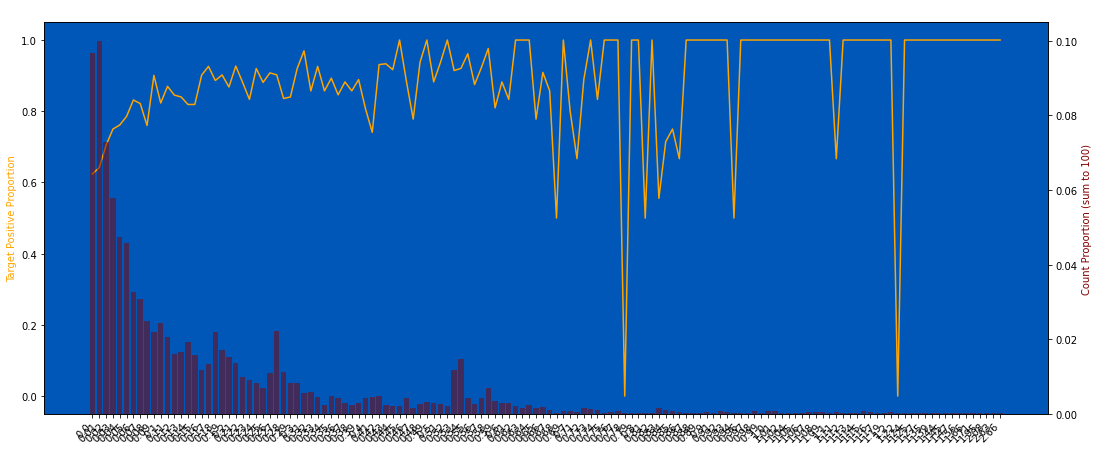

In [760]:
plot_target_check(train, "D_88", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0232, Train-Private PSI: 0.0210
Bottom 1% and Top 1% are dropped from this chart


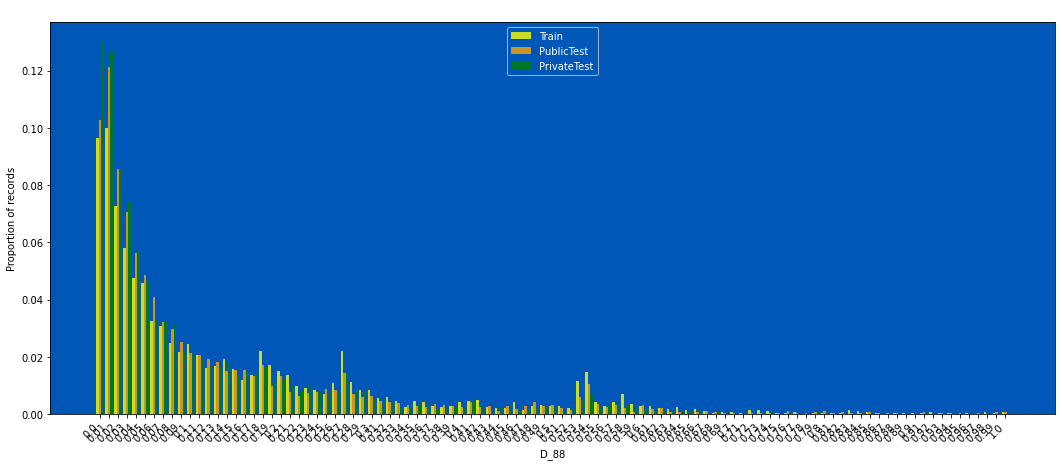

In [633]:
plot_train_test_distribution(df_list, "D_88", nunique_thr=500)

### D_89 (Done Integer)

In [768]:
# plot_target_check(train, "D_89", q=50, use_raw_bin=True, nunique_thr=12)

In [635]:
%%time
df_list = round_dfs(df_list, col="D_89", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0001
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0000
CPU times: user 4.57 s, sys: 4.51 s, total: 9.08 s
Wall time: 13.3 s


In [639]:
for df in df_list:
    df["D_89"] = (df["D_89"] * 100/11).round(0)

29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


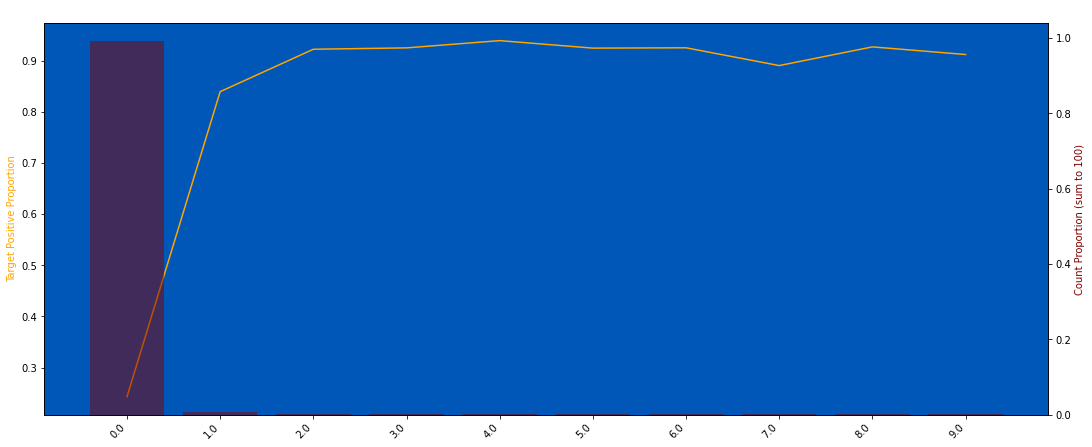

In [640]:
plot_target_check(train, "D_89", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0000, Train-Private PSI: 0.0000


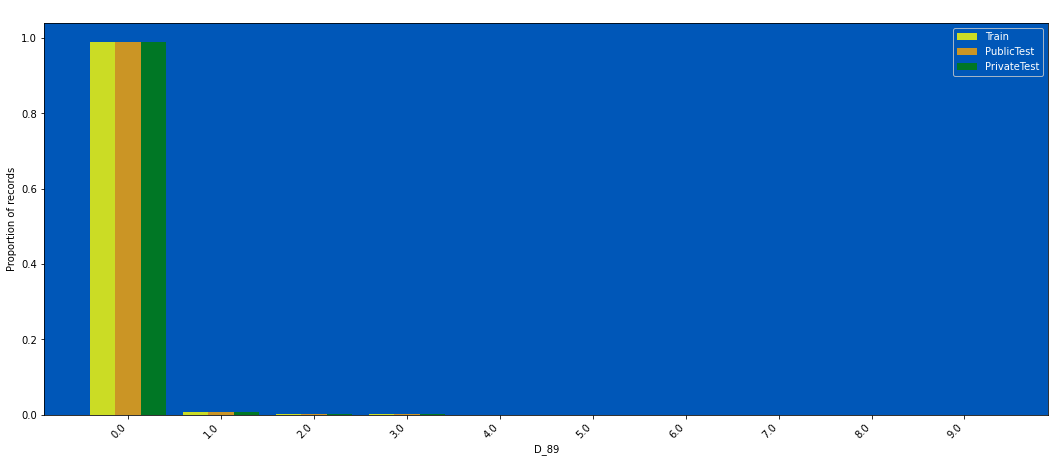

In [641]:
plot_train_test_distribution(df_list, "D_89", nunique_thr=500, without_drop_tail=True)

In [773]:
print_percentile(df_list, "D_89", 99.9)

99.9th percentile:
train : 2.0
public test : 2.0
private test : 2.0


In [774]:
for df in df_list:
    df = clip_col(df, "D_89", top_value=2, add_new_col=False)

In [775]:
describe_all(df_list, "D_89")

train    public test   private test
count           5,501,888.0000 5,702,956.0000 5,630,285.0000
mean                    0.0112         0.0119         0.0117
std                     0.1241         0.1289         0.1278
min                     0.0000         0.0000         0.0000
25%                     0.0000         0.0000         0.0000
50%                     0.0000         0.0000         0.0000
75%                     0.0000         0.0000         0.0000
max                     2.0000         2.0000         2.0000
null_proportion         0.0053         0.0029         0.0025

### D_91 (Done Integer)

In [776]:
# plot_target_check(train, "D_91", q=50, use_raw_bin=True)

In [643]:
%%time
df_list = round_dfs(df_list, col="D_91", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0023
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0012
CPU times: user 5.01 s, sys: 5.53 s, total: 10.5 s
Wall time: 15.8 s


In [778]:
print_percentile(df_list, "D_91", 99.91)

99.91th percentile:
train : 3.0
public test : 3.0
private test : 3.0


In [779]:
for df in df_list:
    df = clip_col(df, "D_91", top_value=2, add_new_col=False)

In [780]:
describe_all(df_list, "D_91")

train    public test   private test
count           5,374,235.0000 5,532,275.0000 5,391,090.0000
mean                    0.1122         0.1145         0.1232
std                     0.3576         0.3619         0.3740
min                     0.0000         0.0000         0.0000
25%                     0.0000         0.0000         0.0000
50%                     0.0000         0.0000         0.0000
75%                     0.0000         0.0000         0.0000
max                     2.0000         2.0000         2.0000
null_proportion         0.0284         0.0327         0.0449

157216 null count, 0.028 null proportion
0.4663 of the targets have label = 1


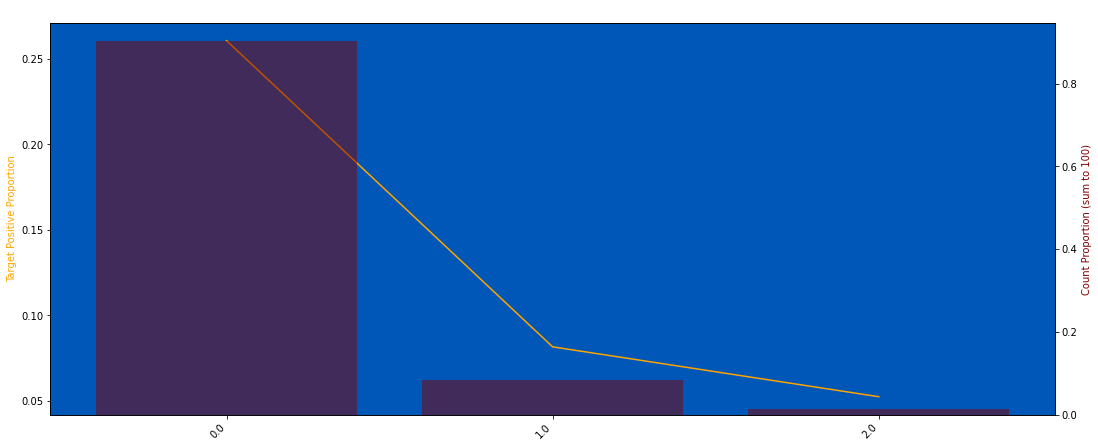

In [781]:
plot_target_check(train, "D_91", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0001, Train-Private PSI: 0.0012


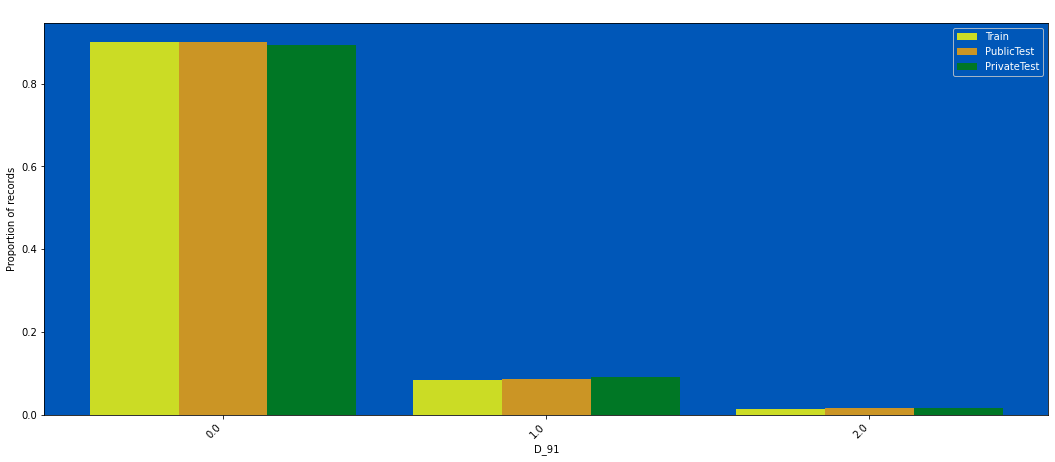

In [782]:
plot_train_test_distribution(df_list, "D_91", nunique_thr=12)

### D_92 (Done Integer)

In [783]:
# plot_target_check(train, "D_92", q=50, use_raw_bin=True)

In [649]:
%%time
df_list = round_dfs(df_list, col="D_92", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0028
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0028
CPU times: user 4.79 s, sys: 5.1 s, total: 9.89 s
Wall time: 15.6 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


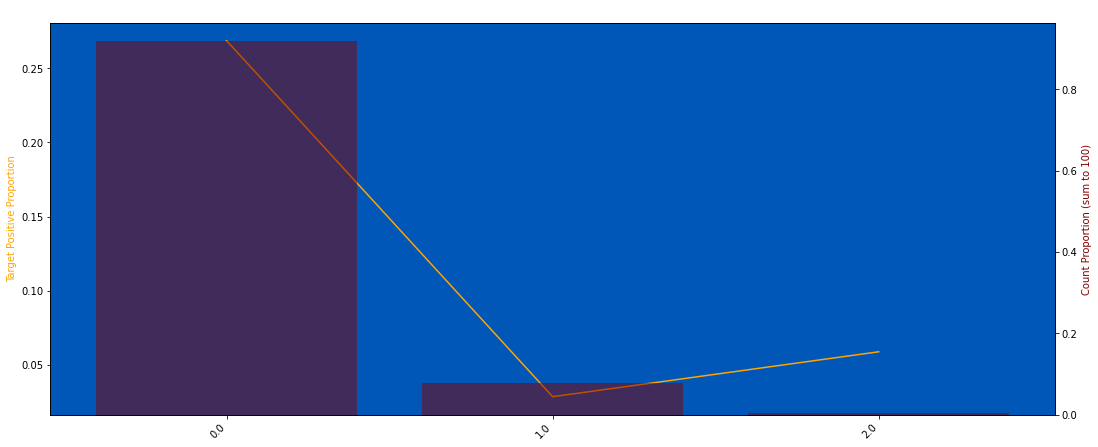

In [650]:
plot_target_check(train, "D_92", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0006, Train-Private PSI: 0.0028


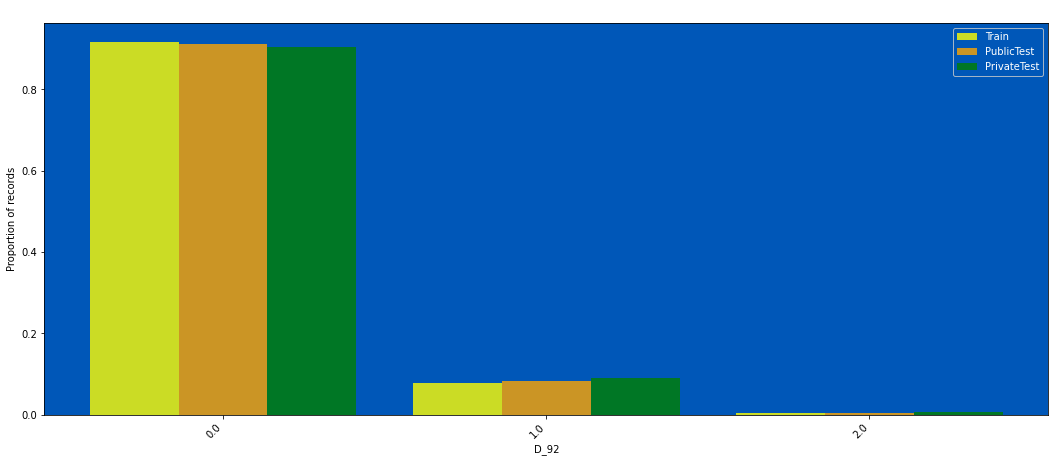

In [651]:
plot_train_test_distribution(df_list, "D_92", nunique_thr=12)

### D_93 (Done Binary)

In [784]:
# plot_target_check(train, "D_93", q=50, use_raw_bin=True)

In [653]:
%%time
df_list = round_dfs(df_list, col="D_93", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0011
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0011
CPU times: user 4.82 s, sys: 4.66 s, total: 9.48 s
Wall time: 14.3 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


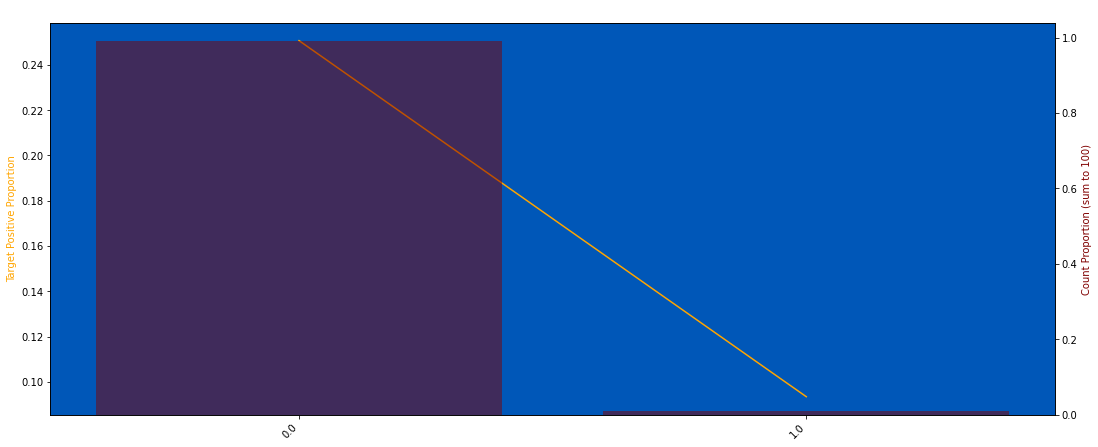

In [654]:
plot_target_check(train, "D_93", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0007, Train-Private PSI: 0.0011


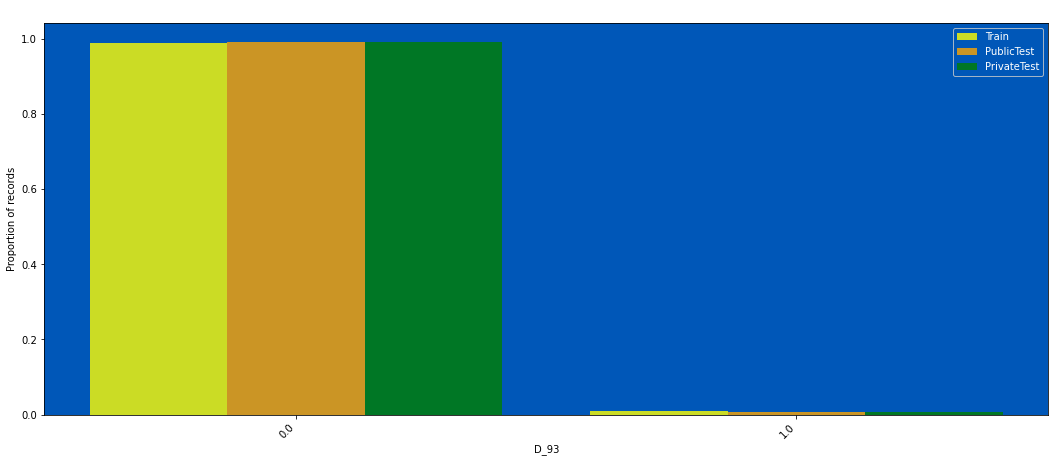

In [655]:
plot_train_test_distribution(df_list, "D_93", nunique_thr=12)

### D_94 (Done Binary)

In [785]:
# plot_target_check(train, "D_94", q=50, use_raw_bin=True)

In [657]:
%%time
df_list = round_dfs(df_list, col="D_94", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0002
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0002
CPU times: user 5.05 s, sys: 5.66 s, total: 10.7 s
Wall time: 15.7 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


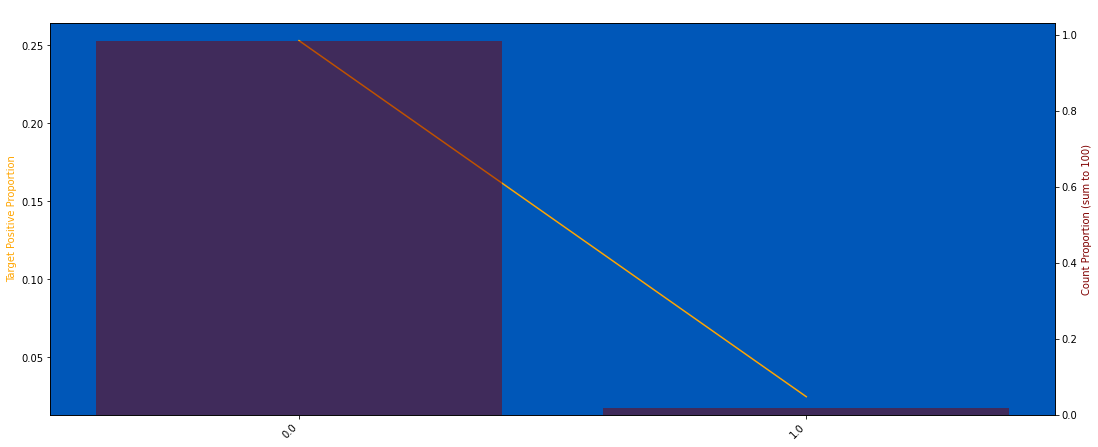

In [658]:
plot_target_check(train, "D_94", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0000, Train-Private PSI: 0.0002


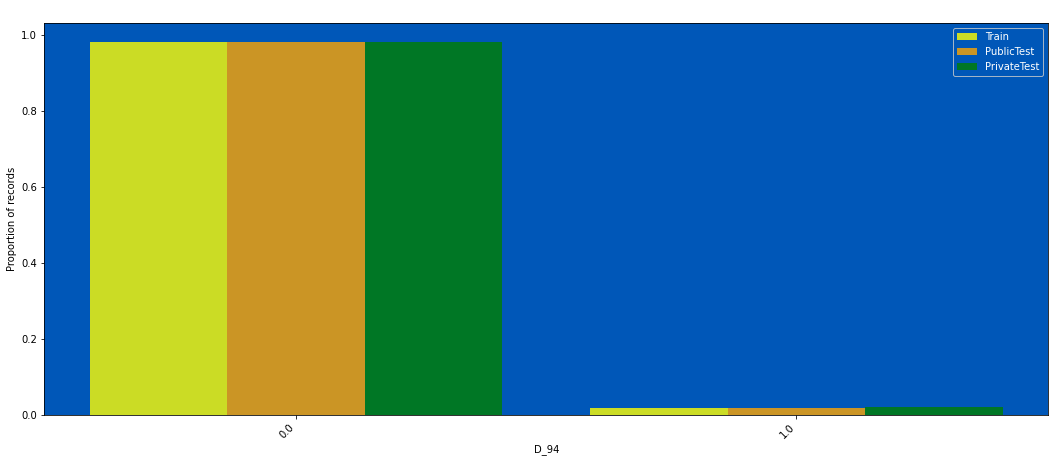

In [659]:
plot_train_test_distribution(df_list, "D_94", nunique_thr=12)

### D_96 (Done Binary)

In [786]:
# plot_target_check(train, "D_96", q=50, use_raw_bin=True)

In [661]:
%%time
df_list = round_dfs(df_list, col="D_96", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0006
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0005
CPU times: user 5.03 s, sys: 6.08 s, total: 11.1 s
Wall time: 16.7 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


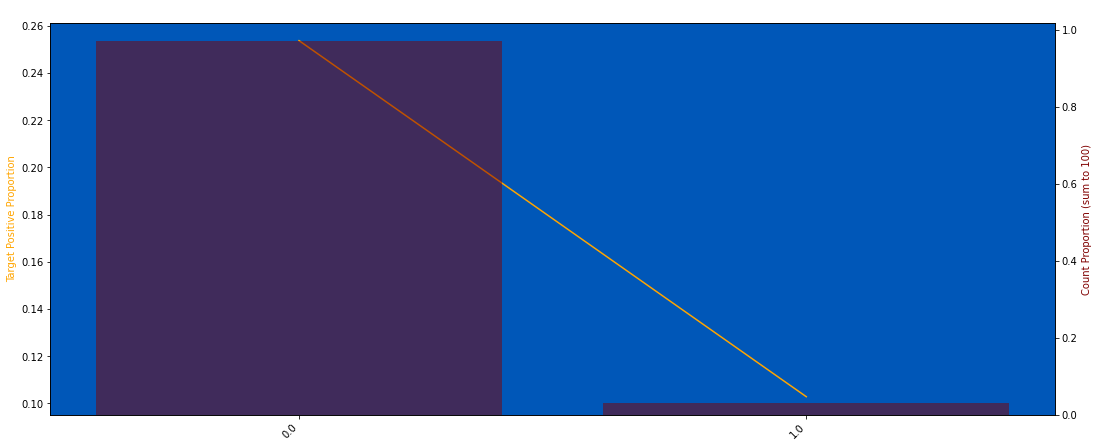

In [662]:
plot_target_check(train, "D_96", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0002, Train-Private PSI: 0.0005


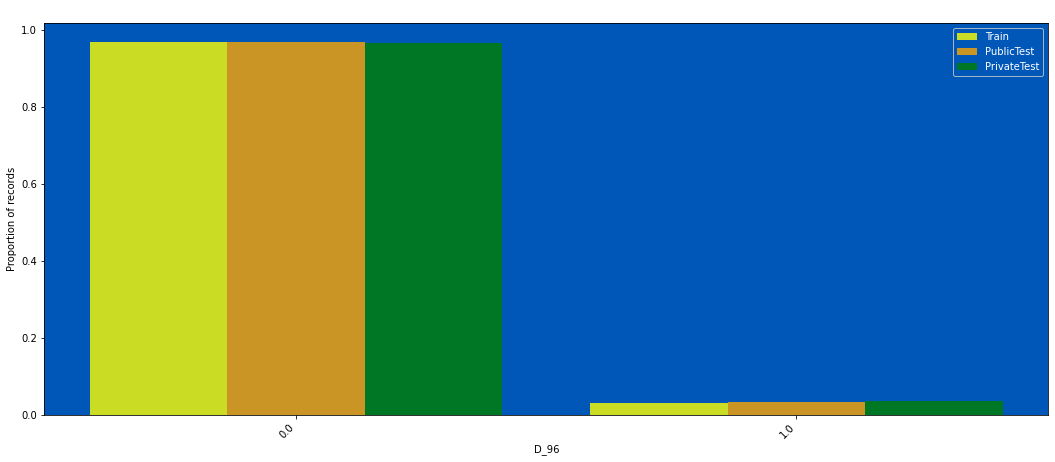

In [663]:
plot_train_test_distribution(df_list, "D_96", nunique_thr=12)

### Column checking

In [787]:
all_columns = get_cols(df_list[0], ["D_"])
print(all_columns)

['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_66', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96', 'D_70_', 'D_72_', 'D_74_', 'D_75_', 'D_78_', 'D_79_', 'D_80_', 'D_82_', 'D_89_']


In [ ]:
%%time
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 99].index.tolist()

In [ ]:
print(less_unique_d_cols)

In [ ]:
%%time
for col in less_unique_d_cols:
    temp = integerize(train[col])
    if (temp - train[col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to integer")
        for df in df_list:
            df[col] = integerize(df[col])

In [ ]:
%%time
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

In [ ]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

In [ ]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

In [ ]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

In [ ]:
train.shape, test.shape

In [ ]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

In [ ]:
%%time
train.to_parquet(f"./train_parquet/train_delinquency_part1.parquet")
test.to_parquet(f"./test_parquet/test_delinquency_part1.parquet")

In [ ]:
END = time.time()

In [ ]:
print(f"{END - START:.2f} seconds elapsed")

In [ ]:
test.shape

In [ ]:
END = time.time()

In [ ]:
print(f"{END - START:.2f} seconds elapsed")